In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from skimage.feature import hog
import mahotas
import cv2
import random
from tqdm import tqdm
from sklearn.feature_selection import SelectFromModel
import time

Set random seed for reproductivity

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# Modify the dir_path below to match the directory on your system
dataset_dir = r"C:\Users\Admin\Downloads\Machine Learning\Final Project\Dataset\Swimcat-extend"

# A helper function to load the data to a dataframe
- We will iterate through each folder, which contains the images of a class, in order to get the label for each class. We only get the name of the class: For example:  A-Clear Sky -> Clear Sky.
- Store the image path and its corresponding label to a dataframe -> The dataframe will have 2 columns: file path of the image and the label.

In [4]:
# Helper function to create DataFrame from dataset
def create_df(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, label)
        label_extracted = label.split('-')[-1].strip()
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                data.append({"file_path": file_path, "label": label_extracted})
    return pd.DataFrame(data)

In [5]:
df = create_df(dataset_dir)

# Drop the duplicated values

In [6]:
flattened_data = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    pixel_values = (np.array(cv2.imread(row['file_path']))).flatten()
    combined_row = [row['file_path'], row['label']] + pixel_values.tolist()
    flattened_data.append(combined_row)

n_pixels = 150 * 150 * 3
column_names = ['file_path', 'label'] + [f'pixel_{i}' for i in range(n_pixels)]
df_pixels = pd.DataFrame(flattened_data, columns=column_names)
# for col in df_pixels.columns[:-1]:
#     df_pixels[col] = pd.to_numeric(df_pixels[col])

print(df_pixels.duplicated().sum())

print('Before dropping: ',df_pixels.shape)
df_pixels = df_pixels.drop_duplicates(subset=[col for col in df_pixels.columns if col != 'file_path'])
print('After dropping: ', df_pixels.shape)

df = df_pixels[['file_path', 'label']]

100%|██████████████████████████████████████████████████████████████████| 2100/2100 [00:03<00:00, 649.00it/s]


0
Before dropping:  (2100, 67502)
After dropping:  (1875, 67502)


In [7]:
print('After dropping duplicates', df.shape)

df.to_csv('no_duplicated_df.csv', index=False)
print('Export to csv file successfully')

After dropping duplicates (1875, 2)
Export to csv file successfully


In [8]:
df = pd.read_csv('no_duplicated_df.csv')

# A helper function used to implement label to index mapping

In [9]:
def label_mapping(df):
    labels = sorted(df['label'].unique())
    return {label: idx for idx, label in enumerate(labels)}

In [10]:
label_map = label_mapping(df)
print(label_map)

{'Clear Sky': 0, 'Patterned Clouds': 1, 'Thick Dark Clouds': 2, 'Thick White Clouds': 3, 'Thin White Clouds': 4, 'Veil Clouds': 5}


In [11]:
print(df['label'].value_counts())

label
Clear Sky             348
Veil Clouds           338
Thick Dark Clouds     330
Patterned Clouds      315
Thick White Clouds    301
Thin White Clouds     243
Name: count, dtype: int64


# A helper function used to preprocess the data
- Resize(): Resize all the images to one size 150 x 150 pixels --> Ensure consistency while training.
- RandomHorizontalFlip(): Randomly flip the image horizontally (left to right) -> This would add variety to the training set which would help the model to not just memorize the position of features.
- Normalization(): Normalizing the pixels' value from range [0, 255] to [0, 1].

**-> After experimenting multiple times, we can conclude that for this cloud image task classification, the simpler the preprocessing step the more effective the model will learn.**

In [12]:
def preprocess_data(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize
    image = cv2.resize(image, (150, 150))

    # Random horizontal flip
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
    
    # Random rotation
    angle = random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((75, 75), angle, 1)
    image = cv2.warpAffine(image, M, (150, 150))

    # Color Jitter
    # def apply_color_jitter(img):
    #     brightness = 1 + random.uniform(-0.3, 0.3)
    #     contrast = 1 + random.uniform(-0.3, 0.3)
    #     saturation = 1 + random.uniform(-0.3, 0.3)

    #     hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
    #     hsv[:, :, 1] *= saturation
    #     hsv = np.clip(hsv, 0, 255)
    #     img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

    #     img = cv2.convertScaleAbs(img, alpha=contrast, beta=0)
    #     img = np.clip(img * brightness, 0, 255).astype(np.uint8)

    #     return img

    # image = apply_color_jitter(image)

    # Random Translation
    # max_shift = int(150 * 0.1)
    # tx = random.randint(-max_shift, max_shift)
    # ty = random.randint(-max_shift, max_shift)
    # M_translate = np.float32([[1, 0, tx], [0, 1, ty]])
    # image = cv2.warpAffine(image, M_translate, (150, 150))

    image_norm = image.astype(np.float32) / 255.0

    return image_norm    

## A helper function used to extract the features (this function will be called after calling the preprocess function)
- The features include:
  - Color histogram: After normalizing the pixels from [0, 255] to [0, 1], those pixels will be turned to bins (32 bins) of a histogram. Since all of the images in the dataset are RGB images, there will be 3 channels (red, green, blue) which also means that there will be 3 histograms for each image and in each histogram there will be 32 bins -> 3 x 32 = 96 (features). The color histogram also gets normalized by the sum of all 3 histograms.
  - GLCM (Gray-Level Co-occurence Matrix): This method captures the spatial relationship between pixel intensities in an image -> Helping to quantify texture patterns. Included GLCM features:
    - Contrast: Measures the intensity difference between a pixel and its neighbor. Higher contrast values indicate more variation in pixel intensity, making textures appear rougher.
    - Dissimilarity: Measures the variation in intensity between neighboring pixels. Dissimilarity considers about differences, making it useful for detecting subtle texture changes.
    - Homogenity: Assesses the closeness of elements in the GLCM to the diagonal. Higher homogenity means pixels are more similar to their neighbors.
    - Energy (Angular Second Moment - ASM): Represents uniformity in texture. Higher energy values indicate more homegenity.
    - Correlation: Evaluates how correlated pixel pairs are. A high correlation suggests a predictable relationship between pixel intensities.
  - LBP: LBP encodes local textures information by comparing each pixel with its neighbors and converting the differences into a binary pattern. The extracted LBP features are then represented as a histogram which serves as a feature vector.
  - Haralick: Computes Haralick texture features from the Gray-Level Co-occurence Matrix(GLCM) -> Takes the mean of the features across different GLCM directions (typically: 0, 45, 90, and 135) -> Creates a single feature vector.
  - HOG (Histogram of Oriented Gradients): Captures the distribution of gradient orientations in an image -> Effective for identifying shapes and textures.

In [13]:
# Feature extraction: Engineered features only (color histogram, GLCM, LBP)
def extract_features(image_np):
    # Color histogram (32 bins per channel)
    # hist_r, _ = np.histogram(image_np[:, :, 0], bins=32, range=(0, 255), density=True)
    # hist_g, _ = np.histogram(image_np[:, :, 1], bins=32, range=(0, 255), density=True)
    # hist_b, _ = np.histogram(image_np[:, :, 2], bins=32, range=(0, 255), density=True)

    hist_r, _ = np.histogram(image_np[:, :, 0], bins=32, range=(0, 1))
    hist_g, _ = np.histogram(image_np[:, :, 1], bins=32, range=(0, 1))
    hist_b, _ = np.histogram(image_np[:, :, 2], bins=32, range=(0, 1))
    
    # color_hist = np.concatenate([hist_r, hist_g, hist_b])
    color_hist = np.concatenate([hist_r, hist_g, hist_b]).astype("float")
    
    color_hist /= (color_hist.sum() + 1e-7)

    # GLCM features
    gray_image = rgb2gray(image_np)
    glcm = graycomatrix(gray_image.astype(int), distances=[1, 5], angles=[0, np.pi/4], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').ravel()
    dissimilarity = graycoprops(glcm, 'dissimilarity').ravel()
    homogeneity = graycoprops(glcm, 'homogeneity').ravel()
    energy = graycoprops(glcm, 'energy').ravel()
    correlation = graycoprops(glcm, 'correlation').ravel()
    glcm_features = np.concatenate([contrast, dissimilarity, homogeneity, energy, correlation])

    # LBP features
    lbp = local_binary_pattern(gray_image, P=16, R=2, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=18, range=(0, 18), density=True)

    lbp_hist = lbp_hist.astype(float)
    lbp_hist /= (lbp_hist.sum() + 1e-7)

    # Haralick features
    gray_uint8 =  (gray_image * 255).astype(np.uint8)
    haralick = mahotas.features.haralick(gray_uint8).mean(axis=0)

    # print(f'Haralick: {haralick}, length: {len(haralick)}')
    
    # HOG features
    hog_features = hog(
        gray_image,
        # orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        # block_norm='L2-Hys',
        # visualize=False,
        feature_vector=True
    )

    print(f'Hog: {hog_features}, length: {len(hog_features)}')
    
    # return np.concatenate([color_hist, glcm_features, lbp_hist, haralick, hog_features])  # 96 + 20 + 18 = 134 features
    combined = np.hstack([color_hist, glcm_features, lbp_hist, haralick, hog_features])
    return combined

# A function to apply features preprocessing and extraction

In [14]:
def extract_all_features(df):
    features_list = []
    labels_list = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_np = preprocess_data(row['file_path'])
        features = extract_features(image_np)
        features_list.append(features)
        labels_list.append(row['label'])

    X = np.array(features_list)
    y = np.array(labels_list)

    return X, y

In [15]:
X, y = extract_all_features(df)

print(X.shape)
print(y.shape)

C:\Users\Admin\PycharmProjects\MachineLearning\.venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
  0%|                                                                      | 2/1875 [00:00<04:32,  6.87it/s]

Hog: [0.         0.         0.         ... 0.00296569 0.00131758 0.        ], length: 10404
Hog: [0.        0.        0.        ... 0.        0.        0.3420999], length: 10404


  0%|▏                                                                     | 4/1875 [00:00<04:03,  7.68it/s]

Hog: [0.         0.         0.         ... 0.00577323 0.         0.05547318], length: 10404
Hog: [0.         0.         0.         ... 0.00355132 0.         0.22301868], length: 10404


  0%|▏                                                                     | 6/1875 [00:00<04:06,  7.57it/s]

Hog: [0.08494892 0.02437592 0.09803492 ... 0.10758074 0.01102064 0.08198805], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  0%|▎                                                                     | 8/1875 [00:01<04:12,  7.39it/s]

Hog: [0.66403514 0.00373352 0.01423125 ... 0.00681889 0.00809926 0.01078224], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.05303542], length: 10404


  1%|▎                                                                    | 10/1875 [00:01<04:04,  7.62it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.02674919 0.         0.         ... 0.         0.12400951 0.        ], length: 10404


  1%|▍                                                                    | 12/1875 [00:01<03:55,  7.92it/s]

Hog: [0.         0.         0.         ... 0.         0.00406069 0.00442801], length: 10404
Hog: [0.00103389 0.         0.         ... 0.12932685 0.10790979 0.05340317], length: 10404


  1%|▌                                                                    | 14/1875 [00:01<03:46,  8.23it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.14875098], length: 10404
Hog: [0.5489053  0.         0.         ... 0.03290216 0.00358929 0.5132945 ], length: 10404


  1%|▌                                                                    | 16/1875 [00:02<03:42,  8.35it/s]

Hog: [0.         0.0021639  0.         ... 0.0567347  0.03420235 0.05464235], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  1%|▋                                                                    | 18/1875 [00:02<03:40,  8.44it/s]

Hog: [0.         0.         0.         ... 0.00616732 0.00440363 0.1595237 ], length: 10404
Hog: [0.5544471  0.03151555 0.01787405 ... 0.02673604 0.07819698 0.        ], length: 10404


  1%|▋                                                                    | 20/1875 [00:02<03:43,  8.31it/s]

Hog: [0.4795902  0.04212553 0.07285722 ... 0.27337104 0.27337104 0.27337104], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.19444533], length: 10404


  1%|▊                                                                    | 22/1875 [00:02<03:37,  8.52it/s]

Hog: [0.         0.         0.         ... 0.00360119 0.01037934 0.        ], length: 10404
Hog: [0.57394546 0.         0.         ... 0.0046137  0.         0.5312358 ], length: 10404


  1%|▉                                                                    | 24/1875 [00:03<03:36,  8.54it/s]

Hog: [0.5738988  0.         0.         ... 0.00647673 0.0281787  0.06999842], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.08865385], length: 10404


  1%|▉                                                                    | 26/1875 [00:03<03:40,  8.37it/s]

Hog: [0.         0.         0.         ... 0.07097637 0.01300549 0.        ], length: 10404
Hog: [0.24500759 0.         0.         ... 0.00218813 0.002751   0.00263925], length: 10404


  1%|█                                                                    | 28/1875 [00:03<03:48,  8.09it/s]

Hog: [0.         0.         0.         ... 0.00576053 0.00204222 0.00862797], length: 10404
Hog: [0.70633394 0.         0.         ... 0.         0.         0.        ], length: 10404


  2%|█                                                                    | 30/1875 [00:03<03:48,  8.06it/s]

Hog: [0.         0.         0.         ... 0.00158267 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  2%|█▏                                                                   | 32/1875 [00:04<03:54,  7.86it/s]

Hog: [0.583542   0.         0.003691   ... 0.26374397 0.15895724 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00171187 0.         0.        ], length: 10404


  2%|█▎                                                                   | 34/1875 [00:04<03:49,  8.01it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.16577178], length: 10404
Hog: [0.         0.         0.         ... 0.00382189 0.         0.        ], length: 10404


  2%|█▎                                                                   | 36/1875 [00:04<03:51,  7.94it/s]

Hog: [0.         0.         0.         ... 0.00271997 0.         0.00054692], length: 10404
Hog: [0.        0.        0.        ... 0.0005205 0.        0.       ], length: 10404


  2%|█▍                                                                   | 38/1875 [00:04<03:50,  7.96it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  2%|█▍                                                                   | 40/1875 [00:05<03:50,  7.95it/s]

Hog: [0.7027945  0.         0.         ... 0.05449316 0.02896538 0.01266106], length: 10404
Hog: [0.69903505 0.00206765 0.00111558 ... 0.02409966 0.07109291 0.25498775], length: 10404


  2%|█▌                                                                   | 42/1875 [00:05<03:42,  8.23it/s]

Hog: [0.         0.         0.         ... 0.01149879 0.         0.01160068], length: 10404
Hog: [0.01519927 0.00087935 0.         ... 0.24867766 0.2854067  0.11477148], length: 10404


  2%|█▌                                                                   | 44/1875 [00:05<03:37,  8.42it/s]

Hog: [0.00712629 0.         0.         ... 0.12863486 0.01524515 0.05127209], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.08288094], length: 10404


  2%|█▋                                                                   | 46/1875 [00:05<03:34,  8.54it/s]

Hog: [0.         0.         0.         ... 0.00111528 0.00082711 0.00190212], length: 10404
Hog: [0.5710818  0.         0.         ... 0.02910101 0.01686322 0.5342554 ], length: 10404


  3%|█▊                                                                   | 48/1875 [00:05<03:34,  8.51it/s]

Hog: [0.         0.         0.         ... 0.         0.002602   0.00163534], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  3%|█▊                                                                   | 50/1875 [00:06<03:33,  8.54it/s]

Hog: [0.58514565 0.         0.         ... 0.00297052 0.         0.47700343], length: 10404
Hog: [0.         0.         0.         ... 0.01555972 0.00919951 0.36702886], length: 10404


  3%|█▉                                                                   | 52/1875 [00:06<03:34,  8.49it/s]

Hog: [0.         0.         0.         ... 0.01884778 0.03490601 0.1164384 ], length: 10404
Hog: [0.16107745 0.         0.         ... 0.03347127 0.09961434 0.27176636], length: 10404


  3%|█▉                                                                   | 54/1875 [00:06<03:34,  8.47it/s]

Hog: [0.         0.         0.         ... 0.         0.00155534 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00431241 0.00291764 0.00294094], length: 10404


  3%|██                                                                   | 56/1875 [00:06<03:32,  8.57it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00602955 0.27262583], length: 10404


  3%|██▏                                                                  | 58/1875 [00:07<03:27,  8.76it/s]

Hog: [0.         0.         0.01007694 ... 0.04749787 0.06821015 0.11940125], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.13265695], length: 10404


  3%|██▏                                                                  | 60/1875 [00:07<03:31,  8.59it/s]

Hog: [0.       0.       0.       ... 0.       0.       0.373304], length: 10404
Hog: [0.7033729  0.         0.         ... 0.19466232 0.02915845 0.01243514], length: 10404


  3%|██▎                                                                  | 62/1875 [00:07<03:33,  8.50it/s]

Hog: [0.01303715 0.         0.         ... 0.01490001 0.00253456 0.39678624], length: 10404
Hog: [0.         0.         0.         ... 0.00283286 0.00287245 0.39637676], length: 10404


  3%|██▎                                                                  | 64/1875 [00:07<03:31,  8.56it/s]

Hog: [0.70269346 0.         0.         ... 0.04490354 0.         0.        ], length: 10404
Hog: [0.        0.        0.        ... 0.        0.        0.2747132], length: 10404


  4%|██▍                                                                  | 66/1875 [00:08<03:36,  8.34it/s]

Hog: [0.         0.         0.         ... 0.         0.00201182 0.28145295], length: 10404
Hog: [0.43920854 0.         0.         ... 0.         0.04040431 0.3796704 ], length: 10404


  4%|██▌                                                                  | 68/1875 [00:08<03:29,  8.62it/s]

Hog: [0.6727487  0.         0.         ... 0.02176185 0.         0.        ], length: 10404
Hog: [0.57068795 0.         0.         ... 0.01433222 0.01549918 0.53956634], length: 10404


  4%|██▌                                                                  | 70/1875 [00:08<03:29,  8.61it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.54717684 0.         0.         ... 0.02375825 0.08685198 0.49296334], length: 10404


  4%|██▋                                                                  | 72/1875 [00:08<03:24,  8.81it/s]

Hog: [0.0848332  0.         0.         ... 0.29154572 0.0704179  0.04861769], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  4%|██▋                                                                  | 74/1875 [00:08<03:24,  8.82it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.07453638], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  4%|██▊                                                                  | 76/1875 [00:09<03:19,  9.02it/s]

Hog: [0.        0.        0.        ... 0.0073196 0.        0.524576 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.52582735 0.         0.         ... 0.         0.         0.        ], length: 10404


  4%|██▉                                                                  | 79/1875 [00:09<03:14,  9.21it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.04261103 0.         0.09528051], length: 10404
Hog: [0.11520885 0.         0.00691664 ... 0.01950012 0.03420084 0.01790038], length: 10404


  4%|███                                                                  | 83/1875 [00:09<03:09,  9.48it/s]

Hog: [0.7040772  0.         0.         ... 0.08641781 0.12803651 0.3719855 ], length: 10404
Hog: [0.5484207  0.         0.         ... 0.0333593  0.01657865 0.35404164], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  5%|███▏                                                                 | 86/1875 [00:10<02:56, 10.11it/s]

Hog: [0.         0.         0.         ... 0.         0.00368363 0.        ], length: 10404
Hog: [0.        0.        0.        ... 0.        0.        0.2711446], length: 10404
Hog: [0.         0.         0.         ... 0.00077671 0.00065761 0.        ], length: 10404


  5%|███▏                                                                 | 88/1875 [00:10<03:02,  9.77it/s]

Hog: [0.         0.         0.         ... 0.00634164 0.         0.        ], length: 10404
Hog: [0.00423298 0.         0.         ... 0.27375084 0.17005953 0.03394401], length: 10404
Hog: [0.00221115 0.00097165 0.         ... 0.12878531 0.07872845 0.07583722], length: 10404


  5%|███▎                                                                 | 91/1875 [00:10<03:02,  9.77it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.13843349], length: 10404
Hog: [0.7057861  0.0015476  0.         ... 0.1222998  0.17308602 0.1759834 ], length: 10404


  5%|███▍                                                                 | 93/1875 [00:10<03:05,  9.61it/s]

Hog: [0.6854636  0.         0.00944328 ... 0.2638067  0.06555751 0.11130487], length: 10404
Hog: [0.0128152  0.00386922 0.01491742 ... 0.04481241 0.05225996 0.08777305], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.26949167], length: 10404


  5%|███▌                                                                 | 96/1875 [00:11<03:06,  9.55it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  5%|███▌                                                                 | 98/1875 [00:11<03:05,  9.57it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.18220021], length: 10404
Hog: [0.         0.         0.01893731 ... 0.         0.         0.        ], length: 10404


  5%|███▋                                                                | 101/1875 [00:11<03:02,  9.74it/s]

Hog: [0.         0.         0.         ... 0.00459435 0.00429218 0.0034981 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00200235 0.00212956], length: 10404


  5%|███▋                                                                | 103/1875 [00:12<03:11,  9.24it/s]

Hog: [0.00024156 0.         0.00321516 ... 0.         0.08441577 0.        ], length: 10404
Hog: [0.69344276 0.         0.         ... 0.26977372 0.13611846 0.11923888], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  6%|███▉                                                                | 107/1875 [00:12<02:56, 10.03it/s]

Hog: [0.         0.         0.         ... 0.00646245 0.01228206 0.007124  ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.13254775], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  6%|███▉                                                                | 109/1875 [00:12<02:54, 10.13it/s]

Hog: [0.6995056  0.         0.         ... 0.02139706 0.         0.53578246], length: 10404
Hog: [0.         0.         0.         ... 0.04198212 0.         0.01052878], length: 10404
Hog: [0.        0.        0.        ... 0.        0.        0.1799692], length: 10404


  6%|████                                                                | 113/1875 [00:13<02:55, 10.02it/s]

Hog: [0.         0.         0.         ... 0.0024708  0.00409342 0.0011435 ], length: 10404
Hog: [0.         0.         0.         ... 0.02578068 0.00770296 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.19950372], length: 10404


  6%|████▏                                                               | 116/1875 [00:13<02:55, 10.01it/s]

Hog: [0.        0.        0.        ... 0.0039229 0.0012984 0.       ], length: 10404
Hog: [0.54553264 0.         0.         ... 0.00158892 0.04589565 0.47387004], length: 10404
Hog: [0.55552596 0.         0.         ... 0.03040102 0.01167193 0.5104309 ], length: 10404


  6%|████▎                                                               | 119/1875 [00:13<02:54, 10.04it/s]

Hog: [0.         0.         0.         ... 0.00735141 0.         0.        ], length: 10404
Hog: [0.4945603  0.         0.         ... 0.012567   0.         0.42988503], length: 10404
Hog: [0.5679109  0.         0.         ... 0.01217465 0.01123902 0.45295143], length: 10404


  6%|████▍                                                               | 121/1875 [00:13<02:55,  9.99it/s]

Hog: [0.         0.         0.00566844 ... 0.02580238 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00595137 0.36032546], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  7%|████▍                                                               | 124/1875 [00:14<03:06,  9.37it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  7%|████▌                                                               | 126/1875 [00:14<03:01,  9.66it/s]

Hog: [0.6986764  0.00530794 0.00330269 ... 0.08774471 0.01644604 0.        ], length: 10404
Hog: [0.7060685  0.         0.         ... 0.01079853 0.00184262 0.55406857], length: 10404


  7%|████▋                                                               | 128/1875 [00:14<03:00,  9.68it/s]

Hog: [0.7004226  0.         0.         ... 0.02950337 0.00272747 0.61927176], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00073573], length: 10404


  7%|████▋                                                               | 129/1875 [00:14<02:58,  9.76it/s]

Hog: [0.         0.         0.         ... 0.00497652 0.         0.2470966 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  7%|████▊                                                               | 133/1875 [00:15<02:53, 10.02it/s]

Hog: [0.         0.         0.         ... 0.00240312 0.00059499 0.46694294], length: 10404
Hog: [0.         0.         0.         ... 0.00290547 0.00640691 0.36718065], length: 10404
Hog: [0.7054106  0.         0.         ... 0.00229245 0.         0.4949021 ], length: 10404


  7%|████▉                                                               | 136/1875 [00:15<02:47, 10.35it/s]

Hog: [0.00428868 0.         0.         ... 0.00352298 0.         0.41411325], length: 10404
Hog: [0.         0.         0.         ... 0.00349931 0.         0.08651919], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  7%|█████                                                               | 138/1875 [00:15<02:47, 10.37it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.03243499 0.         0.         ... 0.00291078 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00831418 0.01405334 0.20053382], length: 10404


  8%|█████▏                                                              | 142/1875 [00:15<02:45, 10.45it/s]

Hog: [0.         0.         0.         ... 0.00064652 0.00147187 0.00041028], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.13584846], length: 10404
Hog: [0.6343265  0.         0.         ... 0.01982228 0.02989941 0.02816479], length: 10404


  8%|█████▏                                                              | 144/1875 [00:16<02:46, 10.42it/s]

Hog: [0.68482    0.         0.         ... 0.0327092  0.06754189 0.04021315], length: 10404
Hog: [6.5376908e-01 0.0000000e+00 0.0000000e+00 ... 6.5077853e-04 0.0000000e+00
 4.3464437e-01], length: 10404


  8%|█████▎                                                              | 146/1875 [00:16<02:44, 10.52it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.700319   0.         0.         ... 0.0292569  0.05328348 0.5755241 ], length: 10404
Hog: [0.69844526 0.         0.00161839 ... 0.11466887 0.01690264 0.01133247], length: 10404


  8%|█████▎                                                              | 148/1875 [00:16<02:44, 10.52it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.00774151 0.         0.         ... 0.03830107 0.03128537 0.0211587 ], length: 10404
Hog: [0.7069091  0.         0.00188752 ... 0.03219545 0.         0.        ], length: 10404


  8%|█████▌                                                              | 152/1875 [00:16<02:45, 10.44it/s]

Hog: [0.69729865 0.         0.         ... 0.23004892 0.08419289 0.03742594], length: 10404
Hog: [0.         0.         0.         ... 0.         0.05303156 0.21304114], length: 10404
Hog: [0.         0.         0.         ... 0.00436547 0.00845507 0.40766975], length: 10404


  8%|█████▋                                                              | 156/1875 [00:17<02:37, 10.92it/s]

Hog: [0.6915682  0.00682129 0.02067658 ... 0.         0.         0.        ], length: 10404
Hog: [0.6431817  0.         0.03284558 ... 0.         0.         0.        ], length: 10404
Hog: [0.56530285 0.02696869 0.03581446 ... 0.01326335 0.02915404 0.02897157], length: 10404


  8%|█████▋                                                              | 158/1875 [00:17<02:38, 10.83it/s]

Hog: [0.         0.         0.         ... 0.01558272 0.02355494 0.08009032], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00863045 0.02005434 0.02802102], length: 10404


  9%|█████▉                                                              | 162/1875 [00:17<02:33, 11.13it/s]

Hog: [0.7048063  0.00453508 0.         ... 0.25969145 0.15159692 0.4336275 ], length: 10404
Hog: [0.         0.         0.         ... 0.0024911  0.00241484 0.35831833], length: 10404
Hog: [0.         0.         0.         ... 0.00643924 0.         0.4254345 ], length: 10404


  9%|█████▉                                                              | 164/1875 [00:17<02:35, 10.98it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.7059088  0.         0.         ... 0.09492198 0.12858896 0.23942918], length: 10404


  9%|██████                                                              | 168/1875 [00:18<02:37, 10.84it/s]

Hog: [0.         0.         0.         ... 0.00805083 0.00673983 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00224366 0.00151899 0.18603168], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  9%|██████▏                                                             | 170/1875 [00:18<02:36, 10.89it/s]

Hog: [0.         0.         0.         ... 0.019894   0.01598235 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.01608955 0.0143832  0.33791292], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


  9%|██████▎                                                             | 174/1875 [00:18<02:31, 11.21it/s]

Hog: [0.         0.         0.         ... 0.00264127 0.00685844 0.24589734], length: 10404
Hog: [0.         0.         0.         ... 0.00416536 0.00107633 0.37088305], length: 10404
Hog: [0.        0.        0.        ... 0.        0.        0.3022123], length: 10404


  9%|██████▍                                                             | 176/1875 [00:19<02:32, 11.18it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00170634 0.2689007 ], length: 10404
Hog: [0.         0.         0.         ... 0.00624921 0.         0.25017557], length: 10404


 10%|██████▌                                                             | 180/1875 [00:19<02:32, 11.10it/s]

Hog: [0.         0.         0.         ... 0.00509905 0.0037195  0.00083352], length: 10404
Hog: [0.03214084 0.         0.         ... 0.01341953 0.00351973 0.0199051 ], length: 10404
Hog: [0.         0.         0.         ... 0.0025923  0.         0.47261053], length: 10404


 10%|██████▌                                                             | 182/1875 [00:19<02:28, 11.37it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.6506458  0.         0.         ... 0.08320291 0.09102828 0.        ], length: 10404
Hog: [0.43571874 0.03940879 0.08967168 ... 0.01535218 0.00235065 0.        ], length: 10404


 10%|██████▋                                                             | 186/1875 [00:19<02:29, 11.31it/s]

Hog: [0.         0.         0.00277276 ... 0.03028913 0.02208377 0.00332922], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00531159 0.02016847 0.01408727], length: 10404


 10%|██████▊                                                             | 188/1875 [00:20<02:29, 11.25it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.00227095], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 10%|██████▉                                                             | 192/1875 [00:20<02:30, 11.21it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.03141882 0.02784341 0.         ... 0.0971513  0.09445986 0.07710348], length: 10404
Hog: [0.         0.         0.         ... 0.03997864 0.06351604 0.03306844], length: 10404


 10%|███████                                                             | 194/1875 [00:20<02:29, 11.24it/s]

Hog: [0.03726856 0.00892332 0.01290973 ... 0.         0.13087648 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00408437 0.00471657 0.0033137 ], length: 10404
Hog: [0.68669695 0.03087325 0.01304157 ... 0.         0.003656   0.        ], length: 10404


 11%|███████▏                                                            | 198/1875 [00:20<02:24, 11.61it/s]

Hog: [0.         0.         0.         ... 0.00425559 0.00043629 0.00257278], length: 10404
Hog: [0.         0.         0.         ... 0.01258686 0.00733719 0.0051652 ], length: 10404
Hog: [0.70632005 0.         0.         ... 0.11631483 0.05777272 0.        ], length: 10404


 11%|███████▎                                                            | 200/1875 [00:21<02:24, 11.56it/s]

Hog: [0.01324144 0.         0.         ... 0.00648376 0.00261301 0.34425458], length: 10404
Hog: [0.         0.         0.         ... 0.00477367 0.00558644 0.        ], length: 10404
Hog: [0.00138633 0.         0.01367678 ... 0.29232118 0.15225494 0.03610507], length: 10404


 11%|███████▍                                                            | 204/1875 [00:21<02:22, 11.75it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00276336 0.00157481 0.40326422], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.09561121], length: 10404


 11%|███████▍                                                            | 206/1875 [00:21<02:19, 11.93it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.02768883 0.         0.00782841 ... 0.01137472 0.24772328 0.12574638], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 11%|███████▌                                                            | 210/1875 [00:21<02:16, 12.22it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 11%|███████▋                                                            | 212/1875 [00:22<02:17, 12.05it/s]

Hog: [0.         0.         0.         ... 0.00675207 0.00142815 0.02368124], length: 10404
Hog: [0.05237078 0.         0.         ... 0.02204703 0.06174588 0.01515791], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.29406375], length: 10404


 12%|███████▊                                                            | 216/1875 [00:22<02:19, 11.89it/s]

Hog: [0.0003514  0.         0.         ... 0.00353709 0.06599077 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00296428 0.         0.2889783 ], length: 10404
Hog: [0.69252235 0.         0.         ... 0.03931572 0.0234364  0.        ], length: 10404


 12%|███████▉                                                            | 218/1875 [00:22<02:20, 11.77it/s]

Hog: [0.6676051  0.         0.         ... 0.14931041 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 12%|████████                                                            | 222/1875 [00:22<02:19, 11.84it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00079262 0.37589267], length: 10404
Hog: [0.00406613 0.         0.00044545 ... 0.10764383 0.03435253 0.01500678], length: 10404


 12%|████████                                                            | 224/1875 [00:23<02:20, 11.74it/s]

Hog: [0.6737107  0.         0.         ... 0.00410432 0.00745866 0.4913519 ], length: 10404
Hog: [0.00605057 0.00035452 0.0024195  ... 0.         0.         0.        ], length: 10404
Hog: [0.00111537 0.         0.         ... 0.04427866 0.0507171  0.        ], length: 10404


 12%|████████▎                                                           | 228/1875 [00:23<02:19, 11.81it/s]

Hog: [0.        0.        0.        ... 0.0009755 0.        0.4589033], length: 10404
Hog: [0.08044127 0.         0.         ... 0.         0.         0.14011845], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.28814697], length: 10404


 12%|████████▎                                                           | 230/1875 [00:23<02:17, 11.94it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.7032686  0.         0.         ... 0.00476892 0.0343319  0.13355517], length: 10404
Hog: [0.4966402  0.         0.         ... 0.00206929 0.         0.02336222], length: 10404


 12%|████████▍                                                           | 234/1875 [00:23<02:15, 12.08it/s]

Hog: [0.         0.         0.         ... 0.11230378 0.13610199 0.05703251], length: 10404
Hog: [0.         0.         0.         ... 0.00478039 0.00771387 0.42701656], length: 10404
Hog: [0.49808192 0.         0.         ... 0.00771282 0.00259851 0.17133419], length: 10404


 13%|████████▌                                                           | 236/1875 [00:24<02:15, 12.13it/s]

Hog: [0.         0.         0.         ... 0.00436624 0.00323466 0.00389947], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.59659654 0.00187945 0.         ... 0.06023724 0.03063655 0.02934663], length: 10404


 13%|████████▋                                                           | 240/1875 [00:24<02:13, 12.23it/s]

Hog: [0.         0.         0.0131418  ... 0.08106396 0.26022643 0.23530394], length: 10404
Hog: [0.         0.         0.         ... 0.00428635 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.01177991 0.01384347 0.04794076], length: 10404


 13%|████████▊                                                           | 242/1875 [00:24<02:12, 12.35it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.03399503 0.03619617 0.01644521], length: 10404
Hog: [0.00171133 0.         0.         ... 0.02061455 0.06353004 0.0306368 ], length: 10404


 13%|████████▉                                                           | 246/1875 [00:24<02:09, 12.54it/s]

Hog: [0.        0.        0.        ... 0.        0.0024961 0.       ], length: 10404
Hog: [0.         0.         0.         ... 0.0103325  0.00644146 0.01290065], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 13%|████████▉                                                           | 248/1875 [00:25<02:09, 12.56it/s]

Hog: [0.18326555 0.         0.         ... 0.00173086 0.00032473 0.        ], length: 10404
Hog: [0.00122515 0.         0.00338192 ... 0.18595804 0.09741889 0.17789222], length: 10404
Hog: [0.54807985 0.         0.         ... 0.10912613 0.0940567  0.        ], length: 10404


 13%|█████████▏                                                          | 252/1875 [00:25<02:09, 12.51it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.6720337  0.         0.         ... 0.         0.         0.47271255], length: 10404
Hog: [0.01925307 0.01846327 0.00445431 ... 0.         0.         0.        ], length: 10404


 14%|█████████▏                                                          | 254/1875 [00:25<02:09, 12.52it/s]

Hog: [0.         0.         0.00210018 ... 0.         0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.00296563 ... 0.19295192 0.01579761 0.00414122], length: 10404


 14%|█████████▎                                                          | 258/1875 [00:25<02:09, 12.45it/s]

Hog: [0.03642857 0.00527277 0.         ... 0.06467718 0.13492352 0.        ], length: 10404
Hog: [0.70388854 0.00071115 0.         ... 0.         0.01052015 0.        ], length: 10404
Hog: [0.02018514 0.         0.         ... 0.22761773 0.10542282 0.18316913], length: 10404


 14%|█████████▍                                                          | 260/1875 [00:26<02:09, 12.44it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00311421 0.01032802 0.09451175], length: 10404
Hog: [0.         0.         0.         ... 0.13433562 0.05845975 0.02621007], length: 10404


 14%|█████████▌                                                          | 264/1875 [00:26<02:06, 12.75it/s]

Hog: [0.7050203  0.         0.         ... 0.2952543  0.14988755 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.6987651  0.         0.         ... 0.27265802 0.13709514 0.02053204], length: 10404


 14%|█████████▋                                                          | 266/1875 [00:26<02:06, 12.71it/s]

Hog: [0.7013743  0.00255978 0.01089099 ... 0.28784743 0.08225856 0.43957594], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.08940351], length: 10404


 14%|█████████▊                                                          | 270/1875 [00:26<02:03, 13.01it/s]

Hog: [0.         0.         0.         ... 0.0109154  0.         0.00224372], length: 10404
Hog: [0.         0.         0.         ... 0.01540979 0.00397409 0.00118823], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.10140166], length: 10404


 15%|█████████▊                                                          | 272/1875 [00:26<02:04, 12.88it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00430906 0.00127602 0.00132203], length: 10404
Hog: [0.         0.         0.         ... 0.00680726 0.00396745 0.        ], length: 10404


 15%|██████████                                                          | 276/1875 [00:27<02:02, 13.08it/s]

Hog: [0.70645684 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.01582595 0.00334271 0.52137995], length: 10404
Hog: [0.         0.         0.         ... 0.00192434 0.00358608 0.00692153], length: 10404


 15%|██████████▏                                                         | 280/1875 [00:27<02:01, 13.17it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.04405521 0.01797529 0.01271809 ... 0.00760918 0.00893302 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 15%|██████████▏                                                         | 282/1875 [00:27<02:01, 13.09it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 15%|██████████▎                                                         | 286/1875 [00:28<01:59, 13.29it/s]

Hog: [0.01103564 0.01328631 0.01804939 ... 0.1147844  0.02988421 0.04392982], length: 10404
Hog: [0.         0.         0.         ... 0.01760434 0.0134629  0.00977373], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 15%|██████████▍                                                         | 288/1875 [00:28<01:58, 13.43it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.05016797], length: 10404
Hog: [0.6920405  0.00156298 0.00203428 ... 0.15315227 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 16%|██████████▌                                                         | 292/1875 [00:28<01:56, 13.56it/s]

Hog: [0.5439618  0.         0.         ... 0.00250619 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.27394393 0.14642674 0.16064611], length: 10404
Hog: [0.         0.         0.         ... 0.00123035 0.         0.00177886], length: 10404


 16%|██████████▋                                                         | 294/1875 [00:28<01:56, 13.59it/s]

Hog: [0.         0.         0.         ... 0.00025123 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 16%|██████████▊                                                         | 298/1875 [00:28<01:57, 13.38it/s]

Hog: [0.7070808 0.        0.        ... 0.1479417 0.        0.5036293], length: 10404
Hog: [0.5677498  0.         0.         ... 0.00952438 0.         0.16119708], length: 10404
Hog: [0.         0.         0.         ... 0.00241976 0.         0.07128304], length: 10404


 16%|██████████▉                                                         | 300/1875 [00:29<01:57, 13.37it/s]

Hog: [0.5676569  0.         0.01837369 ... 0.13064086 0.17705819 0.25859773], length: 10404
Hog: [0.         0.         0.         ... 0.0108362  0.0088777  0.01027978], length: 10404
Hog: [0.6713847  0.         0.         ... 0.14800249 0.         0.3820004 ], length: 10404


 16%|███████████                                                         | 304/1875 [00:29<01:57, 13.33it/s]

Hog: [0.         0.         0.         ... 0.0309389  0.00383393 0.0167066 ], length: 10404
Hog: [0.70679307 0.         0.00262883 ... 0.         0.         0.        ], length: 10404
Hog: [0.6974125  0.         0.         ... 0.05479023 0.         0.6650303 ], length: 10404


 16%|███████████                                                         | 306/1875 [00:29<01:57, 13.32it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00129096 0.         0.        ], length: 10404
Hog: [0.6723015  0.00218874 0.00276854 ... 0.23570086 0.         0.        ], length: 10404


 17%|███████████▏                                                        | 310/1875 [00:29<01:55, 13.60it/s]

Hog: [0.         0.         0.         ... 0.00775806 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00145411 0.         0.        ], length: 10404
Hog: [0.5492184  0.         0.         ... 0.00530726 0.00648098 0.21613827], length: 10404


 17%|███████████▎                                                        | 312/1875 [00:29<01:58, 13.21it/s]

Hog: [0.00490811 0.00370941 0.00214371 ... 0.22970787 0.08915918 0.06344318], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00203618 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00992747 0.00129276 0.3945082 ], length: 10404


 17%|███████████▍                                                        | 316/1875 [00:30<01:55, 13.54it/s]

Hog: [0.         0.         0.         ... 0.00288733 0.         0.        ], length: 10404
Hog: [0.5890069  0.00810476 0.00618812 ... 0.2516449  0.0747098  0.01615407], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00066913 0.        ], length: 10404


 17%|███████████▌                                                        | 318/1875 [00:30<01:55, 13.51it/s]

Hog: [0.6878605  0.01400779 0.01250864 ... 0.09593508 0.02644836 0.08435243], length: 10404
Hog: [0.62172616 0.00734522 0.00281751 ... 0.05966803 0.03828648 0.01748802], length: 10404
Hog: [0.         0.         0.         ... 0.02337295 0.02461599 0.2529937 ], length: 10404


 17%|███████████▋                                                        | 322/1875 [00:30<01:51, 13.87it/s]

Hog: [0.         0.         0.         ... 0.00116562 0.001843   0.        ], length: 10404
Hog: [0.03198741 0.         0.         ... 0.00149936 0.00136717 0.23993857], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 17%|███████████▊                                                        | 326/1875 [00:30<01:50, 14.05it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.02420538], length: 10404
Hog: [0.         0.         0.         ... 0.00140569 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00603232 0.0144923  0.        ], length: 10404


 17%|███████████▉                                                        | 328/1875 [00:31<01:49, 14.15it/s]

Hog: [0.2647222  0.2025385  0.04746008 ... 0.11623121 0.04901791 0.02936522], length: 10404
Hog: [0.6816209  0.00537433 0.01862271 ... 0.         0.05815155 0.03878019], length: 10404
Hog: [0.         0.         0.         ... 0.01006105 0.00267881 0.        ], length: 10404
Hog: [0.       0.       0.       ... 0.000596 0.       0.      ], length: 10404


 18%|████████████                                                        | 332/1875 [00:31<01:49, 14.13it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.07484602], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00377784 0.0011557  0.        ], length: 10404
Hog: [0.3597514  0.         0.         ... 0.04648122 0.04796839 0.46002385], length: 10404


 18%|████████████▏                                                       | 336/1875 [00:31<01:47, 14.27it/s]

Hog: [0.         0.         0.         ... 0.00314426 0.         0.        ], length: 10404
Hog: [0.7015482  0.         0.         ... 0.21250328 0.05220776 0.0333095 ], length: 10404
Hog: [0.         0.         0.         ... 0.00366273 0.00395111 0.08782811], length: 10404
Hog: [0.         0.         0.         ... 0.02128513 0.00379475 0.4083945 ], length: 10404


 18%|████████████▎                                                       | 340/1875 [00:31<01:44, 14.63it/s]

Hog: [0.50444853 0.         0.         ... 0.00316931 0.00250013 0.4832528 ], length: 10404
Hog: [0.         0.         0.         ... 0.03048179 0.         0.28850436], length: 10404
Hog: [0.         0.         0.         ... 0.01136467 0.01228252 0.00712223], length: 10404
Hog: [0.70653    0.00444583 0.         ... 0.06869228 0.15311602 0.08918055], length: 10404


 18%|████████████▍                                                       | 344/1875 [00:32<01:52, 13.66it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.18482424], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00348532], length: 10404


 19%|████████████▌                                                       | 348/1875 [00:32<01:46, 14.30it/s]

Hog: [0.01090838 0.         0.0077134  ... 0.         0.         0.01533247], length: 10404
Hog: [0.         0.         0.         ... 0.01821777 0.0129215  0.3007568 ], length: 10404
Hog: [0.         0.         0.         ... 0.00282215 0.00410301 0.        ], length: 10404


 19%|████████████▋                                                       | 350/1875 [00:32<01:47, 14.23it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.01357507 0.         0.00250884], length: 10404
Hog: [0.05413302 0.08467378 0.22689547 ... 0.10752402 0.05353596 0.07035913], length: 10404


 19%|████████████▊                                                       | 354/1875 [00:32<01:44, 14.55it/s]

Hog: [0.04522856 0.00478271 0.00618744 ... 0.         0.04184464 0.06682942], length: 10404
Hog: [0.43165517 0.04761818 0.17865855 ... 0.24201366 0.13374552 0.08546119], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.01546321 0.02227287], length: 10404


 19%|████████████▉                                                       | 358/1875 [00:33<01:43, 14.62it/s]

Hog: [0.         0.         0.         ... 0.01113947 0.00351829 0.        ], length: 10404
Hog: [0.3357819  0.06679384 0.04371839 ... 0.16808163 0.07316131 0.05797512], length: 10404
Hog: [0.         0.         0.         ... 0.03014896 0.0152052  0.        ], length: 10404
Hog: [0.6624874  0.00164962 0.         ... 0.08594327 0.137729   0.2727026 ], length: 10404


 19%|█████████████▏                                                      | 362/1875 [00:33<01:43, 14.63it/s]

Hog: [0.33214042 0.13516414 0.0274786  ... 0.25001484 0.23025148 0.07303738], length: 10404
Hog: [0.40172812 0.         0.         ... 0.0250447  0.03681679 0.03149971], length: 10404
Hog: [0.         0.         0.         ... 0.00870409 0.0065114  0.00439181], length: 10404


 19%|█████████████▏                                                      | 364/1875 [00:33<01:43, 14.65it/s]

Hog: [0.4068     0.         0.         ... 0.1863808  0.00767741 0.3329143 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 20%|█████████████▎                                                      | 368/1875 [00:33<01:43, 14.50it/s]

Hog: [0.         0.         0.         ... 0.         0.0354725  0.27981302], length: 10404
Hog: [0.         0.         0.01442692 ... 0.19652174 0.23768975 0.22623718], length: 10404
Hog: [0.         0.         0.         ... 0.         0.02141516 0.15042073], length: 10404
Hog: [0.         0.         0.         ... 0.08284916 0.10130857 0.11570444], length: 10404


 20%|█████████████▌                                                      | 374/1875 [00:34<01:41, 14.81it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.16118437], length: 10404
Hog: [0.55809593 0.14118297 0.02161799 ... 0.30841467 0.2238325  0.05189136], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.12580214 ... 0.04447536 0.02618396 0.01159457], length: 10404


 20%|█████████████▋                                                      | 378/1875 [00:34<01:40, 14.91it/s]

Hog: [0.21158157 0.2147753  0.09657528 ... 0.15858461 0.27339706 0.05321506], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.4473119  0.         0.         ... 0.06951299 0.0537558  0.08213946], length: 10404
Hog: [0.65314347 0.         0.         ... 0.02970873 0.04323932 0.12716165], length: 10404


 20%|█████████████▊                                                      | 382/1875 [00:34<01:38, 15.18it/s]

Hog: [0.         0.         0.         ... 0.0372889  0.08983015 0.23108906], length: 10404
Hog: [0.51195294 0.         0.0064838  ... 0.050139   0.15932629 0.11627172], length: 10404
Hog: [0.         0.         0.         ... 0.01517155 0.03089532 0.01659796], length: 10404
Hog: [0.07384357 0.09520081 0.10208574 ... 0.07613797 0.21142127 0.1360514 ], length: 10404


 20%|█████████████▉                                                      | 384/1875 [00:34<01:37, 15.31it/s]

Hog: [0.         0.         0.0114679  ... 0.06774204 0.02723226 0.01597765], length: 10404
Hog: [0.         0.         0.         ... 0.0272959  0.04929294 0.024095  ], length: 10404
Hog: [0.08215971 0.04296553 0.02023951 ... 0.22290231 0.16918628 0.16712442], length: 10404
Hog: [0.         0.         0.         ... 0.0021518  0.00283184 0.        ], length: 10404


 21%|██████████████▏                                                     | 390/1875 [00:35<01:36, 15.36it/s]

Hog: [0.39275625 0.04639339 0.01774916 ... 0.2881871  0.13764966 0.02470311], length: 10404
Hog: [0.168691   0.         0.         ... 0.00335442 0.01036292 0.06677022], length: 10404
Hog: [0.66764665 0.00458464 0.00110888 ... 0.07999394 0.26785532 0.26785532], length: 10404
Hog: [0.57875925 0.01543934 0.         ... 0.03771162 0.01994735 0.02762029], length: 10404


 21%|██████████████▎                                                     | 394/1875 [00:35<01:34, 15.71it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00130786 0.         0.00104126], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.06820977], length: 10404
Hog: [0.05382423 0.         0.0111333  ... 0.11421061 0.01933791 0.01182335], length: 10404


 21%|██████████████▍                                                     | 398/1875 [00:35<01:31, 16.15it/s]

Hog: [0.         0.         0.         ... 0.11989725 0.09247103 0.01712274], length: 10404
Hog: [0.00770358 0.00554595 0.         ... 0.0736255  0.05061928 0.19297896], length: 10404
Hog: [0.         0.         0.         ... 0.         0.02119744 0.17454718], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 21%|██████████████▌                                                     | 402/1875 [00:36<01:29, 16.45it/s]

Hog: [0.5617687  0.00996906 0.00658589 ... 0.16857813 0.2315703  0.2249876 ], length: 10404
Hog: [0.00868887 0.03307604 0.0511498  ... 0.27840108 0.1190635  0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.02547707 0.05724465 0.05100223], length: 10404
Hog: [0.         0.00975737 0.         ... 0.01782101 0.04964988 0.0193732 ], length: 10404


 22%|██████████████▋                                                     | 404/1875 [00:36<01:29, 16.35it/s]

Hog: [0.07086617 0.         0.         ... 0.01421164 0.01288555 0.37369174], length: 10404
Hog: [0.40497568 0.05867681 0.0364924  ... 0.04915198 0.1094014  0.08616304], length: 10404
Hog: [0.01365779 0.         0.01924394 ... 0.07757464 0.01217941 0.01974726], length: 10404
Hog: [0.         0.02324272 0.02578362 ... 0.268212   0.15647972 0.15096673], length: 10404


 22%|██████████████▊                                                     | 410/1875 [00:36<01:26, 16.88it/s]

Hog: [0.         0.         0.         ... 0.01190642 0.03039454 0.17489114], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00073128], length: 10404
Hog: [0.5190898  0.         0.         ... 0.11476042 0.07193857 0.0668983 ], length: 10404
Hog: [0.         0.         0.         ... 0.02891405 0.01297033 0.        ], length: 10404


 22%|███████████████                                                     | 414/1875 [00:36<01:25, 17.05it/s]

Hog: [0.27577886 0.         0.05850183 ... 0.04957793 0.03904181 0.09444089], length: 10404
Hog: [0.33515862 0.05528331 0.         ... 0.27076742 0.1437212  0.10513396], length: 10404
Hog: [0.         0.         0.         ... 0.01677147 0.00182135 0.00353774], length: 10404
Hog: [0.         0.         0.03735882 ... 0.21571328 0.09452523 0.05578154], length: 10404


 22%|███████████████▏                                                    | 418/1875 [00:36<01:23, 17.45it/s]

Hog: [0.4197832  0.21020533 0.         ... 0.02144988 0.19315286 0.21160176], length: 10404
Hog: [0.         0.         0.         ... 0.00354858 0.01578669 0.05398134], length: 10404
Hog: [0.         0.         0.         ... 0.03750369 0.06120398 0.04539917], length: 10404
Hog: [0.5003364  0.10119501 0.10410321 ... 0.03626443 0.2698136  0.16463874], length: 10404
Hog: [0.39357018 0.         0.         ... 0.09465151 0.14218846 0.30227736], length: 10404


 23%|███████████████▎                                                    | 422/1875 [00:37<01:22, 17.65it/s]

Hog: [0.         0.         0.         ... 0.01078392 0.04492218 0.05148465], length: 10404
Hog: [0.40382883 0.08134482 0.05393175 ... 0.22638327 0.09176684 0.12784967], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.36802712 0.02613215 0.10574887 ... 0.07478618 0.18159652 0.06634714], length: 10404


 23%|███████████████▌                                                    | 428/1875 [00:37<01:20, 17.99it/s]

Hog: [0.         0.         0.         ... 0.         0.03241124 0.3257595 ], length: 10404
Hog: [0.         0.         0.         ... 0.06662124 0.15157628 0.17746134], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.02562007 0.00254722 0.20236762], length: 10404
Hog: [0.02958379 0.0127659  0.02486869 ... 0.25290927 0.2047263  0.04056942], length: 10404


 23%|███████████████▋                                                    | 432/1875 [00:37<01:17, 18.70it/s]

Hog: [0.01816576 0.0169791  0.00642258 ... 0.25386578 0.12225668 0.07592455], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.03563709 0.         0.31303653], length: 10404
Hog: [0.         0.00827784 0.09567823 ... 0.05491945 0.06699972 0.06722523], length: 10404


 23%|███████████████▊                                                    | 436/1875 [00:37<01:17, 18.63it/s]

Hog: [0.         0.         0.         ... 0.03243206 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.01290233 0.02256704 0.02701431], length: 10404
Hog: [0.         0.         0.         ... 0.05611755 0.         0.10118072], length: 10404


 24%|███████████████▉                                                    | 441/1875 [00:38<01:15, 19.00it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00681718 0.00359297 0.00508122], length: 10404
Hog: [0.         0.         0.         ... 0.092461   0.1072758  0.29667532], length: 10404
Hog: [0.         0.         0.         ... 0.00294668 0.1907418  0.04207067], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 24%|████████████████▏                                                   | 445/1875 [00:38<01:14, 19.11it/s]

Hog: [0.5077484  0.         0.         ... 0.02080856 0.01271569 0.38263306], length: 10404
Hog: [0.         0.         0.         ... 0.08380983 0.05837541 0.07122729], length: 10404
Hog: [0.         0.         0.         ... 0.03390025 0.13240412 0.16301727], length: 10404
Hog: [0.02193368 0.07087259 0.02006734 ... 0.24591537 0.21742712 0.24591537], length: 10404
Hog: [0.        0.        0.        ... 0.0220481 0.        0.       ], length: 10404


 24%|████████████████▎                                                   | 449/1875 [00:38<01:14, 19.23it/s]

Hog: [0.         0.         0.         ... 0.05529122 0.03268873 0.        ], length: 10404
Hog: [0.47557306 0.10177826 0.00331046 ... 0.13484104 0.03324253 0.24980055], length: 10404
Hog: [0.         0.00589038 0.01905295 ... 0.08039088 0.09210145 0.04539998], length: 10404
Hog: [0.         0.         0.         ... 0.16422313 0.16439688 0.06822725], length: 10404
Hog: [0.         0.         0.         ... 0.024433   0.02234152 0.02676046], length: 10404


 24%|████████████████▌                                                   | 455/1875 [00:38<01:13, 19.32it/s]

Hog: [0.         0.         0.         ... 0.00632976 0.04827581 0.16164331], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.04399974 0.07677561 0.        ], length: 10404
Hog: [0.00790496 0.00516074 0.00590325 ... 0.05109309 0.07587305 0.11768981], length: 10404
Hog: [0.         0.         0.         ... 0.006743   0.01006124 0.04231712], length: 10404


 24%|████████████████▋                                                   | 459/1875 [00:39<01:12, 19.43it/s]

Hog: [0.         0.         0.         ... 0.17398216 0.12719119 0.07707757], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.0229882  0.18088996], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.17286468 0.04463535 0.11399115], length: 10404


 25%|████████████████▊                                                   | 464/1875 [00:39<01:12, 19.52it/s]

Hog: [0.4059888  0.         0.01461289 ... 0.03077108 0.07945369 0.06502058], length: 10404
Hog: [0.         0.         0.         ... 0.0168013  0.01855375 0.03228715], length: 10404
Hog: [0.00606944 0.         0.01438704 ... 0.10202888 0.07347848 0.27581823], length: 10404
Hog: [0.         0.         0.         ... 0.04325015 0.02287772 0.22968212], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 25%|█████████████████                                                   | 470/1875 [00:39<01:10, 19.97it/s]

Hog: [0.0510535  0.01707387 0.00293704 ... 0.04433611 0.02805322 0.07888415], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.04791762 0.         0.0046292  ... 0.08182572 0.09214416 0.23180167], length: 10404
Hog: [0.45412764 0.         0.         ... 0.11945184 0.18786207 0.23720144], length: 10404
Hog: [0.         0.         0.         ... 0.02296548 0.11322236 0.13255168], length: 10404


 25%|█████████████████▎                                                  | 476/1875 [00:40<01:09, 20.17it/s]

Hog: [0.         0.         0.         ... 0.01587859 0.03047862 0.02285076], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.12592088 0.         0.        ], length: 10404
Hog: [0.02029609 0.05989232 0.         ... 0.14520322 0.10110071 0.01551963], length: 10404
Hog: [0.41270792 0.23450074 0.06251165 ... 0.16198015 0.09755945 0.01889732], length: 10404


 26%|█████████████████▎                                                  | 479/1875 [00:40<01:09, 20.18it/s]

Hog: [0.01264942 0.00542747 0.00872702 ... 0.05171952 0.13142945 0.02861456], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.23983985 0.11187345 0.03945677 ... 0.09225085 0.07680842 0.04854762], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.00500975 0.         ... 0.03627554 0.         0.01482281], length: 10404


 26%|█████████████████▌                                                  | 485/1875 [00:40<01:09, 20.06it/s]

Hog: [0.49067026 0.         0.         ... 0.05857848 0.06657419 0.34630048], length: 10404
Hog: [0.42744988 0.05492477 0.02247577 ... 0.07378699 0.03748384 0.20191477], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.05523856], length: 10404
Hog: [0.         0.         0.         ... 0.0745931  0.067093   0.25900674], length: 10404
Hog: [0.         0.         0.         ... 0.00309266 0.         0.        ], length: 10404


 26%|█████████████████▊                                                  | 491/1875 [00:40<01:07, 20.37it/s]

Hog: [0.02066076 0.         0.         ... 0.         0.0027079  0.0010824 ], length: 10404
Hog: [0.4310186  0.04641771 0.0192548  ... 0.05418781 0.21172711 0.26893243], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.03990487 0.         0.        ], length: 10404
Hog: [0.28135014 0.20899478 0.14133005 ... 0.18561152 0.07833716 0.01567692], length: 10404


 26%|█████████████████▉                                                  | 494/1875 [00:40<01:06, 20.72it/s]

Hog: [0.       0.       0.       ... 0.       0.       0.142629], length: 10404
Hog: [0.0102937  0.05268815 0.00203065 ... 0.17057216 0.15412953 0.13840447], length: 10404
Hog: [0.27405378 0.08796931 0.         ... 0.11424017 0.1343664  0.06146245], length: 10404
Hog: [0.         0.         0.         ... 0.00230956 0.01827345 0.01133005], length: 10404
Hog: [0.25959775 0.04287871 0.01183375 ... 0.12628132 0.14058834 0.04435453], length: 10404


 27%|██████████████████▏                                                 | 500/1875 [00:41<01:05, 21.12it/s]

Hog: [0.39953142 0.         0.         ... 0.22036451 0.11374947 0.01209639], length: 10404
Hog: [0.         0.         0.         ... 0.00579757 0.         0.        ], length: 10404
Hog: [0.37022778 0.05470799 0.01912275 ... 0.17871265 0.12820897 0.06807691], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.07734016], length: 10404
Hog: [0.5341911  0.01387139 0.08006287 ... 0.06930568 0.04046705 0.02190822], length: 10404


 27%|██████████████████▎                                                 | 506/1875 [00:41<01:04, 21.07it/s]

Hog: [0.09079561 0.13719599 0.027733   ... 0.11023109 0.11734911 0.09742419], length: 10404
Hog: [0.39289564 0.         0.         ... 0.04555738 0.11457492 0.16636117], length: 10404
Hog: [0.         0.         0.         ... 0.1171719  0.25042218 0.22651166], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 27%|██████████████████▍                                                 | 509/1875 [00:41<01:05, 21.01it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.08158509 0.         0.01202951], length: 10404
Hog: [0.00463933 0.         0.         ... 0.         0.04273839 0.11531065], length: 10404
Hog: [0.         0.         0.         ... 0.04981912 0.03485817 0.02122489], length: 10404
Hog: [0.16449913 0.         0.         ... 0.         0.         0.        ], length: 10404


 27%|██████████████████▋                                                 | 515/1875 [00:41<01:04, 21.03it/s]

Hog: [0.29591545 0.099738   0.00765606 ... 0.01061178 0.1870972  0.30681854], length: 10404
Hog: [0.63323003 0.         0.         ... 0.09346219 0.03292868 0.02523832], length: 10404
Hog: [0.4497707  0.00455775 0.02724627 ... 0.06974611 0.         0.26446307], length: 10404
Hog: [0.         0.         0.         ... 0.03794531 0.04128536 0.0308907 ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00176216 0.0035504 ], length: 10404


 28%|██████████████████▉                                                 | 521/1875 [00:42<01:04, 20.99it/s]

Hog: [0.00226398 0.01028992 0.         ... 0.23880653 0.12956682 0.07632077], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.10091202], length: 10404
Hog: [0.5865606  0.         0.         ... 0.05194184 0.01124078 0.33756706], length: 10404
Hog: [0.         0.         0.         ... 0.         0.02684568 0.10183383], length: 10404
Hog: [0.40098444 0.02764854 0.02866831 ... 0.2462897  0.03669108 0.03781402], length: 10404


 28%|███████████████████                                                 | 524/1875 [00:42<01:03, 21.34it/s]

Hog: [0.07172913 0.00868996 0.01755523 ... 0.11406852 0.21638255 0.24550565], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.00523297 0.01731911 0.00487473 ... 0.04779515 0.12177306 0.1325045 ], length: 10404
Hog: [0.         0.         0.         ... 0.00082596 0.         0.        ], length: 10404


 28%|███████████████████▏                                                | 530/1875 [00:42<01:02, 21.35it/s]

Hog: [0.4668212  0.01178667 0.07594101 ... 0.03822631 0.12824383 0.08332148], length: 10404
Hog: [0.         0.00831263 0.10261042 ... 0.07997489 0.16110255 0.08434491], length: 10404
Hog: [0.01958348 0.03487888 0.00459905 ... 0.15561356 0.05038564 0.077875  ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.0035689  0.27757627], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 28%|███████████████████▎                                                | 533/1875 [00:42<01:02, 21.53it/s]

Hog: [0.         0.         0.         ... 0.04456908 0.         0.34041598], length: 10404
Hog: [0.5252963  0.02490496 0.         ... 0.10225437 0.01902021 0.14211448], length: 10404
Hog: [0.         0.         0.         ... 0.00167947 0.01319956 0.02483227], length: 10404
Hog: [0.4930996  0.00088792 0.00171023 ... 0.25310224 0.25310224 0.25310224], length: 10404
Hog: [0.00278657 0.         0.         ... 0.11961277 0.04484048 0.00465578], length: 10404


 29%|███████████████████▌                                                | 539/1875 [00:42<01:01, 21.80it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.66469085 0.         0.         ... 0.27716345 0.02162282 0.        ], length: 10404
Hog: [0.4442316  0.05500914 0.06949662 ... 0.03167463 0.         0.01171221], length: 10404
Hog: [0.38871607 0.         0.         ... 0.00904095 0.00446849 0.38769382], length: 10404
Hog: [0.         0.         0.         ... 0.00454995 0.04541732 0.23065764], length: 10404


 29%|███████████████████▊                                                | 545/1875 [00:43<01:00, 21.99it/s]

Hog: [0.         0.         0.         ... 0.04039251 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00428259 0.00728194 0.1089048 ], length: 10404
Hog: [0.         0.         0.         ... 0.07806931 0.03112722 0.01082599], length: 10404
Hog: [0.         0.         0.         ... 0.02285304 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.08100893 0.03307101 0.00572429], length: 10404


 29%|███████████████████▊                                                | 548/1875 [00:43<00:59, 22.28it/s]

Hog: [0.         0.         0.         ... 0.15823038 0.07152008 0.02918836], length: 10404
Hog: [0.         0.         0.08880088 ... 0.22917369 0.02177517 0.02233471], length: 10404
Hog: [0.10840534 0.         0.00539505 ... 0.01666217 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00930727 0.02607788 0.01981973], length: 10404
Hog: [0.         0.         0.         ... 0.00563158 0.01107422 0.02008078], length: 10404


 30%|████████████████████                                                | 554/1875 [00:43<01:00, 21.89it/s]

Hog: [0.09423305 0.09932998 0.24515891 ... 0.0990545  0.0325078  0.10440513], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.19184953], length: 10404
Hog: [0.00485151 0.         0.         ... 0.13470073 0.2101822  0.28506806], length: 10404
Hog: [0.18504068 0.         0.         ... 0.05321861 0.07184404 0.09727797], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 30%|████████████████████▎                                               | 560/1875 [00:43<01:01, 21.41it/s]

Hog: [0.         0.         0.         ... 0.04808215 0.05767638 0.3379747 ], length: 10404
Hog: [0.41991007 0.         0.         ... 0.02997366 0.06511779 0.4295467 ], length: 10404
Hog: [0.00430633 0.00477414 0.         ... 0.00550533 0.06938858 0.16434836], length: 10404
Hog: [0.         0.         0.         ... 0.0042668  0.00691432 0.02373487], length: 10404
Hog: [0.         0.         0.         ... 0.02425521 0.03574105 0.        ], length: 10404


 30%|████████████████████▍                                               | 563/1875 [00:44<01:01, 21.32it/s]

Hog: [0.         0.         0.         ... 0.         0.04827139 0.17483817], length: 10404
Hog: [0.25334802 0.00978338 0.         ... 0.0826639  0.21005729 0.06934275], length: 10404
Hog: [0.         0.         0.         ... 0.02553799 0.04810759 0.2881154 ], length: 10404
Hog: [0.         0.         0.         ... 0.00215228 0.01564646 0.07693309], length: 10404
Hog: [0.5415278  0.0071067  0.02286288 ... 0.10438882 0.20086809 0.27140886], length: 10404


 30%|████████████████████▋                                               | 569/1875 [00:44<01:00, 21.45it/s]

Hog: [0.02342686 0.02510545 0.         ... 0.11485185 0.04302799 0.1450975 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.01735082 0.22514345], length: 10404
Hog: [0.         0.         0.         ... 0.         0.01936711 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00180864 0.         0.2412661 ], length: 10404


 31%|████████████████████▊                                               | 575/1875 [00:44<01:00, 21.38it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.6429392  0.         0.0044178  ... 0.14994876 0.02600683 0.25105986], length: 10404
Hog: [0.01717132 0.0135835  0.04199069 ... 0.04954852 0.1606874  0.18247713], length: 10404
Hog: [0.         0.         0.         ... 0.05020937 0.03108842 0.11965861], length: 10404
Hog: [0.         0.         0.         ... 0.01326368 0.02262253 0.03746568], length: 10404


 31%|████████████████████▉                                               | 578/1875 [00:44<01:00, 21.28it/s]

Hog: [0.00351523 0.01457424 0.01939468 ... 0.01729857 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.02436174 0.04629528 0.18096225], length: 10404
Hog: [0.01243886 0.00466839 0.01351569 ... 0.13585891 0.26102346 0.04657481], length: 10404
Hog: [0.         0.         0.         ... 0.02373076 0.00156255 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 31%|█████████████████████▏                                              | 584/1875 [00:45<01:00, 21.26it/s]

Hog: [0.31907022 0.         0.         ... 0.01646855 0.02273947 0.16848636], length: 10404
Hog: [0.2847974  0.         0.         ... 0.0248826  0.02694944 0.09733453], length: 10404
Hog: [0.52289253 0.02306674 0.00644182 ... 0.09337185 0.12748666 0.24683161], length: 10404
Hog: [0.00479373 0.         0.         ... 0.03501262 0.03108518 0.03379775], length: 10404
Hog: [0.         0.         0.         ... 0.06259512 0.01599994 0.25974447], length: 10404


 31%|█████████████████████▎                                              | 587/1875 [00:45<01:00, 21.24it/s]

Hog: [0.         0.02331218 0.06885888 ... 0.15017588 0.09169598 0.11651851], length: 10404
Hog: [0.         0.01974703 0.0618031  ... 0.1701613  0.09474294 0.08154237], length: 10404
Hog: [0.         0.         0.         ... 0.06374499 0.07853325 0.13787277], length: 10404
Hog: [0.00402834 0.00472573 0.         ... 0.25827828 0.12783678 0.13256998], length: 10404
Hog: [0.595164   0.         0.00437383 ... 0.05066998 0.13427581 0.20137054], length: 10404


 32%|█████████████████████▌                                              | 593/1875 [00:45<01:01, 20.94it/s]

Hog: [0.         0.         0.         ... 0.12246214 0.15786636 0.04889033], length: 10404
Hog: [0.5643676  0.         0.         ... 0.299132   0.14691022 0.28166398], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.5373122  0.06763536 0.0271167  ... 0.2533035  0.2533035  0.14831813], length: 10404
Hog: [0.         0.         0.         ... 0.0083195  0.         0.30550754], length: 10404


 32%|█████████████████████▋                                              | 599/1875 [00:45<01:00, 21.06it/s]

Hog: [0.         0.         0.         ... 0.05593481 0.10363135 0.25370744], length: 10404
Hog: [0.00859357 0.         0.         ... 0.1309875  0.10785928 0.12248554], length: 10404
Hog: [0.57922006 0.         0.         ... 0.02285807 0.00436648 0.32506508], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00351184 0.        ], length: 10404


 32%|█████████████████████▉                                              | 605/1875 [00:46<00:59, 21.40it/s]

Hog: [0.         0.         0.         ... 0.01523013 0.02218531 0.00645017], length: 10404
Hog: [0.00440593 0.03682292 0.00519579 ... 0.04179263 0.10520196 0.20607293], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.01656029 0.02699916 0.00528612], length: 10404
Hog: [0.31574124 0.06966015 0.02339459 ... 0.09511498 0.10236875 0.02233916], length: 10404


 32%|██████████████████████                                              | 608/1875 [00:46<00:58, 21.75it/s]

Hog: [0.6140614  0.02999732 0.00934231 ... 0.14865169 0.08608083 0.06768745], length: 10404
Hog: [0.02086964 0.         0.00737896 ... 0.13510175 0.2194342  0.22960164], length: 10404
Hog: [0.2985339  0.07458816 0.10679772 ... 0.14266066 0.09298088 0.0462716 ], length: 10404
Hog: [0.5405147  0.         0.         ... 0.09068165 0.04758833 0.07130214], length: 10404
Hog: [0.49403408 0.01390968 0.01028127 ... 0.09378029 0.11030608 0.03614593], length: 10404


 33%|██████████████████████▎                                             | 614/1875 [00:46<00:57, 21.81it/s]

Hog: [0.         0.         0.         ... 0.         0.15463245 0.        ], length: 10404
Hog: [0.30633438 0.13185367 0.15838654 ... 0.2976078  0.2498607  0.0153863 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.        0.        0.        ... 0.        0.        0.0007667], length: 10404


 33%|██████████████████████▍                                             | 620/1875 [00:46<00:58, 21.47it/s]

Hog: [0.         0.         0.         ... 0.         0.01826466 0.15521747], length: 10404
Hog: [0.33442992 0.07513004 0.         ... 0.08926053 0.07518443 0.14927599], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.41312793 0.         0.03994088 ... 0.25723648 0.4080864  0.09510276], length: 10404
Hog: [0.26176772 0.12179514 0.05504323 ... 0.22831264 0.07323164 0.07191903], length: 10404


 33%|██████████████████████▌                                             | 623/1875 [00:46<00:58, 21.45it/s]

Hog: [0.35021096 0.         0.         ... 0.03718227 0.09379858 0.14611821], length: 10404
Hog: [0.         0.         0.         ... 0.07093682 0.04428378 0.12334594], length: 10404
Hog: [0.22477442 0.         0.0781539  ... 0.13029057 0.34747964 0.2744971 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.01702267 0.01016293 ... 0.00586449 0.         0.01794001], length: 10404


 34%|██████████████████████▊                                             | 629/1875 [00:47<00:57, 21.74it/s]

Hog: [0.         0.         0.         ... 0.00283461 0.         0.04190674], length: 10404
Hog: [0.65234476 0.0098076  0.         ... 0.00842708 0.06440786 0.30119053], length: 10404
Hog: [0.         0.         0.         ... 0.01927808 0.01918039 0.04954366], length: 10404
Hog: [0.67341936 0.00647701 0.00832113 ... 0.04823207 0.0657545  0.32696825], length: 10404
Hog: [0.4890607  0.07494295 0.10659952 ... 0.02304468 0.00891673 0.        ], length: 10404


 34%|███████████████████████                                             | 635/1875 [00:47<00:57, 21.66it/s]

Hog: [0.47880396 0.         0.         ... 0.02806059 0.01267906 0.43215555], length: 10404
Hog: [0.         0.         0.         ... 0.0117286  0.0757083  0.22940783], length: 10404
Hog: [0.         0.         0.         ... 0.03822706 0.00715787 0.21100931], length: 10404
Hog: [0.50570416 0.00605529 0.         ... 0.07325245 0.07940083 0.14288843], length: 10404
Hog: [0.04286576 0.02032404 0.05467566 ... 0.1115501  0.12355268 0.02722751], length: 10404


 34%|███████████████████████▏                                            | 638/1875 [00:47<00:57, 21.66it/s]

Hog: [0.         0.         0.         ... 0.00855112 0.02157238 0.14065173], length: 10404
Hog: [0.         0.         0.         ... 0.02095482 0.14065763 0.27833226], length: 10404
Hog: [0.33918267 0.18162495 0.         ... 0.02932538 0.0733208  0.33735126], length: 10404
Hog: [0.39559084 0.14169559 0.39559084 ... 0.14264476 0.14928158 0.25566682], length: 10404
Hog: [0.         0.         0.         ... 0.06405891 0.08937483 0.00355275], length: 10404


 34%|███████████████████████▎                                            | 644/1875 [00:47<00:56, 21.68it/s]

Hog: [0.         0.         0.         ... 0.06305882 0.04754049 0.03927049], length: 10404
Hog: [0.2949584  0.05769141 0.15762402 ... 0.04752237 0.05897886 0.16911824], length: 10404
Hog: [0.         0.         0.         ... 0.01829769 0.01040501 0.00510124], length: 10404
Hog: [0.         0.         0.         ... 0.01145796 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.0253401  0.02313718 0.06592797], length: 10404


 35%|███████████████████████▌                                            | 650/1875 [00:48<00:55, 21.92it/s]

Hog: [0.         0.         0.         ... 0.01463861 0.06024899 0.00209088], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00803431], length: 10404
Hog: [0.         0.         0.         ... 0.02342836 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.01316545 0.         0.03300068], length: 10404


 35%|███████████████████████▋                                            | 653/1875 [00:48<00:56, 21.71it/s]

Hog: [0.         0.         0.         ... 0.06283228 0.00464074 0.06473032], length: 10404
Hog: [0.         0.08675715 0.02989205 ... 0.14522775 0.10838714 0.17365052], length: 10404
Hog: [0.         0.         0.         ... 0.2092633  0.01866123 0.11139955], length: 10404
Hog: [0.         0.         0.         ... 0.         0.01081367 0.09982059], length: 10404
Hog: [0.02777782 0.00440006 0.0141267  ... 0.09306107 0.1154995  0.04265622], length: 10404


 35%|███████████████████████▉                                            | 659/1875 [00:48<00:56, 21.66it/s]

Hog: [0.         0.         0.         ... 0.         0.02804215 0.        ], length: 10404
Hog: [0.5449094  0.03972555 0.05066836 ... 0.01891381 0.01290936 0.02172939], length: 10404
Hog: [0.01898463 0.01915678 0.01052625 ... 0.15306829 0.05291195 0.06844891], length: 10404
Hog: [0.4007773  0.         0.         ... 0.2591138  0.13419244 0.05716649], length: 10404
Hog: [0.         0.         0.         ... 0.10693438 0.02236592 0.00902948], length: 10404


 35%|████████████████████████                                            | 665/1875 [00:48<00:56, 21.37it/s]

Hog: [0.33185178 0.         0.         ... 0.1761931  0.2366948  0.21327353], length: 10404
Hog: [0.32015333 0.         0.         ... 0.29369044 0.04529843 0.09196224], length: 10404
Hog: [0.         0.         0.         ... 0.08149403 0.06547336 0.11613695], length: 10404
Hog: [0.40418142 0.04510885 0.04021138 ... 0.22584252 0.27040735 0.10059458], length: 10404
Hog: [0.6601274  0.00717438 0.00774098 ... 0.16288291 0.02930743 0.05036487], length: 10404


 36%|████████████████████████▏                                           | 668/1875 [00:48<00:56, 21.33it/s]

Hog: [0.7019657  0.         0.01036153 ... 0.28221452 0.28221452 0.05099778], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.7052236  0.         0.         ... 0.21049431 0.17354979 0.18478867], length: 10404
Hog: [0.         0.         0.         ... 0.07492877 0.32248214 0.34916642], length: 10404
Hog: [0.3286034  0.         0.         ... 0.0978027  0.28608692 0.34236374], length: 10404


 36%|████████████████████████▍                                           | 674/1875 [00:49<00:56, 21.43it/s]

Hog: [0.         0.         0.         ... 0.00202444 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.01654498 0.         0.01530735], length: 10404
Hog: [0.         0.         0.         ... 0.02734701 0.         0.        ], length: 10404
Hog: [0.5136888  0.11007126 0.0670044  ... 0.11048693 0.08645675 0.07276887], length: 10404
Hog: [0.         0.         0.         ... 0.00364782 0.         0.        ], length: 10404


 36%|████████████████████████▋                                           | 680/1875 [00:49<00:56, 21.14it/s]

Hog: [0.37268183 0.06340585 0.         ... 0.09053454 0.21940686 0.15306412], length: 10404
Hog: [0.         0.         0.         ... 0.04778111 0.         0.        ], length: 10404
Hog: [0.00095541 0.         0.00091894 ... 0.14710383 0.08781338 0.03999177], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.03008507 0.00090469 0.09695873], length: 10404


 36%|████████████████████████▊                                           | 683/1875 [00:49<00:56, 21.19it/s]

Hog: [0.         0.         0.         ... 0.34917036 0.11537603 0.34917036], length: 10404
Hog: [0.62982804 0.00275836 0.02883132 ... 0.12194035 0.12273317 0.11635873], length: 10404
Hog: [0.46157134 0.         0.         ... 0.05481144 0.02777142 0.36360753], length: 10404
Hog: [0.         0.         0.         ... 0.02706858 0.07040025 0.24051878], length: 10404
Hog: [0.062215   0.03433926 0.09635535 ... 0.00542681 0.05066    0.00710544], length: 10404


 37%|████████████████████████▉                                           | 689/1875 [00:49<00:56, 21.12it/s]

Hog: [0.         0.         0.         ... 0.01225    0.07137583 0.08853399], length: 10404
Hog: [0.         0.         0.         ... 0.00344513 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.04023624 0.00322611 0.00907557], length: 10404
Hog: [0.627188   0.         0.0062549  ... 0.23883933 0.24997212 0.24997212], length: 10404
Hog: [0.35726756 0.         0.         ... 0.03243446 0.00455069 0.08194438], length: 10404


 37%|█████████████████████████▏                                          | 695/1875 [00:50<00:55, 21.15it/s]

Hog: [0.         0.         0.         ... 0.29903078 0.08978601 0.18936303], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00724058 0.04289676 0.00132824], length: 10404
Hog: [0.5607263  0.01591995 0.08461281 ... 0.03637962 0.01450385 0.0080962 ], length: 10404
Hog: [0.         0.         0.         ... 0.00578653 0.01999706 0.        ], length: 10404


 37%|█████████████████████████▎                                          | 698/1875 [00:50<00:55, 21.09it/s]

Hog: [0.21670388 0.01568735 0.13641791 ... 0.15871091 0.23488304 0.27799258], length: 10404
Hog: [0.3157994  0.02563673 0.02165079 ... 0.26818183 0.26818183 0.12465805], length: 10404
Hog: [0.6858925  0.         0.         ... 0.4718161  0.07262713 0.01533159], length: 10404
Hog: [0.         0.         0.         ... 0.02394922 0.03694517 0.02785042], length: 10404
Hog: [0.6521733  0.         0.         ... 0.06531736 0.02712291 0.19811907], length: 10404


 38%|█████████████████████████▌                                          | 704/1875 [00:50<00:55, 20.93it/s]

Hog: [0.         0.         0.         ... 0.         0.00200922 0.3841964 ], length: 10404
Hog: [0.01035631 0.         0.         ... 0.21012461 0.19907118 0.22024119], length: 10404
Hog: [0.49977362 0.         0.         ... 0.01043681 0.04789143 0.523758  ], length: 10404
Hog: [0.         0.         0.         ... 0.05873692 0.02686635 0.04261341], length: 10404
Hog: [0.3360581  0.07920031 0.02511227 ... 0.293544   0.03868547 0.0149208 ], length: 10404


 38%|█████████████████████████▋                                          | 710/1875 [00:50<00:55, 20.94it/s]

Hog: [0.         0.         0.         ... 0.04192287 0.07670194 0.17922002], length: 10404
Hog: [0.4132658  0.10125162 0.03642063 ... 0.         0.         0.18068337], length: 10404
Hog: [0.65496343 0.         0.00463568 ... 0.2609768  0.06824528 0.07755814], length: 10404
Hog: [0.         0.         0.         ... 0.01228675 0.01581673 0.05443278], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 38%|█████████████████████████▊                                          | 713/1875 [00:51<00:55, 21.11it/s]

Hog: [0.         0.         0.         ... 0.01690812 0.02486445 0.00977053], length: 10404
Hog: [0.         0.         0.         ... 0.00649064 0.00677633 0.        ], length: 10404
Hog: [0.34787107 0.06998345 0.04643791 ... 0.20566939 0.21088983 0.27562407], length: 10404
Hog: [0.         0.         0.         ... 0.01098787 0.09564413 0.28757372], length: 10404
Hog: [0.3776875  0.         0.         ... 0.26378945 0.23841517 0.26378945], length: 10404


 38%|██████████████████████████                                          | 719/1875 [00:51<00:54, 21.22it/s]

Hog: [0.         0.         0.         ... 0.15722676 0.09792468 0.05986338], length: 10404
Hog: [0.         0.         0.         ... 0.07561813 0.06649791 0.0579457 ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.20657209], length: 10404
Hog: [0.         0.         0.         ... 0.07327975 0.04684672 0.28877738], length: 10404
Hog: [0.10911342 0.06820755 0.04238544 ... 0.05708012 0.11172131 0.22060753], length: 10404


 39%|██████████████████████████▎                                         | 725/1875 [00:51<00:53, 21.45it/s]

Hog: [0.00087616 0.         0.         ... 0.03246596 0.09614249 0.04645994], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.48958507 0.11308966 0.         ... 0.2274887  0.14919287 0.10880975], length: 10404
Hog: [0.         0.         0.         ... 0.00506647 0.05886739 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 39%|██████████████████████████▍                                         | 728/1875 [00:51<00:54, 21.17it/s]

Hog: [0.         0.         0.         ... 0.03595847 0.07363278 0.2280135 ], length: 10404
Hog: [0.         0.         0.         ... 0.28745306 0.08375268 0.08771291], length: 10404
Hog: [0.5228082  0.         0.         ... 0.00968581 0.04832338 0.3374814 ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00083494 0.00073217], length: 10404
Hog: [0.67553025 0.02442442 0.0137684  ... 0.26476946 0.16410144 0.08141441], length: 10404


 39%|██████████████████████████▌                                         | 734/1875 [00:52<00:53, 21.26it/s]

Hog: [0.         0.         0.         ... 0.01926884 0.02981657 0.25098035], length: 10404
Hog: [0.42317107 0.04715499 0.05057089 ... 0.26224002 0.03073169 0.03884989], length: 10404
Hog: [0.52281046 0.         0.         ... 0.15760098 0.16423728 0.12112352], length: 10404
Hog: [0.32881662 0.2816222  0.32881662 ... 0.01880908 0.04665643 0.03864231], length: 10404
Hog: [0.         0.         0.         ... 0.19300339 0.07016528 0.0596239 ], length: 10404


 39%|██████████████████████████▋                                         | 737/1875 [00:52<00:53, 21.26it/s]

Hog: [0.         0.         0.         ... 0.06799573 0.10988133 0.20777619], length: 10404
Hog: [0.         0.         0.         ... 0.00210836 0.00125014 0.00313844], length: 10404
Hog: [0.         0.         0.         ... 0.01346306 0.         0.00195373], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.20582321], length: 10404
Hog: [0.4673615  0.         0.         ... 0.06373873 0.06181649 0.24064708], length: 10404


 40%|██████████████████████████▉                                         | 743/1875 [00:52<00:53, 21.00it/s]

Hog: [0.00271459 0.         0.003839   ... 0.04733346 0.05517297 0.        ], length: 10404
Hog: [0.00424459 0.         0.00312016 ... 0.26139915 0.07103665 0.08005176], length: 10404
Hog: [0.01785527 0.         0.00194239 ... 0.0636075  0.10735805 0.27969465], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 40%|███████████████████████████▏                                        | 749/1875 [00:52<00:54, 20.72it/s]

Hog: [0.0004851  0.00145332 0.00245873 ... 0.10725395 0.00773541 0.02961698], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.00022135 0.00016264 0.00169101 ... 0.14531383 0.10465384 0.04304082], length: 10404
Hog: [0.         0.         0.         ... 0.07463203 0.04390908 0.0884352 ], length: 10404
Hog: [0.10247629 0.         0.         ... 0.00881335 0.         0.        ], length: 10404


 40%|███████████████████████████▍                                        | 755/1875 [00:53<00:53, 20.81it/s]

Hog: [0.45404541 0.03129833 0.0213484  ... 0.10385182 0.07195702 0.02976928], length: 10404
Hog: [0.         0.         0.         ... 0.         0.0056962  0.01183612], length: 10404
Hog: [0.         0.         0.         ... 0.         0.01444796 0.21754025], length: 10404
Hog: [0.53841203 0.12268627 0.02789379 ... 0.07615678 0.15670487 0.49322286], length: 10404
Hog: [0.        0.        0.        ... 0.        0.0201122 0.       ], length: 10404


 40%|███████████████████████████▍                                        | 758/1875 [00:53<00:53, 20.90it/s]

Hog: [0.4809068  0.4401808  0.10471692 ... 0.         0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00111982 0.         0.00439729], length: 10404
Hog: [0.         0.         0.         ... 0.0092287  0.00933929 0.33968803], length: 10404
Hog: [0.         0.         0.         ... 0.00772949 0.01445225 0.00525962], length: 10404
Hog: [0.40225583 0.16602659 0.04585265 ... 0.03318756 0.05672152 0.04278511], length: 10404


 41%|███████████████████████████▋                                        | 764/1875 [00:53<00:52, 20.97it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.02181598 0.08354048], length: 10404
Hog: [0.667888   0.         0.         ... 0.0839456  0.10229227 0.28154185], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.08706144 0.         0.09826878 ... 0.         0.03003307 0.        ], length: 10404


 41%|███████████████████████████▉                                        | 770/1875 [00:53<00:52, 20.92it/s]

Hog: [0.         0.         0.         ... 0.00194793 0.02677174 0.02196556], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.04942911 0.0121647 ], length: 10404
Hog: [0.6879945  0.         0.         ... 0.02357574 0.08636022 0.23002708], length: 10404


 41%|████████████████████████████                                        | 773/1875 [00:53<00:52, 20.83it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.09811106], length: 10404
Hog: [0.         0.         0.         ... 0.2079798  0.00778262 0.04785904], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.69123214 0.         0.         ... 0.03004949 0.03420969 0.26010013], length: 10404
Hog: [0.         0.         0.         ... 0.01392051 0.03868892 0.00929522], length: 10404


 42%|████████████████████████████▎                                       | 779/1875 [00:54<00:52, 20.73it/s]

Hog: [0.         0.         0.         ... 0.         0.00224449 0.12702258], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.03857579 0.00482205 0.1998512 ], length: 10404
Hog: [0.1440098  0.2823394  0.2823394  ... 0.19516975 0.12860775 0.14574993], length: 10404
Hog: [0.13866931 0.         0.0280588  ... 0.05461954 0.03164289 0.01762558], length: 10404


 42%|████████████████████████████▍                                       | 785/1875 [00:54<00:52, 20.85it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00343436 0.         0.22907038], length: 10404


 42%|████████████████████████████▌                                       | 788/1875 [00:54<00:51, 21.06it/s]

Hog: [0.6652868  0.00503812 0.00333565 ... 0.00469155 0.11848655 0.14901529], length: 10404
Hog: [0.         0.         0.         ... 0.00834249 0.02516372 0.2371894 ], length: 10404
Hog: [0.         0.         0.         ... 0.01045406 0.         0.01850332], length: 10404
Hog: [0.         0.         0.         ... 0.03067041 0.         0.05024481], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 42%|████████████████████████████▊                                       | 794/1875 [00:54<00:51, 21.02it/s]

Hog: [0.01129045 0.00417009 0.01781705 ... 0.06526209 0.23665386 0.12036882], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.49700037 0.         0.         ... 0.01265432 0.03104429 0.18677197], length: 10404
Hog: [0.         0.00486023 0.0068778  ... 0.13509357 0.05042158 0.07606337], length: 10404
Hog: [0.         0.         0.         ... 0.00177817 0.         0.14513296], length: 10404


 43%|████████████████████████████▉                                       | 797/1875 [00:55<00:50, 21.23it/s]

Hog: [0.         0.         0.         ... 0.         0.11161108 0.22869526], length: 10404
Hog: [0.00306601 0.         0.0005886  ... 0.32477686 0.13109708 0.14364716], length: 10404
Hog: [0.         0.         0.         ... 0.00562187 0.         0.20523673], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.10428146 ... 0.10314473 0.13599144 0.06254561], length: 10404


 43%|█████████████████████████████                                       | 803/1875 [00:55<00:50, 21.06it/s]

Hog: [0.37110773 0.         0.         ... 0.0281663  0.00537581 0.36868927], length: 10404
Hog: [0.49126366 0.         0.         ... 0.01480032 0.04209989 0.1668289 ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.12593085], length: 10404
Hog: [0.479356   0.01195129 0.04622525 ... 0.04037371 0.05209717 0.04727281], length: 10404
Hog: [0.         0.         0.         ... 0.08242889 0.1831929  0.28372696], length: 10404


 43%|█████████████████████████████▎                                      | 809/1875 [00:55<00:50, 21.19it/s]

Hog: [0.01910548 0.         0.         ... 0.16319768 0.11834138 0.26967037], length: 10404
Hog: [0.67188454 0.         0.01730953 ... 0.00484497 0.00160026 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.02577707 0.02143674 0.        ], length: 10404
Hog: [0.37214425 0.26614207 0.         ... 0.02046225 0.0078041  0.02707148], length: 10404
Hog: [0.         0.         0.         ... 0.00169044 0.         0.        ], length: 10404


 43%|█████████████████████████████▌                                      | 815/1875 [00:55<00:50, 21.18it/s]

Hog: [0.         0.         0.00148146 ... 0.03057916 0.07961524 0.        ], length: 10404
Hog: [0.19908288 0.         0.         ... 0.00085242 0.00335346 0.3174538 ], length: 10404
Hog: [0.33595428 0.22927596 0.02580743 ... 0.12689036 0.0262166  0.01590358], length: 10404
Hog: [0.05993189 0.10324999 0.11435363 ... 0.25126663 0.09476316 0.06816481], length: 10404
Hog: [0.         0.00413433 0.00556569 ... 0.2771639  0.23604736 0.16243537], length: 10404


 44%|█████████████████████████████▋                                      | 818/1875 [00:56<00:50, 21.13it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.01762237 0.02825089 0.16099478], length: 10404
Hog: [0.54464316 0.         0.         ... 0.07482437 0.024345   0.5022752 ], length: 10404
Hog: [0.55422443 0.         0.01873261 ... 0.29041943 0.29041943 0.11343455], length: 10404


 44%|█████████████████████████████▉                                      | 824/1875 [00:56<00:50, 20.88it/s]

Hog: [0.04857358 0.         0.         ... 0.07790903 0.01860711 0.11856271], length: 10404
Hog: [0.         0.         0.         ... 0.00636246 0.00632362 0.        ], length: 10404
Hog: [0.01822645 0.00355371 0.00774923 ... 0.07422213 0.05743449 0.02365816], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00976737 0.00239193 0.28492302], length: 10404


 44%|██████████████████████████████                                      | 830/1875 [00:56<00:50, 20.68it/s]

Hog: [0.54580003 0.00535827 0.0102309  ... 0.12639725 0.10500778 0.11222161], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.14049134 0.25909513 ... 0.04118603 0.11517176 0.07945688], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00514331], length: 10404
Hog: [0.68808246 0.         0.         ... 0.14790703 0.15656485 0.18643712], length: 10404


 44%|██████████████████████████████▏                                     | 833/1875 [00:56<00:50, 20.82it/s]

Hog: [0.4434242  0.         0.         ... 0.00653289 0.00551413 0.18836597], length: 10404
Hog: [0.31693017 0.         0.         ... 0.01084897 0.15302913 0.37287787], length: 10404
Hog: [0.         0.         0.         ... 0.00291248 0.01201416 0.00875194], length: 10404
Hog: [0.         0.         0.         ... 0.01036802 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00272274 0.         0.182419  ], length: 10404


 45%|██████████████████████████████▍                                     | 839/1875 [00:57<00:49, 20.79it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.34089386], length: 10404
Hog: [0.         0.         0.00967528 ... 0.3163891  0.30240756 0.3163891 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.        0.        0.        ... 0.0020013 0.        0.09229  ], length: 10404


 45%|██████████████████████████████▋                                     | 845/1875 [00:57<00:49, 20.72it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.01936832 0.01801486 0.03490458], length: 10404
Hog: [0.6710441  0.00886669 0.         ... 0.02561811 0.         0.13898627], length: 10404
Hog: [0.         0.         0.00453651 ... 0.03694036 0.10135689 0.2771222 ], length: 10404
Hog: [0.         0.         0.         ... 0.03410204 0.         0.        ], length: 10404


 45%|██████████████████████████████▊                                     | 848/1875 [00:57<00:49, 20.64it/s]

Hog: [0.         0.         0.         ... 0.05688918 0.16437155 0.08039471], length: 10404
Hog: [0.33597666 0.         0.00134904 ... 0.29656786 0.29656786 0.2160685 ], length: 10404
Hog: [0.61304975 0.         0.00279705 ... 0.1793475  0.12254491 0.03970122], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00365409 0.00155155 0.06495883], length: 10404


 46%|██████████████████████████████▉                                     | 854/1875 [00:57<00:49, 20.73it/s]

Hog: [0.23652254 0.         0.         ... 0.00076979 0.         0.28714076], length: 10404
Hog: [0.6029212  0.         0.         ... 0.02684237 0.         0.56002074], length: 10404
Hog: [0.00237882 0.         0.         ... 0.         0.00388891 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.26832303 0.         0.         ... 0.00284882 0.         0.07306621], length: 10404


 46%|███████████████████████████████▏                                    | 860/1875 [00:58<00:49, 20.68it/s]

Hog: [0.70359564 0.         0.         ... 0.06044656 0.         0.30903402], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.4582871  0.17337303 0.         ... 0.01504165 0.01115913 0.2683852 ], length: 10404
Hog: [0.0037579  0.         0.         ... 0.01259765 0.00296995 0.4524345 ], length: 10404
Hog: [0.7066662  0.         0.         ... 0.30029815 0.18776615 0.        ], length: 10404


 46%|███████████████████████████████▎                                    | 863/1875 [00:58<00:48, 20.73it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.01569373 0.01040916 0.01401115 ... 0.25272226 0.13405384 0.01687269], length: 10404
Hog: [0.28671232 0.10342525 0.23994753 ... 0.10305423 0.14674754 0.03488939], length: 10404
Hog: [0.47765103 0.         0.02089401 ... 0.24253385 0.1566911  0.1160977 ], length: 10404
Hog: [0.         0.         0.         ... 0.03976146 0.14962465 0.34303197], length: 10404


 46%|███████████████████████████████▌                                    | 869/1875 [00:58<00:47, 21.12it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.42427018 0.02153111 0.00696077 ... 0.09707893 0.09157689 0.18158907], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.68642175 0.00939324 0.00860167 ... 0.08790584 0.03211009 0.01943664], length: 10404


 47%|███████████████████████████████▋                                    | 875/1875 [00:58<00:47, 21.25it/s]

Hog: [0.42117316 0.05567275 0.         ... 0.0584176  0.01084132 0.0454096 ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.02424963 0.12964426], length: 10404
Hog: [0.         0.         0.         ... 0.         0.02632074 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00614401 0.00436912 0.00098911], length: 10404
Hog: [0.         0.         0.         ... 0.01910574 0.03121903 0.        ], length: 10404


 47%|███████████████████████████████▊                                    | 878/1875 [00:58<00:47, 21.09it/s]

Hog: [0.37063408 0.03162476 0.01266706 ... 0.2269827  0.00789266 0.01898633], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.06853173 0.0469615  0.22130463], length: 10404
Hog: [0.         0.         0.         ... 0.03167777 0.         0.00638343], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 47%|████████████████████████████████                                    | 884/1875 [00:59<00:47, 21.04it/s]

Hog: [0.         0.         0.         ... 0.         0.00254617 0.01694191], length: 10404
Hog: [0.01448324 0.0401323  0.00645852 ... 0.24410424 0.24410424 0.24410424], length: 10404
Hog: [0.6705853  0.01860165 0.00949322 ... 0.24327533 0.15571074 0.08581647], length: 10404
Hog: [0.         0.         0.         ... 0.02839617 0.         0.01651127], length: 10404
Hog: [0.         0.         0.         ... 0.00554584 0.00364453 0.        ], length: 10404


 47%|████████████████████████████████▎                                   | 890/1875 [00:59<00:46, 21.07it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.31511155 0.08477805 0.032375   ... 0.3133434  0.01145482 0.        ], length: 10404
Hog: [0.47109693 0.00809297 0.01451085 ... 0.02440543 0.01069397 0.1103722 ], length: 10404
Hog: [0.64721686 0.0025004  0.00675931 ... 0.19885306 0.05994879 0.0516669 ], length: 10404
Hog: [0.5534366  0.06745245 0.         ... 0.28076774 0.21038653 0.02783356], length: 10404


 48%|████████████████████████████████▍                                   | 893/1875 [00:59<00:46, 21.12it/s]

Hog: [0.53062165 0.         0.         ... 0.05851561 0.03732318 0.17395917], length: 10404
Hog: [0.         0.         0.         ... 0.04767747 0.01593225 0.00964843], length: 10404
Hog: [0.         0.         0.         ... 0.04091606 0.11037522 0.12823613], length: 10404
Hog: [0.         0.         0.         ... 0.04182407 0.02217054 0.00171414], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 48%|████████████████████████████████▌                                   | 899/1875 [00:59<00:46, 21.21it/s]

Hog: [0.00323188 0.00420646 0.0072654  ... 0.16443032 0.055337   0.10982042], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.33766302 0.01330184 0.         ... 0.13856563 0.0506544  0.0893621 ], length: 10404
Hog: [0.6716682  0.         0.         ... 0.03842475 0.06323601 0.12034244], length: 10404
Hog: [0.         0.         0.         ... 0.00192708 0.01632091 0.02454965], length: 10404


 48%|████████████████████████████████▊                                   | 905/1875 [01:00<00:46, 21.05it/s]

Hog: [0.29442102 0.00551974 0.11717936 ... 0.24239293 0.07488587 0.10486318], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.10821215 0.09333268 0.01878534], length: 10404
Hog: [0.07897915 0.         0.         ... 0.00612834 0.00683772 0.32445052], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 48%|████████████████████████████████▉                                   | 908/1875 [01:00<00:46, 20.98it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.00347098 0.04760005 0.1744884  ... 0.10657545 0.22937411 0.06776964], length: 10404
Hog: [0.         0.         0.         ... 0.01399168 0.00905478 0.0017434 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.01424459 ... 0.21982606 0.17381199 0.3091983 ], length: 10404


 49%|█████████████████████████████████▏                                  | 914/1875 [01:00<00:45, 20.92it/s]

Hog: [0.         0.         0.         ... 0.         0.00283297 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00259038 0.         0.        ], length: 10404
Hog: [0.6638802  0.         0.         ... 0.4505088  0.08375559 0.4505088 ], length: 10404
Hog: [0.         0.         0.         ... 0.00794675 0.00140314 0.3728713 ], length: 10404
Hog: [0.         0.         0.         ... 0.17219293 0.0579912  0.03840673], length: 10404


 49%|█████████████████████████████████▎                                  | 917/1875 [01:00<00:45, 20.83it/s]

Hog: [0.         0.         0.         ... 0.02506739 0.02182775 0.01644794], length: 10404
Hog: [0.         0.         0.         ... 0.00326287 0.00454994 0.00349857], length: 10404
Hog: [0.00297497 0.         0.00286751 ... 0.3738219  0.32071045 0.07519805], length: 10404
Hog: [0.41139042 0.03719567 0.01401958 ... 0.11320811 0.24931693 0.28898475], length: 10404
Hog: [0.         0.         0.         ... 0.00302708 0.00942669 0.00505936], length: 10404


 49%|█████████████████████████████████▍                                  | 923/1875 [01:01<00:45, 20.84it/s]

Hog: [0.         0.         0.0022608  ... 0.0843353  0.02869629 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00724868 0.         0.20976959], length: 10404
Hog: [0.         0.         0.         ... 0.         0.04903875 0.20933135], length: 10404
Hog: [0.52594155 0.         0.         ... 0.00271415 0.00089151 0.10828656], length: 10404
Hog: [0.5106477  0.         0.00216367 ... 0.260303   0.12170202 0.04779618], length: 10404


 50%|█████████████████████████████████▋                                  | 929/1875 [01:01<00:45, 20.97it/s]

Hog: [0.         0.         0.         ... 0.0104745  0.00394051 0.00187076], length: 10404
Hog: [0.58730745 0.         0.         ... 0.0685913  0.08362718 0.3183403 ], length: 10404
Hog: [0.6652473  0.01786985 0.         ... 0.12917976 0.14327845 0.2845083 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00663597 0.00389164 0.        ], length: 10404


 50%|█████████████████████████████████▉                                  | 935/1875 [01:01<00:44, 20.91it/s]

Hog: [0.01404634 0.         0.00993225 ... 0.14675033 0.21452928 0.06908056], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.23673363], length: 10404
Hog: [0.         0.         0.         ... 0.         0.0048454  0.00185355], length: 10404
Hog: [0.6629615  0.         0.         ... 0.06516334 0.13552997 0.01672841], length: 10404
Hog: [0.         0.         0.         ... 0.00616542 0.         0.        ], length: 10404


 50%|██████████████████████████████████                                  | 938/1875 [01:01<00:44, 20.97it/s]

Hog: [0.         0.         0.         ... 0.04874032 0.04170733 0.09862485], length: 10404
Hog: [0.         0.         0.         ... 0.00198819 0.00180026 0.36228806], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.        0.        0.        ... 0.        0.        0.0033641], length: 10404
Hog: [0.5756211  0.00374434 0.00355221 ... 0.18063505 0.08713662 0.04947951], length: 10404


 50%|██████████████████████████████████▏                                 | 944/1875 [01:02<00:44, 20.99it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00136606 0.         0.24665141], length: 10404
Hog: [0.01833193 0.00153222 0.00375967 ... 0.2507449  0.20492595 0.09194081], length: 10404
Hog: [0.44720992 0.44720992 0.44720992 ... 0.         0.10611321 0.26577228], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 51%|██████████████████████████████████▍                                 | 950/1875 [01:02<00:44, 20.88it/s]

Hog: [0.         0.         0.         ... 0.01299846 0.         0.4442097 ], length: 10404
Hog: [0.57489944 0.00281427 0.00281235 ... 0.05586725 0.06057713 0.28803027], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.00753795 0.01054947 0.03223844 ... 0.20811865 0.10479337 0.07005122], length: 10404
Hog: [0.09941741 0.10635905 0.07113035 ... 0.25327075 0.1373491  0.1302424 ], length: 10404


 51%|██████████████████████████████████▌                                 | 953/1875 [01:02<00:43, 20.98it/s]

Hog: [0.         0.         0.         ... 0.01612183 0.02549089 0.02281452], length: 10404
Hog: [0.08406207 0.         0.10354587 ... 0.1363537  0.07257149 0.07276347], length: 10404
Hog: [0.         0.         0.         ... 0.01053509 0.02296337 0.01285924], length: 10404
Hog: [0.         0.         0.         ... 0.00661668 0.00408291 0.00205765], length: 10404
Hog: [0.5831607  0.         0.         ... 0.011092   0.01834266 0.5462764 ], length: 10404


 51%|██████████████████████████████████▊                                 | 959/1875 [01:02<00:43, 21.02it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.44837224 0.         0.         ... 0.01664774 0.00531906 0.30879793], length: 10404
Hog: [0.31156173 0.         0.         ... 0.01650357 0.00268216 0.3710794 ], length: 10404
Hog: [0.         0.         0.         ... 0.0035953  0.00307863 0.00405893], length: 10404
Hog: [0.         0.         0.         ... 0.27550292 0.13499518 0.17524232], length: 10404


 51%|██████████████████████████████████▉                                 | 965/1875 [01:03<00:43, 21.01it/s]

Hog: [0.         0.         0.         ... 0.14115319 0.26777443 0.26777443], length: 10404
Hog: [0.         0.         0.         ... 0.00350806 0.00610535 0.30286464], length: 10404
Hog: [0.         0.         0.         ... 0.00400158 0.         0.00790062], length: 10404
Hog: [0.         0.         0.         ... 0.02277621 0.05348365 0.24283507], length: 10404
Hog: [0.41454762 0.         0.         ... 0.06906161 0.03210451 0.49531776], length: 10404


 52%|███████████████████████████████████                                 | 968/1875 [01:03<00:43, 20.96it/s]

Hog: [0.00082085 0.         0.         ... 0.02439109 0.02565894 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.20188779], length: 10404
Hog: [0.01387444 0.03320598 0.         ... 0.26432857 0.1472586  0.03923946], length: 10404
Hog: [0.00265713 0.04825993 0.05235307 ... 0.09913275 0.24792235 0.24792235], length: 10404
Hog: [0.         0.         0.         ... 0.04560044 0.02747751 0.10505024], length: 10404


 52%|███████████████████████████████████▎                                | 974/1875 [01:03<00:43, 20.93it/s]

Hog: [0.         0.         0.         ... 0.07968974 0.00836678 0.        ], length: 10404
Hog: [0.        0.        0.        ... 0.        0.        0.1508168], length: 10404
Hog: [0.         0.         0.         ... 0.         0.01232185 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00184756 0.         0.        ], length: 10404


 52%|███████████████████████████████████▌                                | 980/1875 [01:03<00:42, 21.00it/s]

Hog: [0.6968393  0.         0.         ... 0.05905816 0.05418383 0.11861698], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.5634015  0.         0.         ... 0.12594254 0.07382905 0.12870376], length: 10404
Hog: [0.00304946 0.         0.00323444 ... 0.03633941 0.         0.00993319], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 52%|███████████████████████████████████▋                                | 983/1875 [01:04<00:42, 20.98it/s]

Hog: [0.01985416 0.         0.         ... 0.02161718 0.02956041 0.05461026], length: 10404
Hog: [0.         0.         0.         ... 0.05690302 0.08171093 0.44369224], length: 10404
Hog: [0.7011172  0.         0.00221243 ... 0.04046609 0.08006167 0.14485997], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.10168961], length: 10404


 53%|███████████████████████████████████▊                                | 989/1875 [01:04<00:42, 20.82it/s]

Hog: [0.65147054 0.         0.         ... 0.00703646 0.04458581 0.31780377], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.01736755 0.00478397 0.33569893], length: 10404
Hog: [0.         0.         0.         ... 0.00977618 0.         0.        ], length: 10404


 53%|████████████████████████████████████                                | 995/1875 [01:04<00:42, 20.81it/s]

Hog: [0.         0.         0.         ... 0.00740195 0.01268566 0.0275001 ], length: 10404
Hog: [0.7026249  0.00635281 0.0034957  ... 0.10348678 0.27177122 0.2966863 ], length: 10404
Hog: [0.6986556  0.00251915 0.00325076 ... 0.11780897 0.13437515 0.04757884], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00665342 0.01181395 0.0178245 ], length: 10404


 53%|████████████████████████████████████▏                               | 998/1875 [01:04<00:42, 20.74it/s]

Hog: [0.         0.         0.         ... 0.00028743 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.7030763  0.         0.00876846 ... 0.21419467 0.0753343  0.01652128], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00212752 0.12702663], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00214564], length: 10404


 54%|███████████████████████████████████▉                               | 1004/1875 [01:05<00:41, 20.78it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.19442192], length: 10404
Hog: [0.03343485 0.01239704 0.00818537 ... 0.1696104  0.08262132 0.12625708], length: 10404
Hog: [0.         0.         0.         ... 0.00031681 0.         0.        ], length: 10404
Hog: [0.00788992 0.00622382 0.00390032 ... 0.24106409 0.02701367 0.00895919], length: 10404
Hog: [6.6351753e-01 0.0000000e+00 2.0624539e-04 ... 1.5660597e-01 2.3928912e-01
 2.3257257e-01], length: 10404


 54%|████████████████████████████████████                               | 1010/1875 [01:05<00:41, 20.66it/s]

Hog: [0.48159567 0.         0.         ... 0.05588138 0.06520748 0.1474826 ], length: 10404
Hog: [0.00283362 0.01439088 0.01774994 ... 0.07423569 0.17692682 0.03230501], length: 10404
Hog: [0.00526941 0.         0.00205414 ... 0.39013574 0.09539837 0.02655402], length: 10404
Hog: [0.         0.         0.         ... 0.01978482 0.01330807 0.3683459 ], length: 10404
Hog: [0.00478085 0.00436828 0.00256495 ... 0.15693842 0.06041327 0.04934496], length: 10404


 54%|████████████████████████████████████▏                              | 1013/1875 [01:05<00:41, 20.59it/s]

Hog: [0.49362543 0.         0.01336842 ... 0.06905648 0.19009632 0.13179295], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.01024252], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.00077754 0.         0.         ... 0.05795673 0.02567713 0.        ], length: 10404
Hog: [0.00484749 0.         0.         ... 0.00194036 0.00091757 0.29786426], length: 10404


 54%|████████████████████████████████████▍                              | 1019/1875 [01:05<00:40, 20.89it/s]

Hog: [0.00092198 0.         0.         ... 0.12294637 0.01909619 0.02677997], length: 10404
Hog: [0.703696   0.         0.         ... 0.02820613 0.         0.01282132], length: 10404
Hog: [0.         0.         0.         ... 0.01876251 0.         0.        ], length: 10404
Hog: [0.00830055 0.00412157 0.00738205 ... 0.         0.12190803 0.31076887], length: 10404
Hog: [0.66218805 0.02099915 0.0079686  ... 0.06275385 0.00894031 0.03581103], length: 10404


 55%|████████████████████████████████████▋                              | 1025/1875 [01:06<00:40, 20.77it/s]

Hog: [0.         0.         0.         ... 0.04041455 0.06737681 0.0973877 ], length: 10404
Hog: [0.         0.         0.         ... 0.02198288 0.01666181 0.09551854], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.67045504 0.0014629  0.00095915 ... 0.11458627 0.11179509 0.15194944], length: 10404


 55%|████████████████████████████████████▋                              | 1028/1875 [01:06<00:40, 20.74it/s]

Hog: [0.5210947  0.         0.         ... 0.13315612 0.04882108 0.31613788], length: 10404
Hog: [0.         0.         0.         ... 0.0176711  0.02425407 0.01476324], length: 10404
Hog: [0.5115246  0.         0.         ... 0.01721264 0.06080538 0.42245308], length: 10404
Hog: [0.         0.         0.         ... 0.00210986 0.         0.00421075], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 55%|████████████████████████████████████▉                              | 1034/1875 [01:06<00:40, 20.85it/s]

Hog: [0.         0.         0.         ... 0.         0.00335461 0.12113186], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00886937 0.01032749], length: 10404
Hog: [0.01044373 0.         0.01476966 ... 0.15013145 0.3640097  0.16024667], length: 10404
Hog: [0.68347096 0.         0.         ... 0.00290378 0.0011547  0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00245575 0.         0.        ], length: 10404


 55%|█████████████████████████████████████▏                             | 1040/1875 [01:06<00:39, 20.91it/s]

Hog: [0.         0.         0.         ... 0.00305776 0.         0.17560098], length: 10404
Hog: [0.         0.         0.00131278 ... 0.13163304 0.05600329 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.03734734 0.01410567 0.01678937], length: 10404
Hog: [0.34011832 0.02085941 0.04891018 ... 0.         0.         0.02804926], length: 10404
Hog: [0.68464446 0.00294277 0.00326962 ... 0.2561023  0.21420401 0.26728776], length: 10404


 56%|█████████████████████████████████████▎                             | 1043/1875 [01:06<00:39, 20.86it/s]

Hog: [0.03442043 0.02500447 0.020647   ... 0.         0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00838493 0.01229853 0.00172116], length: 10404
Hog: [0.         0.         0.         ... 0.08428919 0.04450051 0.04756084], length: 10404
Hog: [0.         0.         0.00088937 ... 0.03177415 0.06765249 0.28518963], length: 10404
Hog: [0.00589458 0.         0.         ... 0.2831917  0.03579568 0.01838711], length: 10404


 56%|█████████████████████████████████████▍                             | 1049/1875 [01:07<00:39, 20.82it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.17572013], length: 10404
Hog: [0.00092463 0.         0.00130763 ... 0.0275874  0.         0.11322968], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.6481593  0.00852738 0.01234561 ... 0.14074361 0.2010282  0.11214525], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 56%|█████████████████████████████████████▋                             | 1055/1875 [01:07<00:39, 20.80it/s]

Hog: [0.0190008  0.00629324 0.00981204 ... 0.23524356 0.12896448 0.02764159], length: 10404
Hog: [0.5612167  0.         0.         ... 0.01246734 0.0037801  0.33468145], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.        0.        0.        ... 0.        0.        0.1844449], length: 10404
Hog: [0.         0.         0.         ... 0.02004175 0.00286874 0.02378394], length: 10404


 56%|█████████████████████████████████████▊                             | 1058/1875 [01:07<00:39, 20.82it/s]

Hog: [0.         0.         0.         ... 0.00268613 0.         0.00409255], length: 10404
Hog: [0.64633054 0.00204287 0.         ... 0.11287231 0.08101791 0.5105339 ], length: 10404
Hog: [0.         0.         0.         ... 0.00592378 0.00336428 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.04516486 0.0618941  0.3792251 ], length: 10404
Hog: [0.         0.         0.         ... 0.00026029 0.         0.01012697], length: 10404


 57%|██████████████████████████████████████                             | 1064/1875 [01:07<00:38, 21.03it/s]

Hog: [0.5123129  0.         0.03471419 ... 0.2860385  0.01256876 0.00535178], length: 10404
Hog: [0.         0.         0.         ... 0.00728994 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.60067415 0.01689945 0.01474335 ... 0.03237166 0.26851746 0.14039084], length: 10404
Hog: [0.         0.         0.         ... 0.00889059 0.00617024 0.00367494], length: 10404


 57%|██████████████████████████████████████▏                            | 1070/1875 [01:08<00:38, 21.10it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.09202953 0.26860014 0.36182535], length: 10404
Hog: [0.         0.         0.         ... 0.01169449 0.         0.        ], length: 10404
Hog: [0.39154637 0.         0.         ... 0.00261538 0.0035143  0.4062334 ], length: 10404
Hog: [0.         0.         0.         ... 0.00241249 0.         0.00079382], length: 10404


 57%|██████████████████████████████████████▎                            | 1073/1875 [01:08<00:38, 21.09it/s]

Hog: [0.56985146 0.         0.         ... 0.00598833 0.         0.0918906 ], length: 10404
Hog: [0.57257944 0.         0.         ... 0.19597018 0.06072963 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.11715195], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 58%|██████████████████████████████████████▌                            | 1079/1875 [01:08<00:37, 21.01it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.11641137], length: 10404
Hog: [0.         0.         0.         ... 0.00328994 0.00215248 0.02691634], length: 10404
Hog: [0.         0.         0.         ... 0.01957914 0.03007689 0.00516003], length: 10404
Hog: [0.         0.         0.         ... 0.         0.01225482 0.12409513], length: 10404
Hog: [0.         0.         0.         ... 0.00801274 0.00544702 0.22337943], length: 10404


 58%|██████████████████████████████████████▊                            | 1085/1875 [01:08<00:38, 20.58it/s]

Hog: [0.         0.         0.         ... 0.         0.00232465 0.11796752], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.13523725], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.09286845 0.00530118 0.        ], length: 10404


 58%|██████████████████████████████████████▉                            | 1088/1875 [01:09<00:37, 20.76it/s]

Hog: [0.         0.         0.         ... 0.01890852 0.02274881 0.02636854], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.01328399 0.         0.22753932], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 58%|███████████████████████████████████████                            | 1094/1875 [01:09<00:37, 20.70it/s]

Hog: [0.0834546  0.01725396 0.09740686 ... 0.26623163 0.2592394  0.21040581], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.17603604], length: 10404
Hog: [0.01517054 0.         0.         ... 0.11516837 0.23036414 0.144866  ], length: 10404
Hog: [0.6461975  0.01284031 0.01505746 ... 0.07208547 0.16254042 0.2562088 ], length: 10404


 59%|███████████████████████████████████████▎                           | 1100/1875 [01:09<00:37, 20.67it/s]

Hog: [0.00614619 0.         0.         ... 0.15457293 0.03350944 0.1117168 ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.49396062], length: 10404
Hog: [0.6026253  0.         0.         ... 0.01340665 0.01318435 0.01487573], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.17045353], length: 10404
Hog: [0.         0.         0.         ... 0.07509098 0.01726335 0.07076108], length: 10404


 59%|███████████████████████████████████████▍                           | 1103/1875 [01:09<00:37, 20.60it/s]

Hog: [0.00145196 0.         0.         ... 0.3804853  0.2767899  0.20496987], length: 10404
Hog: [0.5804003  0.         0.         ... 0.07114951 0.19084437 0.35389972], length: 10404
Hog: [0.27578127 0.1839177  0.06638093 ... 0.07478663 0.14832272 0.08357781], length: 10404
Hog: [0.6422182  0.01011308 0.         ... 0.26902682 0.2824059  0.2824059 ], length: 10404
Hog: [0.6919626  0.         0.002414   ... 0.1968186  0.02623532 0.03146559], length: 10404


 59%|███████████████████████████████████████▋                           | 1109/1875 [01:10<00:36, 20.73it/s]

Hog: [0.         0.         0.         ... 0.02171909 0.00385338 0.35210606], length: 10404
Hog: [0.6457315  0.         0.         ... 0.28233978 0.1438067  0.33115256], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00135753 0.00429289 0.        ], length: 10404
Hog: [0.57749665 0.17617935 0.01969454 ... 0.25230426 0.30039772 0.05803518], length: 10404


 59%|███████████████████████████████████████▊                           | 1115/1875 [01:10<00:36, 20.59it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.16436511], length: 10404
Hog: [0.         0.         0.         ... 0.00466332 0.00274565 0.        ], length: 10404
Hog: [6.8515855e-01 2.9405619e-03 5.4172560e-04 ... 2.5354859e-01 2.7712092e-01
 2.5208262e-01], length: 10404
Hog: [0.01635993 0.         0.         ... 0.01119349 0.0282432  0.24161887], length: 10404
Hog: [0.         0.         0.         ... 0.         0.01025542 0.05661281], length: 10404


 60%|███████████████████████████████████████▉                           | 1118/1875 [01:10<00:36, 20.80it/s]

Hog: [0.         0.         0.         ... 0.01054224 0.00158198 0.        ], length: 10404
Hog: [0.00591381 0.         0.         ... 0.29984063 0.10798331 0.04027489], length: 10404
Hog: [0.         0.         0.00355314 ... 0.03037139 0.         0.        ], length: 10404
Hog: [0.00739283 0.         0.         ... 0.0096145  0.01038189 0.024462  ], length: 10404
Hog: [0.         0.         0.         ... 0.07964594 0.02218393 0.05227647], length: 10404


 60%|████████████████████████████████████████▏                          | 1124/1875 [01:10<00:36, 20.83it/s]

Hog: [0.65287286 0.00999558 0.0129761  ... 0.3214676  0.3214676  0.02599782], length: 10404
Hog: [0.6348689  0.00828386 0.00565898 ... 0.04937902 0.04486287 0.01445136], length: 10404
Hog: [0.5589081  0.         0.         ... 0.00367242 0.0076175  0.17200117], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.10090739], length: 10404
Hog: [0.         0.         0.         ... 0.02441349 0.         0.        ], length: 10404


 60%|████████████████████████████████████████▍                          | 1130/1875 [01:11<00:35, 20.87it/s]

Hog: [0.         0.         0.         ... 0.         0.00198087 0.07286645], length: 10404
Hog: [0.47049418 0.11373397 0.01520594 ... 0.01581149 0.06887707 0.01767775], length: 10404
Hog: [0.         0.         0.         ... 0.10205024 0.19989748 0.30661127], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 60%|████████████████████████████████████████▍                          | 1133/1875 [01:11<00:35, 20.84it/s]

Hog: [0.         0.         0.         ... 0.01141095 0.00766897 0.00135969], length: 10404
Hog: [0.7030385  0.         0.         ... 0.06660749 0.17398511 0.31241775], length: 10404
Hog: [0.32252946 0.07801157 0.22115897 ... 0.05491782 0.24783173 0.1925974 ], length: 10404
Hog: [0.        0.        0.        ... 0.0117266 0.0328501 0.0724253], length: 10404
Hog: [0.         0.         0.         ... 0.07304523 0.07671291 0.05758237], length: 10404


 61%|████████████████████████████████████████▋                          | 1139/1875 [01:11<00:35, 20.62it/s]

Hog: [0.         0.         0.         ... 0.13657357 0.2069672  0.09299582], length: 10404
Hog: [0.02258373 0.04655758 0.03181427 ... 0.06481645 0.05765074 0.06379312], length: 10404
Hog: [0.         0.         0.         ... 0.00602017 0.00390109 0.20242845], length: 10404
Hog: [0.02739485 0.         0.         ... 0.00641691 0.01079225 0.19343819], length: 10404
Hog: [0.56685364 0.         0.         ... 0.06553679 0.00199366 0.54732424], length: 10404


 61%|████████████████████████████████████████▉                          | 1145/1875 [01:11<00:35, 20.59it/s]

Hog: [0.         0.         0.         ... 0.00371802 0.00153017 0.        ], length: 10404
Hog: [0.46142423 0.00398614 0.01105713 ... 0.         0.         0.0083512 ], length: 10404
Hog: [0.         0.         0.         ... 0.00524412 0.00151909 0.00516574], length: 10404
Hog: [0.         0.         0.         ... 0.01233407 0.01999686 0.11518662], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00166345 0.29200163], length: 10404


 61%|█████████████████████████████████████████                          | 1148/1875 [01:11<00:34, 20.86it/s]

Hog: [0.00123671 0.         0.         ... 0.03544083 0.29993722 0.29993722], length: 10404
Hog: [0.         0.         0.         ... 0.10764511 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.03913425 0.1060712 ], length: 10404
Hog: [0.         0.         0.         ... 0.04906956 0.04463212 0.14516641], length: 10404
Hog: [0.         0.         0.         ... 0.00221965 0.00272504 0.05097629], length: 10404


 62%|█████████████████████████████████████████▏                         | 1154/1875 [01:12<00:34, 20.76it/s]

Hog: [0.03552264 0.         0.         ... 0.03158541 0.01727896 0.09837779], length: 10404
Hog: [0.         0.         0.         ... 0.01170072 0.0033764  0.00581813], length: 10404
Hog: [0.6505067  0.         0.0101745  ... 0.09441722 0.01581825 0.18995534], length: 10404
Hog: [0.         0.         0.         ... 0.0256581  0.02032702 0.00477583], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00241579 0.46855402], length: 10404


 62%|█████████████████████████████████████████▍                         | 1160/1875 [01:12<00:34, 20.90it/s]

Hog: [0.         0.         0.         ... 0.         0.0024401  0.00461352], length: 10404
Hog: [0.18337823 0.         0.         ... 0.         0.01619637 0.54302436], length: 10404
Hog: [0.         0.         0.         ... 0.01592711 0.02113041 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00405044 0.00076097 0.        ], length: 10404
Hog: [0.49511966 0.         0.         ... 0.00184472 0.00146785 0.05316343], length: 10404


 62%|█████████████████████████████████████████▌                         | 1163/1875 [01:12<00:34, 20.85it/s]

Hog: [0.00229611 0.00093806 0.         ... 0.13553944 0.11375738 0.26910138], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.12646146], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.6839518  0.0051649  0.         ... 0.04609789 0.         0.58691853], length: 10404
Hog: [0.         0.         0.         ... 0.21248235 0.20829436 0.0342161 ], length: 10404


 62%|█████████████████████████████████████████▊                         | 1169/1875 [01:12<00:33, 20.97it/s]

Hog: [0.         0.         0.         ... 0.00966971 0.00351648 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.05582929], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00627136 0.02491088 0.12801072], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 63%|█████████████████████████████████████████▉                         | 1175/1875 [01:13<00:33, 20.95it/s]

Hog: [0.         0.         0.         ... 0.00739601 0.         0.01326533], length: 10404
Hog: [0.        0.        0.        ... 0.0027692 0.        0.       ], length: 10404
Hog: [0.05051482 0.         0.         ... 0.         0.         0.00063969], length: 10404
Hog: [0.00786054 0.04973096 0.0476441  ... 0.05420392 0.03176681 0.02886817], length: 10404
Hog: [0.        0.        0.        ... 0.0037728 0.        0.0900518], length: 10404


 63%|██████████████████████████████████████████                         | 1178/1875 [01:13<00:33, 20.85it/s]

Hog: [0.62147355 0.02078239 0.01026501 ... 0.14934224 0.10272735 0.04198854], length: 10404
Hog: [0.         0.         0.         ... 0.00875232 0.01059332 0.01364383], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.66273177 0.0020019  0.01333588 ... 0.17354052 0.06859776 0.        ], length: 10404


 63%|██████████████████████████████████████████▎                        | 1184/1875 [01:13<00:32, 21.11it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.0047324  0.00340082 0.00479375], length: 10404


 63%|██████████████████████████████████████████▌                        | 1190/1875 [01:13<00:32, 21.05it/s]

Hog: [0.         0.         0.         ... 0.00422969 0.01206164 0.02338121], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.01717754 0.         0.00322125], length: 10404
Hog: [0.67492706 0.         0.00913479 ... 0.03977448 0.15583085 0.29453978], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.01151435], length: 10404


 64%|██████████████████████████████████████████▋                        | 1193/1875 [01:14<00:32, 20.97it/s]

Hog: [0.70500964 0.00348618 0.00932119 ... 0.12797919 0.20078792 0.11701187], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.10569022], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.12384441 0.         0.         ... 0.03626508 0.05016459 0.24140333], length: 10404
Hog: [0.24114858 0.         0.         ... 0.00347505 0.0076588  0.07355608], length: 10404


 64%|██████████████████████████████████████████▊                        | 1199/1875 [01:14<00:31, 21.18it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00321434], length: 10404
Hog: [0.63007903 0.         0.         ... 0.04753557 0.         0.622059  ], length: 10404
Hog: [0.         0.         0.         ... 0.04677001 0.04087492 0.28623396], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 64%|██████████████████████████████████████████▉                        | 1202/1875 [01:14<00:31, 21.20it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00995538 0.00291613 0.00206201], length: 10404
Hog: [0.         0.         0.         ... 0.00503093 0.02891518 0.17508419], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00159532 0.308497  ], length: 10404
Hog: [0.6850286  0.00852511 0.         ... 0.         0.         0.        ], length: 10404


 64%|███████████████████████████████████████████▏                       | 1208/1875 [01:14<00:31, 21.09it/s]

Hog: [0.5618935  0.         0.         ... 0.0168301  0.06554883 0.37356207], length: 10404
Hog: [0.        0.        0.        ... 0.        0.        0.1582107], length: 10404
Hog: [0.00554944 0.         0.         ... 0.07350055 0.0632223  0.08918625], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.01277914], length: 10404
Hog: [0.5955779  0.         0.         ... 0.08517639 0.05877439 0.05568563], length: 10404


 65%|███████████████████████████████████████████▍                       | 1214/1875 [01:15<00:29, 22.21it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00987454 0.         0.        ], length: 10404
Hog: [0.5338401  0.01918348 0.04111751 ... 0.3157816  0.05714788 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.3175302  0.3175302  0.14703083], length: 10404
Hog: [0.         0.         0.         ... 0.0922762  0.13153587 0.06231803], length: 10404
Hog: [0.3712472  0.3712472  0.3712472  ... 0.20126751 0.21396309 0.23707524], length: 10404


 65%|███████████████████████████████████████████▌                       | 1220/1875 [01:15<00:28, 22.95it/s]

Hog: [0.         0.         0.         ... 0.00304654 0.01117713 0.10351404], length: 10404
Hog: [0.4749654 0.        0.        ... 0.        0.        0.       ], length: 10404
Hog: [0.         0.         0.01334152 ... 0.         0.02685834 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00560446 0.09085219], length: 10404
Hog: [0.         0.         0.         ... 0.01542358 0.         0.        ], length: 10404


 65%|███████████████████████████████████████████▊                       | 1226/1875 [01:15<00:28, 23.06it/s]

Hog: [0.         0.         0.         ... 0.01910239 0.0336825  0.4158515 ], length: 10404
Hog: [0.5814432  0.         0.         ... 0.07606759 0.         0.        ], length: 10404
Hog: [0.6721272  0.         0.01182652 ... 0.22871222 0.02096046 0.03236137], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.53455734 0.         0.01395816 ... 0.2099897  0.18656446 0.04995706], length: 10404
Hog: [0.         0.         0.         ... 0.28547314 0.05628166 0.01012941], length: 10404


 66%|████████████████████████████████████████████                       | 1232/1875 [01:15<00:27, 23.09it/s]

Hog: [0.         0.         0.         ... 0.00960916 0.03520439 0.02587459], length: 10404
Hog: [0.         0.         0.         ... 0.01148896 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00203924 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00413319 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.29218003 0.16984726], length: 10404


 66%|████████████████████████████████████████████▏                      | 1235/1875 [01:15<00:28, 22.61it/s]

Hog: [0.         0.         0.         ... 0.11990286 0.02083542 0.06037611], length: 10404
Hog: [0.01378606 0.         0.00046392 ... 0.         0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.5250606  0.         0.00366113 ... 0.10816167 0.         0.01412133], length: 10404
Hog: [0.         0.         0.         ... 0.         0.01946737 0.00787189], length: 10404


 66%|████████████████████████████████████████████▎                      | 1241/1875 [01:16<00:27, 22.86it/s]

Hog: [0.         0.         0.         ... 0.11893758 0.06247094 0.04209979], length: 10404
Hog: [0.         0.         0.         ... 0.01624959 0.00455307 0.00399331], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.65448636 0.01026676 0.02013477 ... 0.00935103 0.         0.        ], length: 10404
Hog: [0.52862436 0.         0.         ... 0.0376976  0.04444043 0.45270312], length: 10404


 67%|████████████████████████████████████████████▌                      | 1247/1875 [01:16<00:27, 22.69it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.6569168  0.         0.0220389  ... 0.30576113 0.03083823 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.09788355], length: 10404
Hog: [0.66424495 0.         0.         ... 0.02362028 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.0075821  0.00787082 0.10935123], length: 10404
Hog: [0.         0.         0.         ... 0.01711836 0.         0.0182334 ], length: 10404


 67%|████████████████████████████████████████████▊                      | 1253/1875 [01:16<00:27, 22.57it/s]

Hog: [0.         0.         0.         ... 0.04440653 0.04325408 0.        ], length: 10404
Hog: [0.5251706  0.         0.         ... 0.02828814 0.         0.0111941 ], length: 10404
Hog: [0.00277142 0.00746629 0.         ... 0.07205777 0.1897364  0.2886448 ], length: 10404
Hog: [0.01193124 0.         0.00528027 ... 0.13064185 0.10389616 0.16269806], length: 10404
Hog: [0.         0.         0.         ... 0.14764348 0.15045288 0.03801459], length: 10404


 67%|████████████████████████████████████████████▉                      | 1256/1875 [01:16<00:26, 23.01it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.55908084 0.         0.         ... 0.         0.         0.38469955], length: 10404
Hog: [0.12748522 0.         0.         ... 0.02742329 0.07061778 0.39267197], length: 10404
Hog: [0.         0.         0.17702386 ... 0.06266519 0.         0.        ], length: 10404


 67%|█████████████████████████████████████████████                      | 1262/1875 [01:17<00:27, 22.59it/s]

Hog: [0.         0.         0.         ... 0.01406062 0.00913585 0.46404687], length: 10404
Hog: [0.         0.         0.         ... 0.01856616 0.         0.        ], length: 10404
Hog: [0.2738613 0.        0.        ... 0.        0.        0.       ], length: 10404
Hog: [0.01156273 0.01868003 0.01308174 ... 0.24415927 0.19691534 0.18675734], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 68%|█████████████████████████████████████████████▎                     | 1268/1875 [01:17<00:27, 21.95it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.02106797 0.         0.01148691], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.05021724 0.07764149], length: 10404


 68%|█████████████████████████████████████████████▍                     | 1271/1875 [01:17<00:27, 21.64it/s]

Hog: [0.         0.         0.         ... 0.08659482 0.         0.00247707], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.61807185 0.01403643 0.03489781 ... 0.31325555 0.31325555 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.1347846  0.11183529 0.0271692 ], length: 10404
Hog: [0.06043253 0.         0.         ... 0.19103734 0.13617668 0.12022372], length: 10404


 68%|█████████████████████████████████████████████▋                     | 1277/1875 [01:17<00:27, 22.10it/s]

Hog: [0.16899128 0.         0.         ... 0.01470458 0.02324998 0.        ], length: 10404
Hog: [0.5205735  0.         0.         ... 0.00342825 0.00207454 0.01305325], length: 10404
Hog: [0.         0.         0.         ... 0.02032251 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.02854712 0.24184638], length: 10404
Hog: [0.03429873 0.         0.         ... 0.01399194 0.02894883 0.30475762], length: 10404


 68%|█████████████████████████████████████████████▊                     | 1283/1875 [01:18<00:27, 21.79it/s]

Hog: [0.56442815 0.         0.         ... 0.07475418 0.04354147 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.20627463 0.03741003 0.11243867 ... 0.09388069 0.14567485 0.0849757 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.6350483  0.         0.11021587 ... 0.1331828  0.         0.        ], length: 10404


 69%|█████████████████████████████████████████████▉                     | 1286/1875 [01:18<00:26, 22.10it/s]

Hog: [0.         0.         0.         ... 0.         0.00569629 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.16032802 0.10584901 0.04467574 ... 0.30703232 0.21616417 0.07957288], length: 10404
Hog: [0.07251206 0.         0.         ... 0.01231806 0.01280771 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 69%|██████████████████████████████████████████████▏                    | 1292/1875 [01:18<00:26, 21.72it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.55850875 0.         0.         ... 0.07472429 0.06530999 0.1013268 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.06240657], length: 10404


 69%|██████████████████████████████████████████████▍                    | 1298/1875 [01:18<00:25, 22.31it/s]

Hog: [0.         0.         0.         ... 0.00415485 0.         0.01187733], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.41839087 0.257815   0.         ... 0.22106844 0.04615716 0.19780545], length: 10404
Hog: [0.05736051 0.         0.         ... 0.03204578 0.00567356 0.27849615], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 69%|██████████████████████████████████████████████▍                    | 1301/1875 [01:18<00:25, 22.69it/s]

Hog: [0.         0.         0.22409451 ... 0.         0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.03605101 0.0138638  0.02512818], length: 10404
Hog: [0.35425225 0.04890842 0.02331068 ... 0.03025448 0.         0.        ], length: 10404
Hog: [0.44825888 0.00705666 0.01221643 ... 0.02243001 0.10639489 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00992303 0.01160365 0.11351285], length: 10404


 70%|██████████████████████████████████████████████▋                    | 1307/1875 [01:19<00:25, 22.46it/s]

Hog: [0.         0.         0.         ... 0.02316693 0.05298231 0.02649239], length: 10404
Hog: [0.22980824 0.0494347  0.01006464 ... 0.2620908  0.2620908  0.11824382], length: 10404
Hog: [0.4648887 0.        0.        ... 0.        0.        0.       ], length: 10404
Hog: [0.5743482  0.00390371 0.02140767 ... 0.03738268 0.02202972 0.        ], length: 10404
Hog: [0.47444844 0.         0.         ... 0.03328747 0.         0.26174065], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.01015846], length: 10404


 70%|██████████████████████████████████████████████▉                    | 1313/1875 [01:19<00:25, 22.23it/s]

Hog: [0.         0.         0.         ... 0.04246314 0.27641863 0.11391551], length: 10404
Hog: [0.         0.         0.         ... 0.03505028 0.         0.        ], length: 10404
Hog: [0.04331247 0.         0.         ... 0.0860809  0.06997044 0.06876981], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.01265325], length: 10404
Hog: [0.         0.         0.         ... 0.00344646 0.         0.        ], length: 10404


 70%|███████████████████████████████████████████████▏                   | 1319/1875 [01:19<00:24, 22.89it/s]

Hog: [0.         0.         0.         ... 0.01524363 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.07227848 0.01085978 0.02303709], length: 10404
Hog: [0.         0.         0.         ... 0.10327128 0.02946064 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.10746569 0.09292224 0.01936638], length: 10404


 71%|███████████████████████████████████████████████▏                   | 1322/1875 [01:19<00:24, 22.60it/s]

Hog: [0.         0.         0.         ... 0.07266021 0.         0.02412816], length: 10404
Hog: [0.01012095 0.         0.         ... 0.04975247 0.         0.02225   ], length: 10404
Hog: [0.01066157 0.01308849 0.04260249 ... 0.17121896 0.03174669 0.12007336], length: 10404
Hog: [0.         0.         0.         ... 0.0896154  0.10295811 0.01457428], length: 10404
Hog: [0.5587453  0.01235331 0.00390646 ... 0.03481149 0.         0.        ], length: 10404


 71%|███████████████████████████████████████████████▍                   | 1328/1875 [01:20<00:24, 22.39it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.10984066 0.10379007 0.0278717 ], length: 10404
Hog: [0.         0.         0.         ... 0.06202099 0.0410639  0.11027047], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 71%|███████████████████████████████████████████████▋                   | 1334/1875 [01:20<00:24, 22.15it/s]

Hog: [0.58810616 0.01628958 0.00521417 ... 0.13170876 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.02783925 0.02017095 0.02703752], length: 10404
Hog: [0.13778391 0.         0.         ... 0.06708157 0.06800274 0.05373609], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.07801221 0.0547998  0.10782625 ... 0.34342298 0.07668836 0.03291747], length: 10404


 71%|███████████████████████████████████████████████▊                   | 1337/1875 [01:20<00:24, 22.28it/s]

Hog: [0.         0.05777027 0.08416374 ... 0.12467417 0.19588538 0.08879999], length: 10404
Hog: [0.         0.         0.         ... 0.00853583 0.         0.        ], length: 10404
Hog: [0.         0.         0.01439761 ... 0.14362118 0.1284037  0.        ], length: 10404
Hog: [0.09557694 0.04930205 0.04774271 ... 0.24465089 0.24465089 0.23199661], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 72%|███████████████████████████████████████████████▉                   | 1343/1875 [01:20<00:23, 22.26it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.01697506 0.         0.        ], length: 10404
Hog: [0.5691676  0.03767336 0.0506678  ... 0.14763536 0.09112043 0.03414283], length: 10404
Hog: [0.08126834 0.01687494 0.03678242 ... 0.17715009 0.21591397 0.10707877], length: 10404
Hog: [0.05941263 0.         0.         ... 0.         0.         0.12541184], length: 10404


 72%|████████████████████████████████████████████████▏                  | 1349/1875 [01:21<00:22, 23.84it/s]

Hog: [0.         0.         0.         ... 0.0137047  0.01886973 0.01021486], length: 10404
Hog: [0.         0.         0.         ... 0.01140203 0.         0.        ], length: 10404
Hog: [0.29469004 0.18839388 0.04733998 ... 0.03487926 0.06157674 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00556359 0.         0.13150892], length: 10404
Hog: [0.         0.         0.01511242 ... 0.         0.         0.        ], length: 10404
Hog: [0.6378393  0.         0.         ... 0.3686638  0.22140694 0.        ], length: 10404


 72%|████████████████████████████████████████████████▍                  | 1355/1875 [01:21<00:22, 22.77it/s]

Hog: [0.         0.         0.         ... 0.         0.06039562 0.3912105 ], length: 10404
Hog: [0.         0.         0.         ... 0.00729209 0.03435712 0.24314906], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.01175284], length: 10404
Hog: [0.5468088  0.         0.         ... 0.043426   0.06391238 0.154475  ], length: 10404
Hog: [0.01926434 0.         0.         ... 0.         0.         0.        ], length: 10404


 72%|████████████████████████████████████████████████▌                  | 1358/1875 [01:21<00:22, 23.00it/s]

Hog: [0.         0.         0.         ... 0.05015077 0.         0.11604626], length: 10404
Hog: [0.         0.         0.         ... 0.00412768 0.         0.        ], length: 10404
Hog: [0.6080056  0.         0.         ... 0.27900457 0.14269356 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.02986947 0.00638047 0.01368851], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 73%|████████████████████████████████████████████████▋                  | 1364/1875 [01:21<00:23, 22.14it/s]

Hog: [0.         0.         0.         ... 0.00942772 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.01079413 0.02421202 ... 0.04971812 0.02507572 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.31370613 0.00778783 0.         ... 0.27503455 0.13979594 0.04033358], length: 10404


 73%|████████████████████████████████████████████████▉                  | 1370/1875 [01:21<00:22, 22.56it/s]

Hog: [0.         0.0247325  0.02759866 ... 0.03542164 0.00244262 0.07737549], length: 10404
Hog: [0.         0.         0.         ... 0.04819096 0.05825018 0.07469878], length: 10404
Hog: [0.55203354 0.00519644 0.         ... 0.24867162 0.25540107 0.25540107], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.23642182 0.17078213 0.04823597 ... 0.         0.         0.03520654], length: 10404
Hog: [0.         0.         0.         ... 0.01285804 0.         0.        ], length: 10404


 73%|█████████████████████████████████████████████████▏                 | 1376/1875 [01:22<00:20, 24.57it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.12393577], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.03037092 ... 0.2645741  0.2645741  0.07117146], length: 10404
Hog: [0.5627305  0.         0.         ... 0.12803069 0.04401503 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 74%|█████████████████████████████████████████████████▍                 | 1382/1875 [01:22<00:20, 23.60it/s]

Hog: [0.05904538 0.01136839 0.00833573 ... 0.0472689  0.12838267 0.13002701], length: 10404
Hog: [0.         0.         0.         ... 0.02634812 0.05897514 0.00433565], length: 10404
Hog: [0.55069286 0.05437356 0.11008663 ... 0.05389113 0.01084117 0.        ], length: 10404
Hog: [0.538655   0.         0.         ... 0.06150942 0.07120938 0.14593609], length: 10404
Hog: [0.         0.         0.         ... 0.00600628 0.00949676 0.01751116], length: 10404


 74%|█████████████████████████████████████████████████▌                 | 1388/1875 [01:22<00:20, 23.91it/s]

Hog: [0.         0.         0.         ... 0.02524338 0.02714905 0.05646771], length: 10404
Hog: [0.         0.01425093 0.02115552 ... 0.03676123 0.03573415 0.01880897], length: 10404
Hog: [0.48050562 0.         0.         ... 0.         0.         0.06501744], length: 10404
Hog: [0.         0.         0.         ... 0.01680097 0.03182824 0.06349515], length: 10404
Hog: [0.14670257 0.         0.05736611 ... 0.34036523 0.21038194 0.23134461], length: 10404
Hog: [0.03972384 0.01872996 0.00985636 ... 0.0061099  0.01770149 0.        ], length: 10404


 74%|█████████████████████████████████████████████████▊                 | 1394/1875 [01:22<00:18, 25.41it/s]

Hog: [0.68931526 0.         0.         ... 0.13029741 0.15458414 0.38507998], length: 10404
Hog: [0.         0.         0.         ... 0.09826524 0.05675856 0.02515686], length: 10404
Hog: [0.         0.         0.         ... 0.00906002 0.         0.03232597], length: 10404
Hog: [0.         0.         0.         ... 0.00933637 0.0075811  0.08998425], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 75%|█████████████████████████████████████████████████▉                 | 1397/1875 [01:23<00:18, 26.32it/s]

Hog: [0.         0.         0.         ... 0.         0.03053281 0.10211241], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.21981141 0.01865252 0.         ... 0.05696114 0.00783606 0.0127979 ], length: 10404
Hog: [0.         0.         0.         ... 0.04703183 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.01913055 0.04578059 0.        ], length: 10404


 75%|██████████████████████████████████████████████████▏                | 1403/1875 [01:23<00:19, 24.29it/s]

Hog: [0.5342398  0.         0.         ... 0.0983993  0.11916197 0.0366792 ], length: 10404
Hog: [0.02949228 0.02409555 0.04896408 ... 0.2431031  0.21591498 0.12006888], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.00751635 0.         0.05846362 ... 0.22080764 0.08154204 0.07694647], length: 10404
Hog: [0.         0.         0.         ... 0.04571876 0.         0.05830039], length: 10404
Hog: [0.         0.         0.         ... 0.05949758 0.         0.        ], length: 10404


 75%|██████████████████████████████████████████████████▎                | 1409/1875 [01:23<00:19, 23.88it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.00630997 ... 0.01632182 0.         0.        ], length: 10404
Hog: [0.01869239 0.0294318  0.         ... 0.05404603 0.02630242 0.0050429 ], length: 10404
Hog: [0.         0.         0.         ... 0.15504403 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.14591478 0.         0.        ], length: 10404


 75%|██████████████████████████████████████████████████▌                | 1415/1875 [01:23<00:19, 23.13it/s]

Hog: [0.         0.         0.         ... 0.03304962 0.00547212 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.6636152  0.         0.         ... 0.08087737 0.15586427 0.2567024 ], length: 10404
Hog: [0.         0.         0.         ... 0.14728552 0.02305955 0.19845504], length: 10404
Hog: [0.         0.         0.         ... 0.00686697 0.         0.        ], length: 10404


 76%|██████████████████████████████████████████████████▋                | 1418/1875 [01:23<00:20, 22.69it/s]

Hog: [0.03599034 0.230017   0.10802963 ... 0.22034715 0.06197467 0.12136964], length: 10404
Hog: [0.3896494  0.         0.18017682 ... 0.22670582 0.08169608 0.26827195], length: 10404
Hog: [0.         0.         0.         ... 0.         0.02102849 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.5587579  0.         0.         ... 0.25671515 0.05703123 0.01177935], length: 10404


 76%|██████████████████████████████████████████████████▉                | 1424/1875 [01:24<00:20, 22.21it/s]

Hog: [0.44804588 0.13988183 0.         ... 0.         0.01946137 0.07201367], length: 10404
Hog: [0.00622677 0.         0.         ... 0.12469143 0.08930898 0.13413925], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.03638302 0.         0.01683331 ... 0.14564712 0.11746385 0.14841175], length: 10404
Hog: [0.36762172 0.03471151 0.01806622 ... 0.02483746 0.         0.06647376], length: 10404


 76%|███████████████████████████████████████████████████                | 1430/1875 [01:24<00:19, 22.92it/s]

Hog: [0.67323166 0.         0.         ... 0.02557932 0.22207798 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00928675 0.03981023 0.13985884], length: 10404
Hog: [0.13937984 0.01627485 0.15439676 ... 0.04276382 0.         0.        ], length: 10404
Hog: [0.43686447 0.         0.         ... 0.00218559 0.         0.40188548], length: 10404
Hog: [0.        0.        0.        ... 0.0076759 0.        0.1200168], length: 10404
Hog: [0.        0.        0.        ... 0.0193402 0.        0.       ], length: 10404


 77%|███████████████████████████████████████████████████▎               | 1436/1875 [01:24<00:18, 23.70it/s]

Hog: [0.         0.         0.         ... 0.04287603 0.00363941 0.01302673], length: 10404
Hog: [0.         0.         0.         ... 0.06947769 0.06117506 0.01295239], length: 10404
Hog: [0.         0.         0.         ... 0.03831741 0.00716929 0.01844945], length: 10404
Hog: [0.627701 0.       0.       ... 0.       0.       0.225016], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00532444], length: 10404


 77%|███████████████████████████████████████████████████▍               | 1439/1875 [01:24<00:18, 23.06it/s]

Hog: [0.         0.         0.00807187 ... 0.31021816 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.03310765 0.07602681 0.01762182], length: 10404
Hog: [0.0128768  0.         0.         ... 0.25255224 0.25993124 0.25993124], length: 10404
Hog: [0.         0.01366463 0.04099385 ... 0.02182752 0.05412203 0.00490096], length: 10404
Hog: [0.60077584 0.         0.         ... 0.2549642  0.24451452 0.2826104 ], length: 10404


 77%|███████████████████████████████████████████████████▋               | 1445/1875 [01:25<00:19, 22.55it/s]

Hog: [0.00187975 0.         0.         ... 0.24295552 0.01700922 0.01988515], length: 10404
Hog: [0.         0.00928018 0.01771574 ... 0.07738196 0.00260246 0.08625684], length: 10404
Hog: [0.0094785  0.         0.0121172  ... 0.12150658 0.11809237 0.25293818], length: 10404
Hog: [0.         0.         0.         ... 0.         0.01959587 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 77%|███████████████████████████████████████████████████▊               | 1451/1875 [01:25<00:17, 24.34it/s]

Hog: [0.03188138 0.04948734 0.075641   ... 0.07703903 0.05178745 0.03080433], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.6908688  0.         0.02200903 ... 0.266971   0.04250231 0.        ], length: 10404
Hog: [0.08539242 0.         0.         ... 0.0515934  0.01631527 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.06320393 0.00682213 0.42186263], length: 10404
Hog: [0.         0.         0.         ... 0.00373689 0.01255785 0.4350919 ], length: 10404


 78%|████████████████████████████████████████████████████               | 1457/1875 [01:25<00:17, 23.78it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.26413047], length: 10404
Hog: [0.6797409  0.00249116 0.00216747 ... 0.00938527 0.         0.        ], length: 10404
Hog: [0.01358334 0.         0.00960488 ... 0.05286546 0.02399915 0.02993057], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 78%|████████████████████████████████████████████████████▏              | 1460/1875 [01:25<00:18, 22.80it/s]

Hog: [0.6804071  0.         0.         ... 0.03984496 0.11995368 0.13912246], length: 10404
Hog: [0.         0.         0.         ... 0.26669306 0.23306046 0.09667601], length: 10404
Hog: [0.         0.         0.         ... 0.26919454 0.26712963 0.08809196], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.08962853 0.05115746 0.0699242 ], length: 10404


 78%|████████████████████████████████████████████████████▍              | 1466/1875 [01:26<00:18, 22.66it/s]

Hog: [0.6750046  0.         0.01874401 ... 0.         0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.04628298 0.02923102 0.11651178], length: 10404
Hog: [0.66016924 0.00942687 0.02911187 ... 0.26406172 0.09133268 0.        ], length: 10404
Hog: [0.66794306 0.         0.00181634 ... 0.04239271 0.         0.        ], length: 10404
Hog: [0.         0.         0.00577456 ... 0.1198725  0.05339758 0.        ], length: 10404


 79%|████████████████████████████████████████████████████▌              | 1472/1875 [01:26<00:17, 23.60it/s]

Hog: [0.         0.         0.         ... 0.01468547 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.07787669 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.04681031 0.05155842 0.031494  ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00287306], length: 10404
Hog: [0.         0.         0.         ... 0.02404409 0.0247859  0.04258227], length: 10404
Hog: [0.         0.         0.         ... 0.00301301 0.02471461 0.03771745], length: 10404


 79%|████████████████████████████████████████████████████▊              | 1478/1875 [01:26<00:17, 22.52it/s]

Hog: [0.4730043  0.18088092 0.06720481 ... 0.01946402 0.03077541 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.01506657], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.06097178 0.02429472 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00612042 0.         0.        ], length: 10404


 79%|█████████████████████████████████████████████████████              | 1484/1875 [01:26<00:16, 23.93it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.42254582 0.04490563 0.05680149 ... 0.02444778 0.03865534 0.        ], length: 10404
Hog: [0.58642334 0.         0.         ... 0.09509744 0.04575341 0.07130518], length: 10404
Hog: [0.         0.         0.         ... 0.07392989 0.         0.05445335], length: 10404
Hog: [0.5646421  0.         0.         ... 0.01167678 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.08091687 0.05039423 0.        ], length: 10404


 79%|█████████████████████████████████████████████████████▏             | 1490/1875 [01:27<00:17, 22.45it/s]

Hog: [0.         0.         0.         ... 0.14238797 0.         0.12517308], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.02542107], length: 10404
Hog: [0.3556183  0.         0.         ... 0.11322455 0.11721726 0.14105053], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00529838], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 80%|█████████████████████████████████████████████████████▎             | 1493/1875 [01:27<00:17, 22.25it/s]

Hog: [0.         0.         0.         ... 0.02118801 0.0035878  0.        ], length: 10404
Hog: [0.37237963 0.24059013 0.         ... 0.01719221 0.04554848 0.34260392], length: 10404
Hog: [0.         0.         0.         ... 0.00402306 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.01025655 0.0008766  0.03668761], length: 10404
Hog: [0.         0.         0.         ... 0.07014211 0.16999039 0.14681847], length: 10404


 80%|█████████████████████████████████████████████████████▌             | 1499/1875 [01:27<00:17, 22.09it/s]

Hog: [0.         0.         0.         ... 0.06637949 0.04217821 0.01729848], length: 10404
Hog: [0.         0.         0.         ... 0.01718049 0.00613087 0.        ], length: 10404
Hog: [0.56536764 0.         0.01498538 ... 0.290385   0.11005022 0.13377881], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.01348301], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00314027], length: 10404


 80%|█████████████████████████████████████████████████████▊             | 1505/1875 [01:27<00:16, 22.41it/s]

Hog: [0.         0.         0.         ... 0.00746052 0.         0.18183622], length: 10404
Hog: [0.         0.         0.         ... 0.         0.03145191 0.29113403], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.572083   0.         0.         ... 0.019913   0.         0.00352929], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 81%|█████████████████████████████████████████████████████▉             | 1511/1875 [01:28<00:15, 22.81it/s]

Hog: [0.         0.         0.         ... 0.00602248 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.02947581 0.0412487  0.02290137], length: 10404
Hog: [0.6718596  0.01017166 0.01286619 ... 0.00948796 0.03612906 0.19398955], length: 10404


 81%|██████████████████████████████████████████████████████             | 1514/1875 [01:28<00:16, 22.51it/s]

Hog: [0.00434791 0.         0.         ... 0.0066864  0.         0.11590803], length: 10404
Hog: [0.         0.         0.         ... 0.02434069 0.00937405 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.04989077 0.01628787 0.        ], length: 10404
Hog: [0.0125017  0.         0.         ... 0.19153675 0.2802255  0.0723892 ], length: 10404
Hog: [0.27436075 0.         0.08732956 ... 0.18118118 0.11456644 0.04905693], length: 10404


 81%|██████████████████████████████████████████████████████▎            | 1520/1875 [01:28<00:15, 22.58it/s]

Hog: [0.         0.         0.         ... 0.00209652 0.         0.        ], length: 10404
Hog: [0.         0.         0.01291614 ... 0.04653343 0.03678798 0.026013  ], length: 10404
Hog: [0.67776054 0.01056146 0.04136517 ... 0.25524697 0.02595441 0.        ], length: 10404
Hog: [0.         0.         0.04135689 ... 0.08567758 0.06452277 0.0621374 ], length: 10404
Hog: [0.6872849  0.00884994 0.         ... 0.         0.         0.        ], length: 10404


 81%|██████████████████████████████████████████████████████▌            | 1526/1875 [01:28<00:15, 22.43it/s]

Hog: [0.6247555 0.        0.        ... 0.        0.        0.       ], length: 10404
Hog: [0.6911759  0.         0.01100301 ... 0.07542521 0.07645185 0.11710846], length: 10404
Hog: [0.46959928 0.0216522  0.02738811 ... 0.02300842 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00392717 0.        ], length: 10404
Hog: [0.02589504 0.010702   0.039937   ... 0.06246635 0.00574297 0.0368367 ], length: 10404


 82%|██████████████████████████████████████████████████████▋            | 1529/1875 [01:28<00:15, 22.59it/s]

Hog: [0.7067171 0.        0.        ... 0.        0.        0.       ], length: 10404
Hog: [0.         0.         0.         ... 0.00858167 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.01107719 0.         0.11308069], length: 10404
Hog: [0.2992011  0.         0.         ... 0.05070457 0.06749003 0.10786191], length: 10404
Hog: [0.         0.         0.         ... 0.08324726 0.06317919 0.1103306 ], length: 10404


 82%|██████████████████████████████████████████████████████▊            | 1535/1875 [01:29<00:15, 22.44it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.46972907 0.         0.03879105 ... 0.00202691 0.01805345 0.04503511], length: 10404
Hog: [0.41553962 0.12315542 0.03701409 ... 0.02789272 0.0505312  0.13661003], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 82%|███████████████████████████████████████████████████████            | 1541/1875 [01:29<00:14, 22.53it/s]

Hog: [0.         0.         0.         ... 0.11904202 0.07670246 0.01598906], length: 10404
Hog: [0.        0.        0.        ... 0.0686418 0.        0.0250852], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.69843936 0.         0.00346779 ... 0.01741114 0.01014759 0.00814486], length: 10404
Hog: [0.         0.         0.00110687 ... 0.         0.         0.        ], length: 10404


 82%|███████████████████████████████████████████████████████▏           | 1544/1875 [01:29<00:14, 22.32it/s]

Hog: [5.6062299e-01 0.0000000e+00 0.0000000e+00 ... 3.2257929e-04 0.0000000e+00
 1.2826486e-01], length: 10404
Hog: [0.5316686  0.         0.         ... 0.09801405 0.00825496 0.39187837], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00798688], length: 10404
Hog: [0.         0.         0.         ... 0.00032014 0.         0.        ], length: 10404
Hog: [0.00049866 0.         0.         ... 0.34006622 0.25432476 0.16161452], length: 10404


 83%|███████████████████████████████████████████████████████▍           | 1550/1875 [01:29<00:14, 22.67it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.7016348  0.         0.00858727 ... 0.09795029 0.17858641 0.05475598], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.0171306  0.01485299 0.        ], length: 10404


 83%|███████████████████████████████████████████████████████▌           | 1556/1875 [01:30<00:14, 22.61it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.69910336 0.01016734 0.00761003 ... 0.29550213 0.22956102 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 83%|███████████████████████████████████████████████████████▋           | 1559/1875 [01:30<00:14, 22.42it/s]

Hog: [0.         0.         0.         ... 0.         0.00181716 0.02861428], length: 10404
Hog: [0.5758016  0.         0.         ... 0.00166195 0.         0.        ], length: 10404
Hog: [0.06643052 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00130658 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 83%|███████████████████████████████████████████████████████▉           | 1565/1875 [01:30<00:14, 22.03it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 84%|████████████████████████████████████████████████████████▏          | 1571/1875 [01:30<00:14, 21.59it/s]

Hog: [0.         0.         0.         ... 0.00076546 0.00043937 0.18953927], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.69461536 0.         0.0027236  ... 0.06149419 0.15209976 0.18776982], length: 10404
Hog: [0.        0.        0.        ... 0.        0.        0.2964784], length: 10404
Hog: [0.00523191 0.         0.         ... 0.         0.         0.        ], length: 10404


 84%|████████████████████████████████████████████████████████▏          | 1574/1875 [01:30<00:13, 21.60it/s]

Hog: [0.29541913 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0.6500779  0.         0.01018249 ... 0.         0.         0.        ], length: 10404
Hog: [0.         0.         0.00292683 ... 0.02613539 0.01031901 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.00604516 0.01978746 ... 0.03543151 0.01901123 0.0107554 ], length: 10404


 84%|████████████████████████████████████████████████████████▍          | 1580/1875 [01:31<00:13, 21.79it/s]

Hog: [0.0057625  0.01087806 0.02085548 ... 0.02236344 0.01236681 0.05052784], length: 10404
Hog: [0.7054952  0.         0.00138573 ... 0.09506168 0.03558016 0.19196849], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.00326974 0.0056187  0.02634988 ... 0.23722191 0.23722191 0.11682421], length: 10404
Hog: [0.17321254 0.03051163 0.03129848 ... 0.09573351 0.02165154 0.06401995], length: 10404


 85%|████████████████████████████████████████████████████████▋          | 1586/1875 [01:31<00:13, 21.79it/s]

Hog: [0.6678077  0.         0.         ... 0.06788767 0.05544637 0.09833566], length: 10404
Hog: [0.         0.         0.         ... 0.00179329 0.         0.        ], length: 10404
Hog: [0.6881676  0.         0.         ... 0.03533759 0.02912857 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00953535], length: 10404


 85%|████████████████████████████████████████████████████████▊          | 1589/1875 [01:31<00:13, 21.47it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00149704 0.         0.00565363], length: 10404
Hog: [0.00137714 0.         0.         ... 0.         0.02685213 0.07255   ], length: 10404
Hog: [0.         0.         0.         ... 0.00175699 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00231983 0.13702987], length: 10404


 85%|████████████████████████████████████████████████████████▉          | 1595/1875 [01:31<00:13, 21.42it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.01904486 0.03892166], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00792892 0.01295427 0.00558724], length: 10404
Hog: [0.05861865 0.04857122 0.02602547 ... 0.01987352 0.00784519 0.00524043], length: 10404


 85%|█████████████████████████████████████████████████████████▏         | 1601/1875 [01:32<00:12, 21.28it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.00194876 0.         0.         ... 0.03789102 0.00700538 0.00457075], length: 10404
Hog: [0.6633789  0.00456739 0.02599817 ... 0.22601798 0.07925417 0.03299505], length: 10404
Hog: [0.         0.         0.         ... 0.0026365  0.         0.00329378], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 86%|█████████████████████████████████████████████████████████▎         | 1604/1875 [01:32<00:12, 21.24it/s]

Hog: [0.6934724  0.         0.         ... 0.18276678 0.14715669 0.33878845], length: 10404
Hog: [0.         0.         0.         ... 0.00417638 0.         0.        ], length: 10404
Hog: [0.51879716 0.         0.         ... 0.01309094 0.01250746 0.3849134 ], length: 10404
Hog: [0.6108704  0.         0.         ... 0.00567267 0.         0.49676582], length: 10404
Hog: [0.4924027  0.         0.0008162  ... 0.         0.04240635 0.10577393], length: 10404


 86%|█████████████████████████████████████████████████████████▌         | 1610/1875 [01:32<00:12, 21.33it/s]

Hog: [0.         0.         0.         ... 0.00328868 0.         0.12611811], length: 10404
Hog: [0.         0.         0.         ... 0.00159773 0.         0.00408071], length: 10404
Hog: [0.         0.         0.         ... 0.02001666 0.01582455 0.24320363], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.09463515], length: 10404
Hog: [0.6901415  0.         0.         ... 0.         0.04043241 0.3956055 ], length: 10404


 86%|█████████████████████████████████████████████████████████▋         | 1616/1875 [01:32<00:11, 21.74it/s]

Hog: [0.         0.         0.         ... 0.00137131 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00155035 0.00245134 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.16903558], length: 10404
Hog: [0.         0.         0.         ... 0.05056417 0.02396618 0.01729057], length: 10404
Hog: [0.00125212 0.         0.01416622 ... 0.29665554 0.         0.        ], length: 10404


 86%|█████████████████████████████████████████████████████████▊         | 1619/1875 [01:32<00:11, 21.70it/s]

Hog: [0.56729215 0.         0.         ... 0.01972117 0.         0.19071558], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00327822 0.00151884 0.        ], length: 10404
Hog: [0.00572987 0.00036945 0.         ... 0.14575844 0.09627375 0.2997319 ], length: 10404
Hog: [0.37243325 0.         0.         ... 0.009371   0.00152951 0.        ], length: 10404


 87%|██████████████████████████████████████████████████████████         | 1625/1875 [01:33<00:11, 21.85it/s]

Hog: [0.18379527 0.         0.         ... 0.20247008 0.05668474 0.4850065 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00261352 0.        ], length: 10404


 87%|██████████████████████████████████████████████████████████▎        | 1631/1875 [01:33<00:11, 21.86it/s]

Hog: [0.04069388 0.         0.         ... 0.00553238 0.00773289 0.00411234], length: 10404
Hog: [0.5137588  0.         0.         ... 0.0017959  0.         0.21116179], length: 10404
Hog: [0.         0.         0.         ... 0.01265817 0.         0.27060336], length: 10404
Hog: [0.         0.         0.         ... 0.00698591 0.         0.        ], length: 10404
Hog: [0.3786497  0.         0.         ... 0.00415791 0.         0.00463883], length: 10404


 87%|██████████████████████████████████████████████████████████▍        | 1634/1875 [01:33<00:11, 21.67it/s]

Hog: [0.70363206 0.         0.00329306 ... 0.01673983 0.05788217 0.35128185], length: 10404
Hog: [0.54828316 0.         0.00088762 ... 0.03836573 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00785972 0.00310681 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.01817541 0.00359325 0.01068698], length: 10404


 87%|██████████████████████████████████████████████████████████▌        | 1640/1875 [01:33<00:10, 21.64it/s]

Hog: [0.         0.         0.         ... 0.00724416 0.00303515 0.10357232], length: 10404
Hog: [0.         0.         0.         ... 0.00803718 0.         0.31083825], length: 10404
Hog: [0.         0.         0.         ... 0.00124421 0.00196727 0.        ], length: 10404
Hog: [0.6555355  0.         0.00255979 ... 0.27005398 0.06104187 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 88%|██████████████████████████████████████████████████████████▊        | 1646/1875 [01:34<00:10, 22.16it/s]

Hog: [0.13817787 0.04124735 0.13287969 ... 0.05797313 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00609906 0.01229144 0.00252154], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.01496951], length: 10404
Hog: [0.00922417 0.         0.         ... 0.         0.         0.03001457], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.12743388], length: 10404


 88%|██████████████████████████████████████████████████████████▉        | 1649/1875 [01:34<00:10, 22.33it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.00167291 0.         ... 0.06442944 0.14012496 0.13797429], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 88%|███████████████████████████████████████████████████████████▏       | 1655/1875 [01:34<00:09, 22.30it/s]

Hog: [0.         0.         0.         ... 0.00049855 0.         0.19271275], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00161042 0.19687673], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 89%|███████████████████████████████████████████████████████████▎       | 1661/1875 [01:34<00:09, 22.53it/s]

Hog: [0.         0.00808742 0.03567778 ... 0.04550907 0.01813528 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.30235243], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.57623684 0.         0.         ... 0.         0.00859822 0.48683277], length: 10404
Hog: [0.         0.         0.         ... 0.00317024 0.         0.21132128], length: 10404


 89%|███████████████████████████████████████████████████████████▍       | 1664/1875 [01:34<00:09, 22.54it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.01808492 0.         0.         ... 0.01298072 0.         0.3030149 ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00140227], length: 10404
Hog: [0.         0.         0.         ... 0.00427915 0.         0.3957662 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 89%|███████████████████████████████████████████████████████████▋       | 1670/1875 [01:35<00:09, 22.10it/s]

Hog: [0.6775352  0.         0.01010936 ... 0.01199058 0.00324156 0.01360817], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.02067204 0.004006   0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00585648 0.00235686 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.26639977 0.13544168 0.02898797], length: 10404


 89%|███████████████████████████████████████████████████████████▉       | 1676/1875 [01:35<00:09, 21.87it/s]

Hog: [0.         0.         0.         ... 0.01662898 0.         0.00489617], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.35444093], length: 10404
Hog: [0.13896956 0.         0.         ... 0.03306852 0.01339845 0.36282358], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00567941 0.00176991 0.04196971], length: 10404


 90%|████████████████████████████████████████████████████████████       | 1682/1875 [01:35<00:08, 21.91it/s]

Hog: [0.         0.         0.         ... 0.03286813 0.03707828 0.06388407], length: 10404
Hog: [0.5732577  0.         0.00090402 ... 0.         0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.02675621 0.         0.0094301 ], length: 10404
Hog: [0.         0.         0.         ... 0.00122401 0.         0.        ], length: 10404
Hog: [0.06146695 0.         0.         ... 0.27178365 0.07860617 0.191157  ], length: 10404


 90%|████████████████████████████████████████████████████████████▏      | 1685/1875 [01:35<00:08, 22.10it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.68959993 0.         0.         ... 0.3420607  0.12277594 0.03377775], length: 10404
Hog: [0.7039116  0.         0.00614781 ... 0.05547864 0.0535931  0.        ], length: 10404
Hog: [0.16234198 0.         0.         ... 0.00912428 0.00623693 0.33313298], length: 10404
Hog: [0.00286361 0.         0.         ... 0.05412147 0.02845711 0.03194409], length: 10404


 90%|████████████████████████████████████████████████████████████▍      | 1691/1875 [01:36<00:08, 22.31it/s]

Hog: [0.01468987 0.00364971 0.         ... 0.06599128 0.01880205 0.        ], length: 10404
Hog: [0.03525128 0.05214557 0.04630344 ... 0.01644741 0.01105198 0.00550671], length: 10404
Hog: [0.4869864  0.         0.         ... 0.00056196 0.         0.03765343], length: 10404
Hog: [0.         0.         0.         ... 0.01175152 0.00191745 0.28651792], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00647999 0.00166486], length: 10404
Hog: [0.         0.         0.         ... 0.00389262 0.         0.        ], length: 10404


 91%|████████████████████████████████████████████████████████████▋      | 1697/1875 [01:36<00:07, 22.25it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.00309513 0.         0.00994952 ... 0.04389756 0.06083596 0.10026363], length: 10404
Hog: [0.13240017 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00211107 0.2512144 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 91%|████████████████████████████████████████████████████████████▊      | 1703/1875 [01:36<00:07, 22.63it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.09554408], length: 10404
Hog: [0.67974025 0.00308116 0.00424752 ... 0.20370877 0.08030594 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00806331 0.00200812 0.24599814], length: 10404
Hog: [0.         0.         0.         ... 0.01985918 0.05495022 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00251923 0.00199158 0.        ], length: 10404


 91%|████████████████████████████████████████████████████████████▉      | 1706/1875 [01:36<00:07, 22.63it/s]

Hog: [0.01377149 0.         0.00162299 ... 0.15959622 0.         0.01945731], length: 10404
Hog: [0.01221541 0.         0.         ... 0.17838177 0.06144321 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.07229208 0.         0.02531891 ... 0.2335027  0.03589192 0.03434247], length: 10404
Hog: [0.06881833 0.         0.         ... 0.0130398  0.         0.        ], length: 10404


 91%|█████████████████████████████████████████████████████████████▏     | 1712/1875 [01:37<00:07, 22.76it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.47535068], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.06600542], length: 10404
Hog: [0.         0.         0.         ... 0.10729528 0.06623601 0.02165814], length: 10404
Hog: [0.         0.         0.         ... 0.00586501 0.00185468 0.11815076], length: 10404


 92%|█████████████████████████████████████████████████████████████▍     | 1718/1875 [01:37<00:07, 22.12it/s]

Hog: [0.5684781  0.         0.         ... 0.00289637 0.         0.2618252 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.70692503 0.         0.         ... 0.05527771 0.         0.3462537 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.0079621  0.00629455 0.        ], length: 10404


 92%|█████████████████████████████████████████████████████████████▍     | 1721/1875 [01:37<00:06, 22.08it/s]

Hog: [0.         0.         0.         ... 0.00092273 0.         0.        ], length: 10404
Hog: [0.69294983 0.         0.00590477 ... 0.04957335 0.         0.4825404 ], length: 10404
Hog: [0.70324665 0.         0.00235254 ... 0.3122312  0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.08755948 0.1304732  0.06432073], length: 10404


 92%|█████████████████████████████████████████████████████████████▋     | 1727/1875 [01:37<00:06, 22.01it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.49251255 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.01929358 0.         0.        ], length: 10404
Hog: [0.7018252 0.        0.        ... 0.        0.        0.       ], length: 10404


 92%|█████████████████████████████████████████████████████████████▉     | 1733/1875 [01:38<00:06, 21.91it/s]

Hog: [0.6817453  0.         0.         ... 0.09245418 0.         0.        ], length: 10404
Hog: [0.7034072 0.        0.        ... 0.        0.        0.       ], length: 10404
Hog: [0.54333204 0.         0.00106207 ... 0.07619151 0.01746374 0.        ], length: 10404
Hog: [0.43324226 0.         0.         ... 0.00190339 0.00300953 0.        ], length: 10404
Hog: [0.555008   0.         0.         ... 0.00541607 0.00285449 0.        ], length: 10404


 93%|██████████████████████████████████████████████████████████████     | 1736/1875 [01:38<00:06, 22.08it/s]

Hog: [0.         0.         0.         ... 0.06065087 0.04898114 0.02554666], length: 10404
Hog: [0.         0.         0.00118891 ... 0.01464351 0.01157686 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00123379 0.         0.        ], length: 10404
Hog: [0.69846624 0.         0.         ... 0.0135335  0.         0.        ], length: 10404
Hog: [0.         0.         0.01330718 ... 0.28930303 0.         0.        ], length: 10404


 93%|██████████████████████████████████████████████████████████████▏    | 1742/1875 [01:38<00:06, 21.92it/s]

Hog: [0.5637401 0.        0.        ... 0.        0.        0.       ], length: 10404
Hog: [0.         0.         0.         ... 0.00382262 0.00088667 0.        ], length: 10404
Hog: [0.25671133 0.         0.         ... 0.01243295 0.00375217 0.        ], length: 10404
Hog: [0.7002177  0.         0.00527869 ... 0.2022306  0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 93%|██████████████████████████████████████████████████████████████▍    | 1748/1875 [01:38<00:05, 22.02it/s]

Hog: [0.         0.         0.         ... 0.         0.         0.02311775], length: 10404
Hog: [0.00161636 0.00173715 0.00114294 ... 0.05283145 0.02289544 0.01063354], length: 10404
Hog: [0.65116525 0.         0.         ... 0.10698926 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.03040855 0.06962784 0.        ], length: 10404


 93%|██████████████████████████████████████████████████████████████▌    | 1751/1875 [01:38<00:05, 21.76it/s]

Hog: [0.00671018 0.         0.         ... 0.16379668 0.07681987 0.02746898], length: 10404
Hog: [0.         0.         0.         ... 0.00531536 0.00983574 0.00094147], length: 10404
Hog: [0.         0.         0.         ... 0.0009954  0.         0.00016374], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.00087331 0.00220408 0.26899567], length: 10404


 94%|██████████████████████████████████████████████████████████████▊    | 1757/1875 [01:39<00:05, 21.84it/s]

Hog: [0.5553959  0.00119385 0.00144261 ... 0.0886123  0.22754566 0.06946866], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.15952876], length: 10404
Hog: [0.         0.         0.         ... 0.00546858 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.0159479  0.00626001 0.00145243], length: 10404


 94%|██████████████████████████████████████████████████████████████▉    | 1763/1875 [01:39<00:05, 22.39it/s]

Hog: [0.5626644  0.         0.         ... 0.00576052 0.01077249 0.39335522], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.65659124 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.03042782 0.00190763 0.05459768], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 94%|███████████████████████████████████████████████████████████████    | 1766/1875 [01:39<00:04, 22.50it/s]

Hog: [0.70704305 0.         0.00136142 ... 0.         0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.70589256 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.10254694 0.02761927 0.00766567 ... 0.05494474 0.02569651 0.00426009], length: 10404


 95%|███████████████████████████████████████████████████████████████▎   | 1772/1875 [01:39<00:04, 22.61it/s]

Hog: [0.70696187 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0.39555043 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0.48956698 0.         0.         ... 0.00281315 0.         0.09643559], length: 10404
Hog: [0.6800094  0.         0.         ... 0.         0.         0.42995346], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.21214947], length: 10404


 95%|███████████████████████████████████████████████████████████████▌   | 1778/1875 [01:40<00:04, 22.61it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.7016885  0.         0.         ... 0.04035827 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 95%|███████████████████████████████████████████████████████████████▋   | 1781/1875 [01:40<00:04, 22.22it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.57674223 0.         0.         ... 0.00590554 0.         0.5718548 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.6500195  0.         0.         ... 0.12967296 0.0293726  0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 95%|███████████████████████████████████████████████████████████████▊   | 1787/1875 [01:40<00:04, 21.93it/s]

Hog: [0.         0.         0.         ... 0.00184244 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.6989489  0.00649921 0.00424575 ... 0.05138905 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 96%|████████████████████████████████████████████████████████████████   | 1793/1875 [01:40<00:03, 21.87it/s]

Hog: [0.         0.         0.         ... 0.00113721 0.         0.        ], length: 10404
Hog: [0.0027491  0.         0.00221977 ... 0.15894787 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.        0.        0.        ... 0.0010978 0.        0.       ], length: 10404
Hog: [0.00674163 0.00167497 0.00105933 ... 0.08435522 0.         0.        ], length: 10404


 96%|████████████████████████████████████████████████████████████████▏  | 1796/1875 [01:40<00:03, 21.95it/s]

Hog: [0.7065093 0.        0.        ... 0.        0.        0.       ], length: 10404
Hog: [0.07880662 0.         0.00440629 ... 0.13129707 0.0077962  0.00802861], length: 10404
Hog: [0.21577159 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.00658576 0.00184077 0.         ... 0.         0.         0.        ], length: 10404


 96%|████████████████████████████████████████████████████████████████▍  | 1802/1875 [01:41<00:03, 22.15it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.01029308 0.00477453 0.00232871], length: 10404
Hog: [0.         0.         0.         ... 0.00378235 0.         0.        ], length: 10404
Hog: [0.12569173 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0.68215233 0.00502696 0.00160374 ... 0.2636593  0.08149461 0.01492081], length: 10404


 96%|████████████████████████████████████████████████████████████████▌  | 1808/1875 [01:41<00:03, 21.76it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.70710677 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.01229198 0.         0.00215905], length: 10404
Hog: [0.         0.         0.         ... 0.1002048  0.03763459 0.06186365], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 97%|████████████████████████████████████████████████████████████████▋  | 1811/1875 [01:41<00:02, 21.85it/s]

Hog: [0.00070681 0.         0.00166116 ... 0.10590467 0.00551277 0.00314458], length: 10404
Hog: [0.00602425 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0.        0.        0.        ... 0.0014368 0.        0.       ], length: 10404
Hog: [0.         0.         0.         ... 0.00062819 0.00013101 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00995209 0.         0.01468384], length: 10404


 97%|████████████████████████████████████████████████████████████████▉  | 1817/1875 [01:41<00:02, 21.72it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.0071381  0.00269387 0.12187534], length: 10404
Hog: [0.6183512  0.13788566 0.02987028 ... 0.02764177 0.0249737  0.01386495], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00033643 0.        ], length: 10404


 97%|█████████████████████████████████████████████████████████████████▏ | 1823/1875 [01:42<00:02, 21.70it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.69319385 0.         0.         ... 0.01013851 0.01848499 0.5020158 ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.66712046 0.         0.00105988 ... 0.2787281  0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.01008798], length: 10404


 97%|█████████████████████████████████████████████████████████████████▏ | 1826/1875 [01:42<00:02, 21.78it/s]

Hog: [0.        0.        0.        ... 0.        0.0010475 0.       ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.00047399], length: 10404
Hog: [0.58805513 0.         0.         ... 0.00250671 0.00479969 0.42315918], length: 10404
Hog: [0.         0.         0.         ... 0.00085771 0.         0.        ], length: 10404


 98%|█████████████████████████████████████████████████████████████████▍ | 1832/1875 [01:42<00:01, 21.71it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.         0.         0.         ... 0.3176839  0.11090003 0.03431634], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.33764264 0.03817301 0.01376896 ... 0.05021042 0.02292213 0.03688998], length: 10404


 98%|█████████████████████████████████████████████████████████████████▋ | 1838/1875 [01:42<00:01, 21.56it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.5851765  0.         0.00491575 ... 0.         0.         0.        ], length: 10404
Hog: [0.6791357 0.        0.        ... 0.        0.        0.       ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 98%|█████████████████████████████████████████████████████████████████▊ | 1841/1875 [01:43<00:01, 21.51it/s]

Hog: [0.         0.         0.         ... 0.00487098 0.01277133 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404


 99%|█████████████████████████████████████████████████████████████████▉ | 1847/1875 [01:43<00:01, 22.30it/s]

Hog: [0.         0.         0.         ... 0.         0.00246603 0.        ], length: 10404
Hog: [0.00790567 0.         0.         ... 0.05945291 0.01984412 0.03498837], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.05842536], length: 10404
Hog: [0.50763464 0.         0.         ... 0.00674217 0.         0.08509709], length: 10404
Hog: [0.         0.         0.         ... 0.00193159 0.00116147 0.00096572], length: 10404


 99%|██████████████████████████████████████████████████████████████████▏| 1853/1875 [01:43<00:00, 22.11it/s]

Hog: [0.00109511 0.         0.         ... 0.         0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.58665377 0.         0.         ... 0.00955653 0.         0.48966444], length: 10404
Hog: [0.         0.         0.         ... 0.00079902 0.00203713 0.00178667], length: 10404


 99%|██████████████████████████████████████████████████████████████████▎| 1856/1875 [01:43<00:00, 22.00it/s]

Hog: [0.69420034 0.         0.00612468 ... 0.04715137 0.         0.        ], length: 10404
Hog: [0.00276959 0.         0.         ... 0.01217253 0.01257593 0.        ], length: 10404
Hog: [0.70458823 0.         0.         ... 0.0913064  0.3320034  0.27968082], length: 10404
Hog: [0.         0.         0.         ... 0.00247107 0.         0.        ], length: 10404
Hog: [0.1179219  0.         0.         ... 0.01787335 0.         0.23270616], length: 10404


 99%|██████████████████████████████████████████████████████████████████▌| 1862/1875 [01:43<00:00, 21.71it/s]

Hog: [0.         0.         0.         ... 0.00348825 0.00275768 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.00112172 0.         0.2847635 ], length: 10404
Hog: [0.         0.         0.         ... 0.00129622 0.         0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.7059798  0.         0.00292886 ... 0.30546182 0.13946958 0.07286765], length: 10404


100%|██████████████████████████████████████████████████████████████████▋| 1868/1875 [01:44<00:00, 21.62it/s]

Hog: [0.         0.         0.         ... 0.00381469 0.         0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.00047644 0.        ], length: 10404
Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.69817 0.      0.      ... 0.      0.      0.     ], length: 10404
Hog: [0.        0.        0.        ... 0.        0.        0.0442319], length: 10404


100%|██████████████████████████████████████████████████████████████████▊| 1871/1875 [01:44<00:00, 21.68it/s]

Hog: [0. 0. 0. ... 0. 0. 0.], length: 10404
Hog: [0.0048313  0.00911127 0.00348389 ... 0.15904161 0.09507463 0.        ], length: 10404
Hog: [0.         0.         0.         ... 0.         0.         0.29445592], length: 10404
Hog: [0.         0.         0.         ... 0.00322256 0.         0.        ], length: 10404
Hog: [0.        0.        0.        ... 0.        0.        0.0026386], length: 10404


100%|███████████████████████████████████████████████████████████████████| 1875/1875 [01:44<00:00, 17.93it/s]

Hog: [0.         0.         0.         ... 0.36185136 0.         0.        ], length: 10404
Hog: [0.65703875 0.         0.         ... 0.24062993 0.3136527  0.1681447 ], length: 10404
(1875, 10551)
(1875,)


# Split the data to train, validation and test set with the proportion of 70%, 15% and 15% respectively

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_val: {X_val.shape}, y_val: {y_val.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (1312, 10551), y_train: (1312,)
X_val: (281, 10551), y_val: (281,)
X_test: (282, 10551), y_test: (282,)


# A helper function used to select features
- Feature scaling: Applying standard scaler which standardizes features by removing the mean scaling to unit variance -> Ensuring all features have a similar scale.
- Feature selection: Using random forrest to get the top 100 features that have the highest importance scores.
- Dimensionality reduction: Applying PCA to reduce the total number of features to a smaller number. In this task, we will reduce the number of features by 98% of the total number of features.

In [17]:
def features_selection(X_train, y_train, X_val, y_val, X_test, y_test):
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Feature selection
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_selector.fit(X_train_scaled, y_train)

    importances = rf_selector.feature_importances_
    top_indices = np.argsort(importances)[-200:]
    X_train_selected = X_train_scaled[:, top_indices]

    # selector = SelectFromModel(rf_selector, prefit=True)
    # X_train_selected = selector.transform(X_train_scaled)
    
    # PCA (Dimensionality Reduction)
    pca = PCA(n_components=0.98)
    X_train_pca = pca.fit_transform(X_train_selected)
    
    # Validation set
    X_val_scaled = scaler.transform(X_val)
    X_val_selected = X_val_scaled[:, top_indices]
    # X_val_selected = selector.transform(X_val_scaled)
    X_val_pca = pca.transform(X_val_selected)
    
    # Test set
    X_test_scaled = scaler.transform(X_test)
    X_test_selected = X_test_scaled[:, top_indices]
    # X_test_selected = selector.transform(X_test_scaled)
    X_test_pca = pca.transform(X_test_selected)

    return X_train_pca, X_val_pca, X_test_pca

In [18]:
X_train_new, X_val_new, X_test_new = features_selection(X_train, y_train, X_val, y_val, X_test, y_test)

print(X_train_new.shape)
print(X_val_new.shape)
print(X_test_new.shape)

(1312, 134)
(281, 134)
(282, 134)


# Model training and evaluation
- With all 4 models that we use in this task, Random Forrest, SVM, KNN and ensemle methods (combination of Random Forrest, SVM and KNN), we will use grid search in order to find the best parameters for each of the model.

## A helper function used to evaluation the models

In [19]:
# Evaluation function
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X, y, model_name, dataset_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average='weighted')
    cm = confusion_matrix(y, y_pred)

    print(f'\n{model_name} on {dataset_name}:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    # print('Confusion Matrix:')
    # print(cm)

    # Add heatmap visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title(f'{model_name} Confusion Matrix ({dataset_name})')
    plt.show() 
    
    print('Classification Report:')
    print(classification_report(y, y_pred, target_names=label_map.keys()))

    return accuracy

## Random forrest

### Model intialization and fitting the data

In [20]:
# Random Forest with grid search

start_time = time.time()
param_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search_rf = GridSearchCV(rf, param_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_new, y_train)
best_grid_rf = grid_search_rf.best_estimator_

end_time = time.time()
print(f'Best Random Forest Parameters using grid search: {grid_search_rf.best_params_}')
print(f'Grid search algorithm took: {(end_time-start_time):.2f} seconds to run')

start_time = time.time()
randomized_search_rf = RandomizedSearchCV(
    rf, 
    param_distributions=param_rf,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

randomized_search_rf.fit(X_train_new, y_train)
best_randomized_rf = randomized_search_rf.best_estimator_

end_time = time.time()
print(f'Best Random Forest Parameters using randomized search: {randomized_search_rf.best_params_}')
print(f'Randomized search algorithm took: {(end_time-start_time):.2f} seconds to run')
# end_time = time.time()
# print(f'Random forrest model took: {(end_time - start_time):.2f} seconds to train')

Best Random Forest Parameters using grid search: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}
Grid search algorithm took: 29.54 seconds to run
Best Random Forest Parameters using randomized search: {'n_estimators': 300, 'min_samples_split': 5, 'max_depth': 10}
Randomized search algorithm took: 14.48 seconds to run


### Model predicts on validation set


Grid Random Forest on Validation:
Accuracy: 0.8897
Precision: 0.8903
Recall: 0.8897
F1 Score: 0.8879


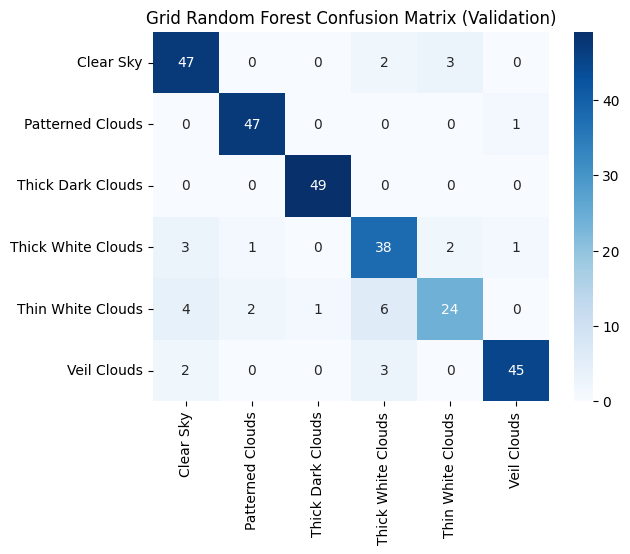

Classification Report:
                    precision    recall  f1-score   support

         Clear Sky       0.84      0.90      0.87        52
  Patterned Clouds       0.94      0.98      0.96        48
 Thick Dark Clouds       0.98      1.00      0.99        49
Thick White Clouds       0.78      0.84      0.81        45
 Thin White Clouds       0.83      0.65      0.73        37
       Veil Clouds       0.96      0.90      0.93        50

          accuracy                           0.89       281
         macro avg       0.89      0.88      0.88       281
      weighted avg       0.89      0.89      0.89       281


Randomized Random Forest on Validation:
Accuracy: 0.8897
Precision: 0.8903
Recall: 0.8897
F1 Score: 0.8879


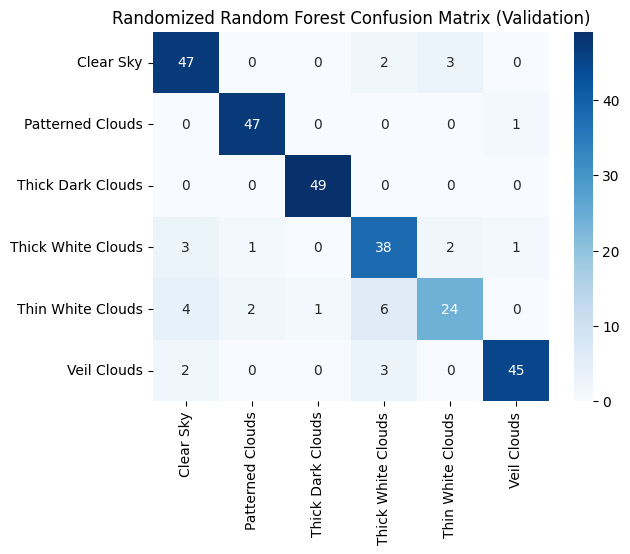

Classification Report:
                    precision    recall  f1-score   support

         Clear Sky       0.84      0.90      0.87        52
  Patterned Clouds       0.94      0.98      0.96        48
 Thick Dark Clouds       0.98      1.00      0.99        49
Thick White Clouds       0.78      0.84      0.81        45
 Thin White Clouds       0.83      0.65      0.73        37
       Veil Clouds       0.96      0.90      0.93        50

          accuracy                           0.89       281
         macro avg       0.89      0.88      0.88       281
      weighted avg       0.89      0.89      0.89       281



In [21]:
grid_rf_val_accuracy = evaluate_model(best_grid_rf, X_val_new, y_val, 'Grid Random Forest', 'Validation')

randomized_rf_val_accuracy = evaluate_model(best_randomized_rf, X_val_new, y_val, 'Randomized Random Forest', 'Validation')

### Model predicts on test set


Grid Random Forest on Test:
Accuracy: 0.8404
Precision: 0.8461
Recall: 0.8404
F1 Score: 0.8376


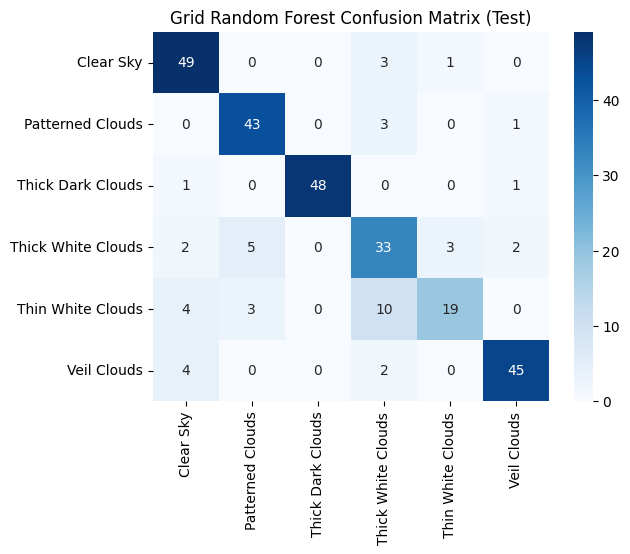

Classification Report:
                    precision    recall  f1-score   support

         Clear Sky       0.82      0.92      0.87        53
  Patterned Clouds       0.84      0.91      0.88        47
 Thick Dark Clouds       1.00      0.96      0.98        50
Thick White Clouds       0.65      0.73      0.69        45
 Thin White Clouds       0.83      0.53      0.64        36
       Veil Clouds       0.92      0.88      0.90        51

          accuracy                           0.84       282
         macro avg       0.84      0.82      0.83       282
      weighted avg       0.85      0.84      0.84       282




Randomized Random Forest on Validation:
Accuracy: 0.8404
Precision: 0.8461
Recall: 0.8404
F1 Score: 0.8376


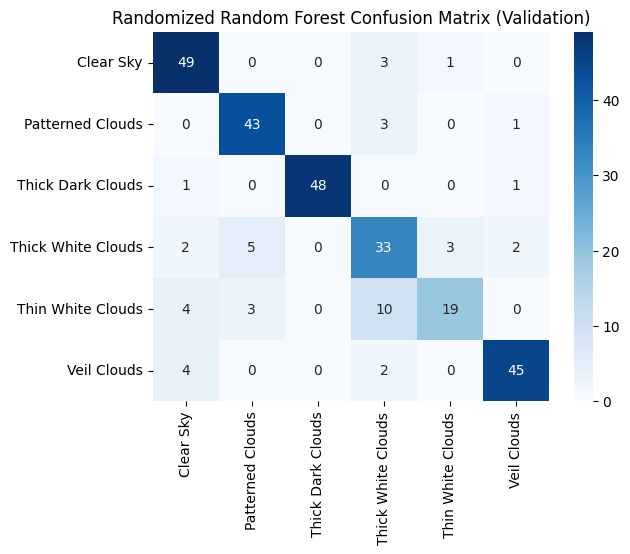

Classification Report:
                    precision    recall  f1-score   support

         Clear Sky       0.82      0.92      0.87        53
  Patterned Clouds       0.84      0.91      0.88        47
 Thick Dark Clouds       1.00      0.96      0.98        50
Thick White Clouds       0.65      0.73      0.69        45
 Thin White Clouds       0.83      0.53      0.64        36
       Veil Clouds       0.92      0.88      0.90        51

          accuracy                           0.84       282
         macro avg       0.84      0.82      0.83       282
      weighted avg       0.85      0.84      0.84       282



In [22]:
grid_rf_test_accuracy = evaluate_model(best_grid_rf, X_test_new, y_test, 'Grid Random Forest', 'Test')
print('\n')
randomized_rf_test_accuracy = evaluate_model(best_randomized_rf, X_test_new, y_test, 'Randomized Random Forest', 'Validation')

## SVM

### Model intialization and fitting the data

In [23]:
# SVM with grid search
# start_time = time.time()

param_svm = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}

svm = SVC(kernel='rbf', probability=True, random_state=42)

start_time = time.time()
grid_search_svm = GridSearchCV(svm, param_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train_new, y_train)
best_grid_svm = grid_search_svm.best_estimator_

end_time = time.time()
print(f'Best SVM Parameters using gird search: {grid_search_svm.best_params_}')
print(f'Grid SVM took {(end_time-start_time):.2f} seconds to run')

start_time = time.time()
randomized_search_svm = RandomizedSearchCV(
    svm,
    param_distributions=param_svm,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42    
)

randomized_search_svm.fit(X_train_new, y_train)
best_randomized_svm = randomized_search_svm.best_estimator_

end_time = time.time()
print(f'Best SVM Parameters using randomized search: {randomized_search_svm.best_params_}')
print(f'Randomized SVM took {(end_time - start_time):.2f} seconds to run')


# end_time = time.time()
# print(f'SVM model took: {(end_time - start_time):.2f} seconds to run train')

Best SVM Parameters using gird search: {'C': 10, 'gamma': 'scale'}
Grid SVM took 2.64 seconds to run


C:\Users\Admin\PycharmProjects\MachineLearning\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best SVM Parameters using randomized search: {'gamma': 'scale', 'C': 10}
Randomized SVM took 2.59 seconds to run


### Model predicts on validation set


Grid SVM on Validation:
Accuracy: 0.9075
Precision: 0.9070
Recall: 0.9075
F1 Score: 0.9070


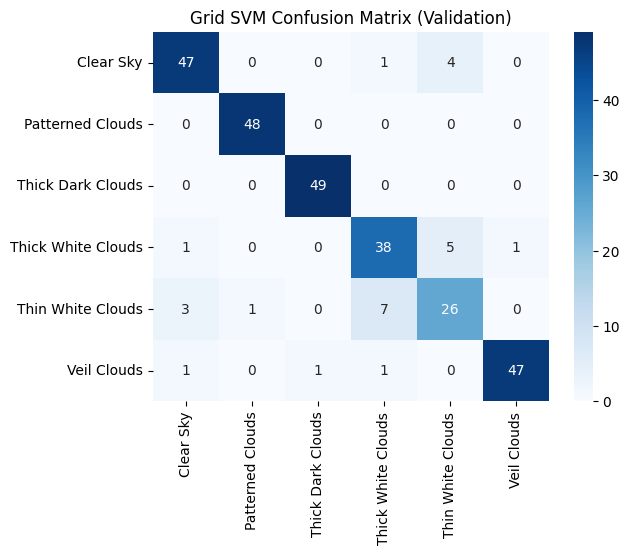

Classification Report:
                    precision    recall  f1-score   support

         Clear Sky       0.90      0.90      0.90        52
  Patterned Clouds       0.98      1.00      0.99        48
 Thick Dark Clouds       0.98      1.00      0.99        49
Thick White Clouds       0.81      0.84      0.83        45
 Thin White Clouds       0.74      0.70      0.72        37
       Veil Clouds       0.98      0.94      0.96        50

          accuracy                           0.91       281
         macro avg       0.90      0.90      0.90       281
      weighted avg       0.91      0.91      0.91       281




Randomized SVM on Validation:
Accuracy: 0.9075
Precision: 0.9070
Recall: 0.9075
F1 Score: 0.9070


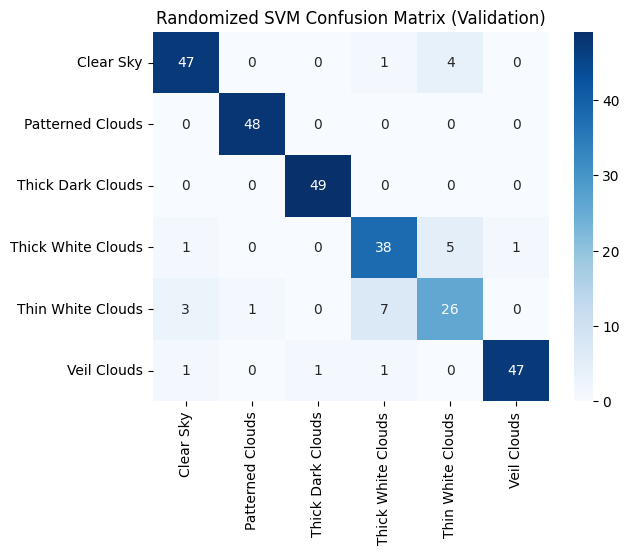

Classification Report:
                    precision    recall  f1-score   support

         Clear Sky       0.90      0.90      0.90        52
  Patterned Clouds       0.98      1.00      0.99        48
 Thick Dark Clouds       0.98      1.00      0.99        49
Thick White Clouds       0.81      0.84      0.83        45
 Thin White Clouds       0.74      0.70      0.72        37
       Veil Clouds       0.98      0.94      0.96        50

          accuracy                           0.91       281
         macro avg       0.90      0.90      0.90       281
      weighted avg       0.91      0.91      0.91       281



In [24]:
grid_svm_val_accuracy = evaluate_model(best_grid_svm, X_val_new, y_val, 'Grid SVM', 'Validation')
print('\n')
randomized_svm_val_accuracy = evaluate_model(best_randomized_svm, X_val_new, y_val, 'Randomized SVM', 'Validation')

### Model predicts on test set


Grid SVM on Test:
Accuracy: 0.9043
Precision: 0.9023
Recall: 0.9043
F1 Score: 0.9017


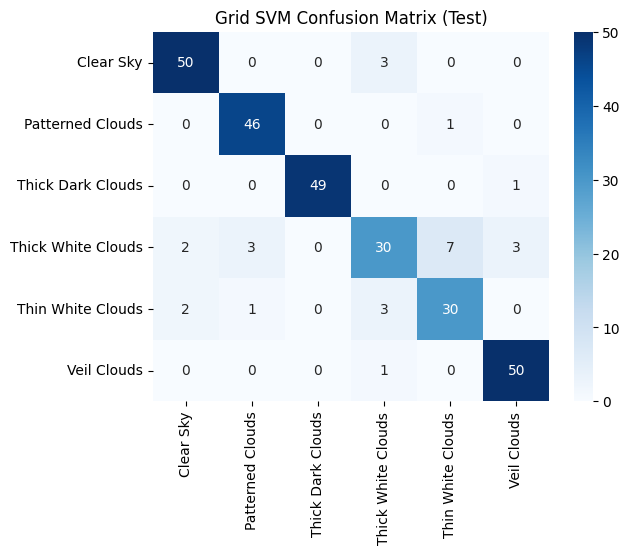

Classification Report:
                    precision    recall  f1-score   support

         Clear Sky       0.93      0.94      0.93        53
  Patterned Clouds       0.92      0.98      0.95        47
 Thick Dark Clouds       1.00      0.98      0.99        50
Thick White Clouds       0.81      0.67      0.73        45
 Thin White Clouds       0.79      0.83      0.81        36
       Veil Clouds       0.93      0.98      0.95        51

          accuracy                           0.90       282
         macro avg       0.90      0.90      0.89       282
      weighted avg       0.90      0.90      0.90       282


Randomized SVM on Test:
Accuracy: 0.9043
Precision: 0.9023
Recall: 0.9043
F1 Score: 0.9017


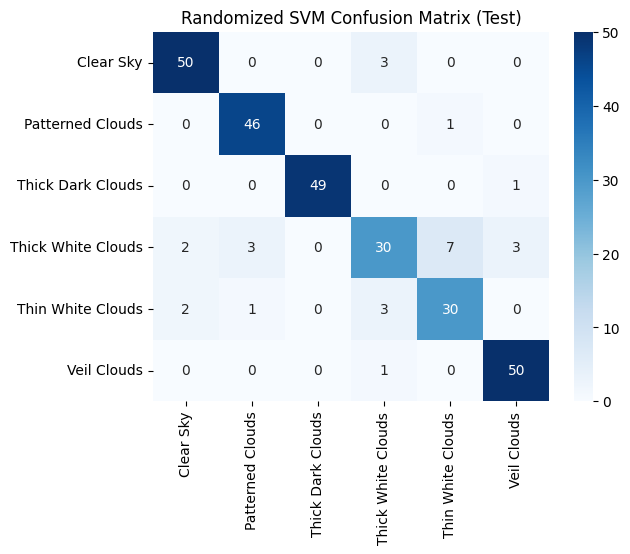

Classification Report:
                    precision    recall  f1-score   support

         Clear Sky       0.93      0.94      0.93        53
  Patterned Clouds       0.92      0.98      0.95        47
 Thick Dark Clouds       1.00      0.98      0.99        50
Thick White Clouds       0.81      0.67      0.73        45
 Thin White Clouds       0.79      0.83      0.81        36
       Veil Clouds       0.93      0.98      0.95        51

          accuracy                           0.90       282
         macro avg       0.90      0.90      0.89       282
      weighted avg       0.90      0.90      0.90       282



In [25]:
grid_svm_test_accuracy = evaluate_model(best_grid_svm, X_test_new, y_test, 'Grid SVM', 'Test')

randomized_svm_test_accuracy = evaluate_model(best_randomized_svm, X_test_new, y_test, 'Randomized SVM', 'Test')

## KNN

### Model intialization and fitting the data

In [26]:
# KNN with grid search
start_time = time.time()

param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train_new, y_train)
best_knn = grid_search_knn.best_estimator_
print(f'Best KNN Parameters: {grid_search_knn.best_params_}')

end_time = time.time()
print(f'KNN model took: {(end_time - start_time):.2f} seconds to run')

Best KNN Parameters: {'n_neighbors': 3, 'weights': 'distance'}
KNN model took: 0.34 seconds to run


### Model predicts on validation set


KNN on Validation:
Accuracy: 0.8754
Precision: 0.8739
Recall: 0.8754
F1 Score: 0.8713


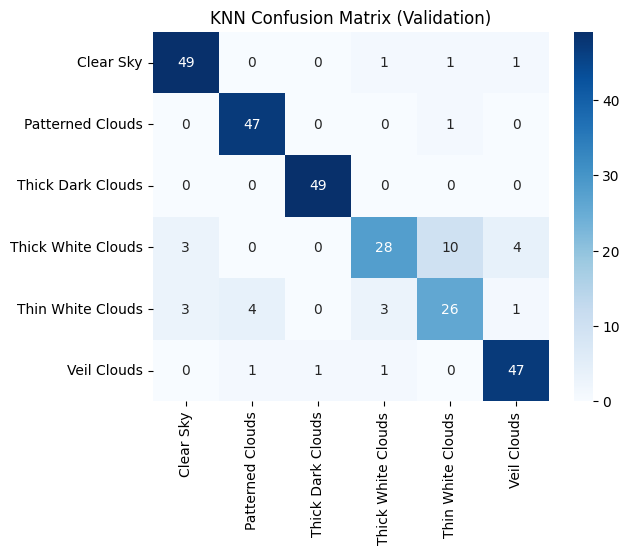

Classification Report:
                    precision    recall  f1-score   support

         Clear Sky       0.89      0.94      0.92        52
  Patterned Clouds       0.90      0.98      0.94        48
 Thick Dark Clouds       0.98      1.00      0.99        49
Thick White Clouds       0.85      0.62      0.72        45
 Thin White Clouds       0.68      0.70      0.69        37
       Veil Clouds       0.89      0.94      0.91        50

          accuracy                           0.88       281
         macro avg       0.87      0.86      0.86       281
      weighted avg       0.87      0.88      0.87       281



In [27]:
knn_val_accuracy = evaluate_model(best_knn, X_val_new, y_val, 'KNN', 'Validation')

### Model predicts on test set


KNN on Test:
Accuracy: 0.8582
Precision: 0.8509
Recall: 0.8582
F1 Score: 0.8496


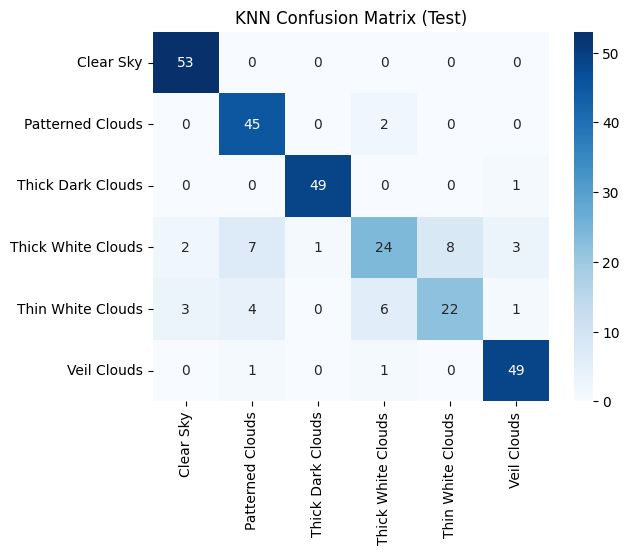

Classification Report:
                    precision    recall  f1-score   support

         Clear Sky       0.91      1.00      0.95        53
  Patterned Clouds       0.79      0.96      0.87        47
 Thick Dark Clouds       0.98      0.98      0.98        50
Thick White Clouds       0.73      0.53      0.62        45
 Thin White Clouds       0.73      0.61      0.67        36
       Veil Clouds       0.91      0.96      0.93        51

          accuracy                           0.86       282
         macro avg       0.84      0.84      0.84       282
      weighted avg       0.85      0.86      0.85       282



In [28]:
knn_test_accuracy = evaluate_model(best_knn, X_test_new, y_test, 'KNN', 'Test')

## Ensemble methods

### Model intialization and fitting the data

In [29]:
# Ensemble with tuned models
start_time = time.time()

ensemble = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)),
        ('svm', SVC(kernel='rbf', C=grid_search_svm.best_params_['C'], gamma=grid_search_svm.best_params_['gamma'], probability=True, random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['n_neighbors'], weights=grid_search_knn.best_params_['weights']))
    ],
    voting='soft',
    weights=[1, 2, 1]
)
ensemble.fit(X_train_new, y_train)

end_time = time.time()
print(f'Model took: {(end_time - start_time):.2f} seconds to run')

Model took: 2.95 seconds to run


### Model predicts on validation set


Ensemble on Validation:
Accuracy: 0.9004
Precision: 0.9001
Recall: 0.9004
F1 Score: 0.9000


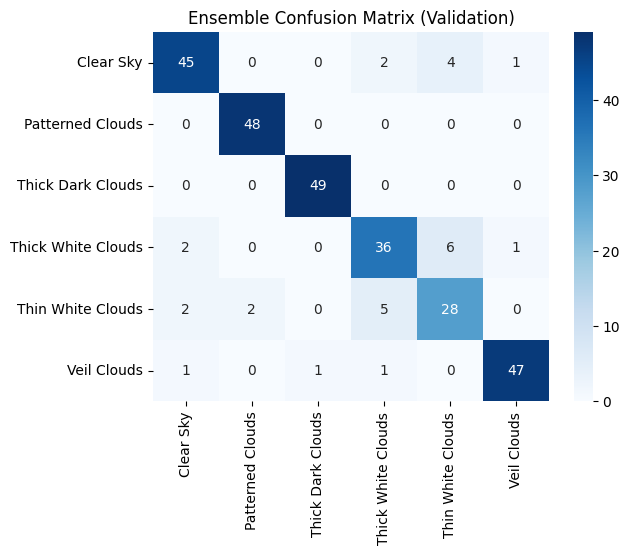

Classification Report:
                    precision    recall  f1-score   support

         Clear Sky       0.90      0.87      0.88        52
  Patterned Clouds       0.96      1.00      0.98        48
 Thick Dark Clouds       0.98      1.00      0.99        49
Thick White Clouds       0.82      0.80      0.81        45
 Thin White Clouds       0.74      0.76      0.75        37
       Veil Clouds       0.96      0.94      0.95        50

          accuracy                           0.90       281
         macro avg       0.89      0.89      0.89       281
      weighted avg       0.90      0.90      0.90       281



In [30]:
ensemble_val_accuracy = evaluate_model(ensemble, X_val_new, y_val, 'Ensemble', 'Validation')

### Model predicts on test set


Ensemble on Test:
Accuracy: 0.9043
Precision: 0.9013
Recall: 0.9043
F1 Score: 0.9018


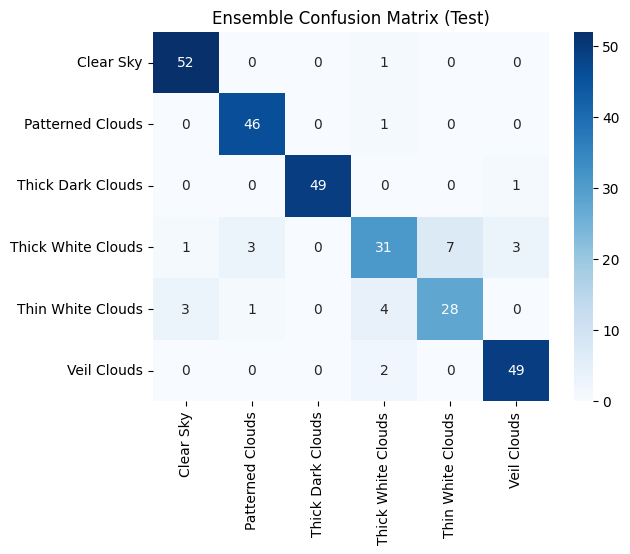

Classification Report:
                    precision    recall  f1-score   support

         Clear Sky       0.93      0.98      0.95        53
  Patterned Clouds       0.92      0.98      0.95        47
 Thick Dark Clouds       1.00      0.98      0.99        50
Thick White Clouds       0.79      0.69      0.74        45
 Thin White Clouds       0.80      0.78      0.79        36
       Veil Clouds       0.92      0.96      0.94        51

          accuracy                           0.90       282
         macro avg       0.89      0.89      0.89       282
      weighted avg       0.90      0.90      0.90       282



In [31]:
ensemble_test_accuracy = evaluate_model(ensemble, X_test_new, y_test, 'Ensemble', 'Test')

In [32]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# ---------------------------------------------
# Hard Voting
ensemble_hard = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)),
        ('svm', SVC(C=grid_search_svm.best_params_['C'],
                    gamma=grid_search_svm.best_params_['gamma'],
                    kernel='rbf',
                    probability=True,
                    random_state=42)),
        ('knn', KNeighborsClassifier(**grid_search_knn.best_params_))
    ],
    voting='hard'
)

ensemble_hard.fit(X_train_new, y_train)
y_pred_hard = ensemble_hard.predict(X_test_new)
print(f"Hard Voting Accuracy: {accuracy_score(y_test, y_pred_hard):.4f}")

# ---------------------------------------------
# Soft Voting (with manual assign - our performance in report)
ensemble_soft = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)),
        ('svm', SVC(C=grid_search_svm.best_params_['C'],
                    gamma=grid_search_svm.best_params_['gamma'],
                    kernel='rbf',
                    probability=True,
                    random_state=42)),
        ('knn', KNeighborsClassifier(**grid_search_knn.best_params_))
    ],
    voting='soft',
    weights=[0.4, 0.3, 0.3]
)

ensemble_soft.fit(X_train_new, y_train)
y_pred_soft = ensemble_soft.predict(X_test_new)
print(f"Soft Voting Accuracy (manual weights - our performance in report): {accuracy_score(y_test, y_pred_soft):.4f}")

# ---------------------------------------------
# Find best hyper-parameter by using GridSearch for Soft Voting
ensemble_soft_grid = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)),
        ('svm', SVC(C=grid_search_svm.best_params_['C'],
                    gamma=grid_search_svm.best_params_['gamma'],
                    kernel='rbf',
                    probability=True,
                    random_state=42)),
        ('knn', KNeighborsClassifier(**grid_search_knn.best_params_))
    ],
    voting='soft'
)

param_grid = {
    'weights': [
        [1, 1, 1],
        [2, 1, 1],
        [1, 2, 1],
        [1, 1, 2],
        [0.4, 0.3, 0.3],
        [0.5, 0.3, 0.2]
    ]
}

grid = GridSearchCV(ensemble_soft_grid, param_grid, cv=5)
grid.fit(X_train_new, y_train)
print(f"Best weights from GridSearch: {grid.best_params_['weights']}")
print(f"Best CV Score (training): {grid.best_score_:.4f}")

# Apply on test set with best hyper-parameter:
best_ensemble_soft = grid.best_estimator_
y_pred_best_soft = best_ensemble_soft.predict(X_test_new)
print(f"Soft Voting Accuracy (best weights): {accuracy_score(y_test, y_pred_best_soft):.4f}")

# ---------------------------------------------
# Stacking Classifier
stacking = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)),
        ('svm', SVC(C=grid_search_svm.best_params_['C'],
                    gamma=grid_search_svm.best_params_['gamma'],
                    kernel='rbf',
                    probability=True,
                    random_state=42)),
        ('knn', KNeighborsClassifier(**grid_search_knn.best_params_))
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

stacking.fit(X_train_new, y_train)
y_pred_stacking = stacking.predict(X_test_new)
print(f"Stacking Accuracy: {accuracy_score(y_test, y_pred_stacking):.4f}")

Hard Voting Accuracy: 0.8830
Soft Voting Accuracy (manual weights - our performance in report): 0.8901
Best weights from GridSearch: [1, 2, 1]
Best CV Score (training): 0.9047
Soft Voting Accuracy (best weights): 0.9043
Stacking Accuracy: 0.9078


# Display models with accuracy score surpassed the inital benchmark

In [33]:
# Save the best model if it meets the benchmark
# best_accuracy = max(rf_test_accuracy, svm_test_accuracy, knn_test_accuracy, ensemble_test_accuracy)

# if best_accuracy >= 0.90:
#     print(f"\nBenchmark achieved! Best test accuracy: {best_accuracy:.4f}")
# else:
#     print(f"\nBenchmark not achieved. Best test accuracy: {best_accuracy:.4f}. Consider further tuning or additional features.")

benchmark = 0.9

models_acc_dict = {
    'Random Forrest using grid search': grid_rf_test_accuracy,
    'Random Forrest using randomized search': randomized_rf_test_accuracy,
    'SVM using grid search': grid_svm_test_accuracy,
    'SVM using randomized search': randomized_svm_test_accuracy,
    'KNN': knn_test_accuracy,
    'Ensemble methods': ensemble_test_accuracy
}

for model_name in models_acc_dict:
    if models_acc_dict[model_name] >= benchmark:
        print(f"{model_name} model's accuracy score: {models_acc_dict[model_name]:.2f}, which has surpassed the initial benchmark: {benchmark:.2f}")

SVM using grid search model's accuracy score: 0.90, which has surpassed the initial benchmark: 0.90
SVM using randomized search model's accuracy score: 0.90, which has surpassed the initial benchmark: 0.90
Ensemble methods model's accuracy score: 0.90, which has surpassed the initial benchmark: 0.90
